
# **0. 준비**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 나눔 폰트 설치 / 한글 깨짐 방지 , 런타임 다시 시작하기
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

In [2]:
# 시각화에 사용할 팔레트
plt.style.available

sns.color_palette("pastel")
sns.set(palette='pastel')


# **1. 데이터 구조 파악**

#### **(1) 데이터 불러오기**

[Feature variable] - 10개
* tm : 시간 (날짜 및 시각, 00시~23시)
* branch_id : 지사명 (비식별화 처리)
* ta : 기온 (정시 기온,°C)
* wd : 풍향 (정시 10분 평균 풍향, degree)
* ws : 풍속 (정시 10분 평균 풍속, m/s)
* rn_day : 일 강수량 (해당 시간까지의 일강수량, mm)
* rn_hr1 : 시간 강수량 (1시간 강수량, mm)
* hm : 상대 습도 (정시 상대 습도, %)
* si : 일사량 (ASOS 일사량, MJ/m^2)
* ta_chi : 체감온도 (500m 객관분석 자료,°C)

[Target Variable]
* heat_demand : 열수요 (시간당 지사별 열 공급량, Gcal/h)

In [3]:
# train data 불러오기
df_train = pd.read_csv("/content/drive/MyDrive/weather_bigcontest/data/train_heat.csv")
df_train = df_train.iloc[:,1:]
df_train

train_heat.tm train_heat.branch_id  train_heat.ta  train_heat.wd  \
0          2021010101                    A          -10.1           78.3   
1          2021010102                    A          -10.2           71.9   
2          2021010103                    A          -10.0          360.0   
3          2021010104                    A           -9.3          155.9   
4          2021010105                    A           -9.0           74.3   
...               ...                  ...            ...            ...   
499296     2023123119                    S            3.2          233.5   
499297     2023123120                    S            2.9          227.4   
499298     2023123121                    S            2.1          360.0   
499299     2023123122                    S            2.2           30.0   
499300     2023123123                    S            1.2          359.0   

        train_heat.ws  train_heat.rn_day  train_heat.rn_hr1  train_heat.hm  \
0                 0.5                0.0                0.0           68.2   
1                 0.6                0.0                0.0           69.9   
2                 0.0                0.0                0.0           69.2   
3                 0.5                0.0                0.0           65.0   
4                 1.9                0.0                0.0           63.5   
...               ...                ...                ...            ...   
499296            0.4                2.5                0.0           91.5   
499297            0.1                2.5                0.0           92.1   
499298            0.0                2.5                0.0           93.3   
499299            1.4                2.5                0.0           95.5   
499300            0.8                2.5                0.0           94.9   

        train_heat.si  train_heat.ta_chi  train_heat.heat_demand  
0               -99.0               -8.2                     281  
1               -99.0               -8.6                     262  
2               -99.0               -8.8                     266  
3               -99.0               -8.9                     285  
4               -99.0               -9.2                     283  
...               ...                ...                     ...  
499296          -99.0                2.8                      34  
499297          -99.0                2.7                      35  
499298          -99.0                1.4                      35  
499299          -99.0                1.3                      40  
499300          -99.0                0.6                      33  

[499301 rows x 11 columns]

#### **(2) 데이터 확인하기**

In [4]:
# 변수명 정리
df_train.columns = [col.replace("train_heat.", "") for col in df_train.columns]

In [5]:
# tm 변수 datetime 처리
df_train['tm'] = pd.to_datetime(df_train['tm'].astype(str), format='%Y%m%d%H')

In [6]:
df_train.head()

tm branch_id    ta     wd   ws  rn_day  rn_hr1    hm    si  \
0 2021-01-01 01:00:00         A -10.1   78.3  0.5     0.0     0.0  68.2 -99.0   
1 2021-01-01 02:00:00         A -10.2   71.9  0.6     0.0     0.0  69.9 -99.0   
2 2021-01-01 03:00:00         A -10.0  360.0  0.0     0.0     0.0  69.2 -99.0   
3 2021-01-01 04:00:00         A  -9.3  155.9  0.5     0.0     0.0  65.0 -99.0   
4 2021-01-01 05:00:00         A  -9.0   74.3  1.9     0.0     0.0  63.5 -99.0   

   ta_chi  heat_demand  
0    -8.2          281  
1    -8.6          262  
2    -8.8          266  
3    -8.9          285  
4    -9.2          283

In [7]:
df_train.shape # 12개의 열, 10999개의 행

(499301, 11)

In [8]:
df_train.describe()

tm             ta             wd             ws  \
count               499301  499301.000000  499301.000000  499301.000000   
mean   2022-07-02 12:00:00      10.621007     194.322872      -2.344705   
min    2021-01-01 01:00:00     -99.000000     -99.000000     -99.000000   
25%    2021-10-01 18:00:00       4.400000     105.000000       0.500000   
50%    2022-07-02 12:00:00      14.200000     212.100000       1.100000   
75%    2023-04-02 06:00:00      22.500000     294.300000       2.000000   
max    2023-12-31 23:00:00      37.800000     360.000000      11.900000   
std                    NaN      20.878917     118.348853      19.161911   

              rn_day         rn_hr1             hm             si  \
count  499301.000000  499301.000000  499301.000000  499301.000000   
mean       -1.843207      -3.649492      53.024052     -45.600886   
min       -99.000000     -99.000000     -99.000000     -99.000000   
25%         0.000000       0.000000      44.900000     -99.000000   
50%         0.000000       0.000000      64.700000       0.000000   
75%         0.000000       0.000000      82.500000       0.960000   
max       326.500000      92.500000     100.000000       3.920000   
std        21.340679      19.082926      49.080340      49.938291   

              ta_chi    heat_demand  
count  499301.000000  499301.000000  
mean       13.869692      95.861923  
min       -99.000000     -99.000000  
25%         4.400000      25.000000  
50%        15.000000      55.000000  
75%        24.300000     116.000000  
max        37.100000     966.000000  
std        11.888126     115.269280

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499301 entries, 0 to 499300
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           499301 non-null  datetime64[ns]
 1   branch_id    499301 non-null  object        
 2   ta           499301 non-null  float64       
 3   wd           499301 non-null  float64       
 4   ws           499301 non-null  float64       
 5   rn_day       499301 non-null  float64       
 6   rn_hr1       499301 non-null  float64       
 7   hm           499301 non-null  float64       
 8   si           499301 non-null  float64       
 9   ta_chi       499301 non-null  float64       
 10  heat_demand  499301 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 41.9+ MB


=> 실제로는 결측치가 -99로 되어있어 존재함.

In [10]:
# -99 포함 여부 확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -99.0).any()]
print("'-99.0' 포함 열:", cols_with_neg99)

'-99.0' 포함 열: ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']


In [11]:
# -99.0을 np.nan으로 바꾸기
df_train[cols_with_neg99] = df_train[cols_with_neg99].replace(-99.0, np.nan)

# np.nan으로 변경 후, 포함 여부 재확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -99.0).any()]
print("'-99.0' 포함 열:", cols_with_neg99)

'-99.0' 포함 열: []


* 다시 데이터 확인

In [12]:
df_train.head()

tm branch_id    ta     wd   ws  rn_day  rn_hr1    hm  si  \
0 2021-01-01 01:00:00         A -10.1   78.3  0.5     0.0     0.0  68.2 NaN   
1 2021-01-01 02:00:00         A -10.2   71.9  0.6     0.0     0.0  69.9 NaN   
2 2021-01-01 03:00:00         A -10.0  360.0  0.0     0.0     0.0  69.2 NaN   
3 2021-01-01 04:00:00         A  -9.3  155.9  0.5     0.0     0.0  65.0 NaN   
4 2021-01-01 05:00:00         A  -9.0   74.3  1.9     0.0     0.0  63.5 NaN   

   ta_chi  heat_demand  
0    -8.2        281.0  
1    -8.6        262.0  
2    -8.8        266.0  
3    -8.9        285.0  
4    -9.2        283.0

In [13]:
df_train.shape

(499301, 11)

In [14]:
df_train.describe()

tm             ta             wd             ws  \
count               499301  486304.000000  480486.000000  480486.000000   
mean   2022-07-02 12:00:00      13.550747     205.808888       1.440149   
min    2021-01-01 01:00:00     -19.700000      -9.900000       0.000000   
25%    2021-10-01 18:00:00       5.200000     118.500000       0.500000   
50%    2022-07-02 12:00:00      14.700000     220.800000       1.200000   
75%    2023-04-02 06:00:00      22.700000     297.100000       2.100000   
max    2023-12-31 23:00:00      37.800000     360.000000      11.900000   
std                    NaN      10.855174     105.137403       1.185264   

              rn_day         rn_hr1             hm             si  \
count  480675.000000  480147.000000  459584.000000  266379.000000   
mean        1.921587       0.154225      66.161889       1.091339   
min         0.000000       0.000000       2.500000       0.000000   
25%         0.000000       0.000000      50.300000       0.210000   
50%         0.000000       0.000000      67.600000       0.850000   
75%         0.000000       0.000000      84.000000       1.820000   
max       326.500000      92.500000     100.000000       3.920000   
std         9.649994       1.236777      21.146626       0.972380   

              ta_chi    heat_demand  
count  499281.000000  499278.000000  
mean       13.874214      95.870900  
min       -24.700000       0.000000  
25%         4.400000      25.000000  
50%        15.000000      55.000000  
75%        24.300000     116.000000  
max        37.100000     966.000000  
std        11.866881     115.264347

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499301 entries, 0 to 499300
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           499301 non-null  datetime64[ns]
 1   branch_id    499301 non-null  object        
 2   ta           486304 non-null  float64       
 3   wd           480486 non-null  float64       
 4   ws           480486 non-null  float64       
 5   rn_day       480675 non-null  float64       
 6   rn_hr1       480147 non-null  float64       
 7   hm           459584 non-null  float64       
 8   si           266379 non-null  float64       
 9   ta_chi       499281 non-null  float64       
 10  heat_demand  499278 non-null  float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 41.9+ MB


In [16]:
# 결측치 확인
missing_df = pd.DataFrame({
    'Missing Count': df_train.isnull().sum(),
    'Missing Ratio (%)': df_train.isnull().mean() * 100
})

# 결측치가 있는 열만 추출
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)
print(missing_df)

             Missing Count  Missing Ratio (%)
si                  232922          46.649616
hm                   39717           7.954520
rn_hr1               19154           3.836163
ws                   18815           3.768268
wd                   18815           3.768268
rn_day               18626           3.730415
ta                   12997           2.603039
heat_demand             23           0.004606
ta_chi                  20           0.004006


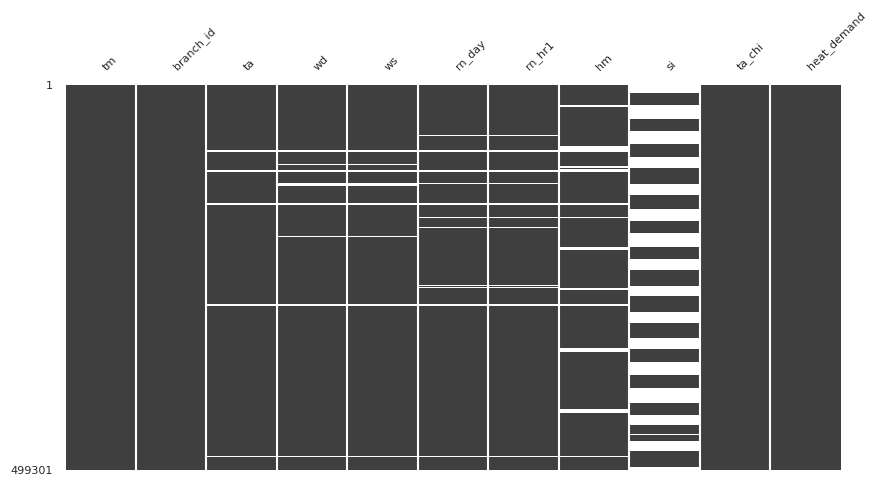

In [17]:
# 전체 결측치 matrix 시각화
fig, ax = plt.subplots(figsize=(10, 5))
msno.matrix(df_train,ax=ax)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
plt.show()

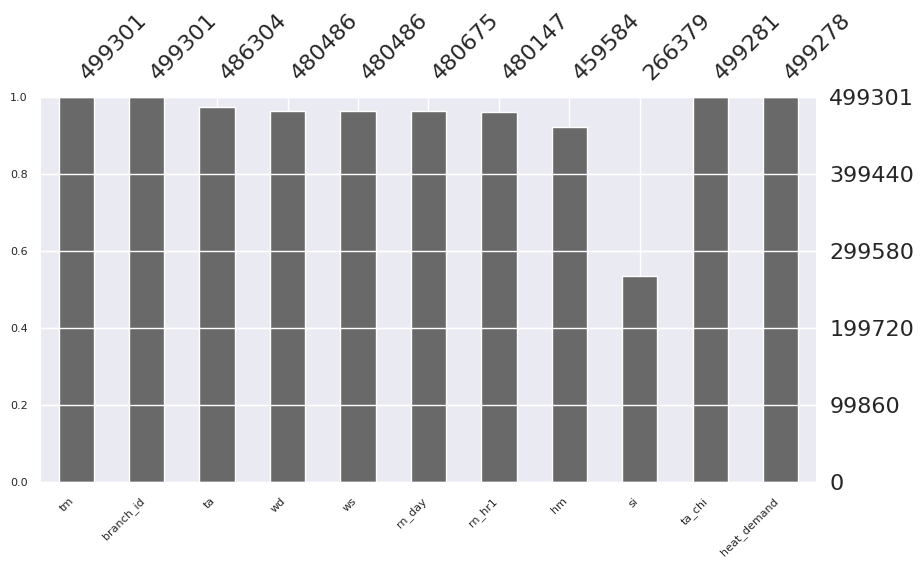

In [18]:
# 막대그래프 형태로 시각화
fig, ax = plt.subplots(figsize=(10, 5))
msno.bar(df_train, ax=ax)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
plt.show()

* Target에 결측치가 있는 경우 데이터 삭제

In [19]:
# 타겟 변수 heat_demand에 결측이 있는 행 제거
df_train = df_train.dropna(subset=['heat_demand']).reset_index(drop=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499278 entries, 0 to 499277
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           499278 non-null  datetime64[ns]
 1   branch_id    499278 non-null  object        
 2   ta           486283 non-null  float64       
 3   wd           480465 non-null  float64       
 4   ws           480465 non-null  float64       
 5   rn_day       480654 non-null  float64       
 6   rn_hr1       480126 non-null  float64       
 7   hm           459567 non-null  float64       
 8   si           266370 non-null  float64       
 9   ta_chi       499258 non-null  float64       
 10  heat_demand  499278 non-null  float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 41.9+ MB


* 시간 관련 변수 생성

In [20]:
def get_season(month):
    if month in [11, 12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [21]:
df_train['year'] = df_train['tm'].dt.year # 연도
df_train['quarter'] = df_train['tm'].dt.quarter # 분기별
df_train['month'] = df_train['tm'].dt.month # 월
df_train['day_of_week'] = df_train['tm'].dt.dayofweek # 요일
df_train['season'] = df_train['month'].apply(get_season) # 계절
df_train['is_weekend'] = df_train['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday') # 주말 여부
df_train['weekofyear'] = df_train['tm'].dt.isocalendar().week # 주차

# 3시간 단위 시간대 컬럼 생성 (0~23시 → 0~7로 구간화)
df_train['hour_group'] = (df_train['tm'].dt.hour // 3).astype(int)
hour_labels = ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']

In [22]:
df_train.head()

tm branch_id    ta     wd   ws  rn_day  rn_hr1    hm  si  \
0 2021-01-01 01:00:00         A -10.1   78.3  0.5     0.0     0.0  68.2 NaN   
1 2021-01-01 02:00:00         A -10.2   71.9  0.6     0.0     0.0  69.9 NaN   
2 2021-01-01 03:00:00         A -10.0  360.0  0.0     0.0     0.0  69.2 NaN   
3 2021-01-01 04:00:00         A  -9.3  155.9  0.5     0.0     0.0  65.0 NaN   
4 2021-01-01 05:00:00         A  -9.0   74.3  1.9     0.0     0.0  63.5 NaN   

   ta_chi  heat_demand  year  quarter  month  day_of_week  season is_weekend  \
0    -8.2        281.0  2021        1      1            4  Winter    Weekday   
1    -8.6        262.0  2021        1      1            4  Winter    Weekday   
2    -8.8        266.0  2021        1      1            4  Winter    Weekday   
3    -8.9        285.0  2021        1      1            4  Winter    Weekday   
4    -9.2        283.0  2021        1      1            4  Winter    Weekday   

   weekofyear  hour_group  
0          53           0  
1          53           0  
2          53           1  
3          53           1  
4          53           1

# **2. EDA**

### **2-1) 시계열 분석**

##### **(1) 시도표**

In [23]:
daily_avg_df = (
    df_train.copy()
    .assign(date=lambda x: x['tm'].dt.date)
    .groupby('date')['heat_demand']
    .mean()
)

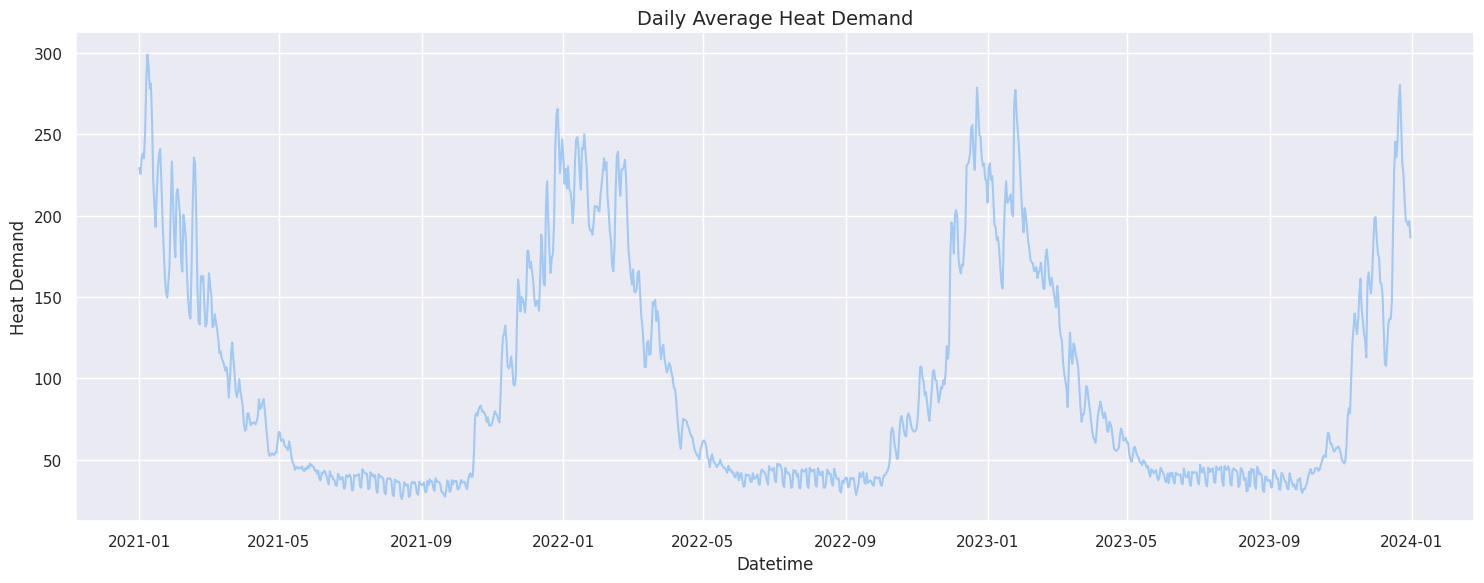

In [24]:
# 시도표
plt.figure(figsize=(15, 6))
plt.plot(daily_avg_df.index, daily_avg_df.values)
plt.title('Daily Average Heat Demand', fontsize=14)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Heat Demand', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()



> 매년 겨울(12월~2월)에 난방 수요가 급증하고, 여름(6월 ~9월)에는 수요가 최소 수준으로 떨어진다. 이는 **계절적 주기성**을 보여줌

> 겨울에는 수요가 높을 뿐만 아니라 일별 편차도 큰 것으로 보임 (그래프가 뾰족하게 튐) 그러나 여름에는 수요도 낮고 변동도 작은 편



##### **(2) STL 분해 그래프**

* 연 단위 주기로 파악

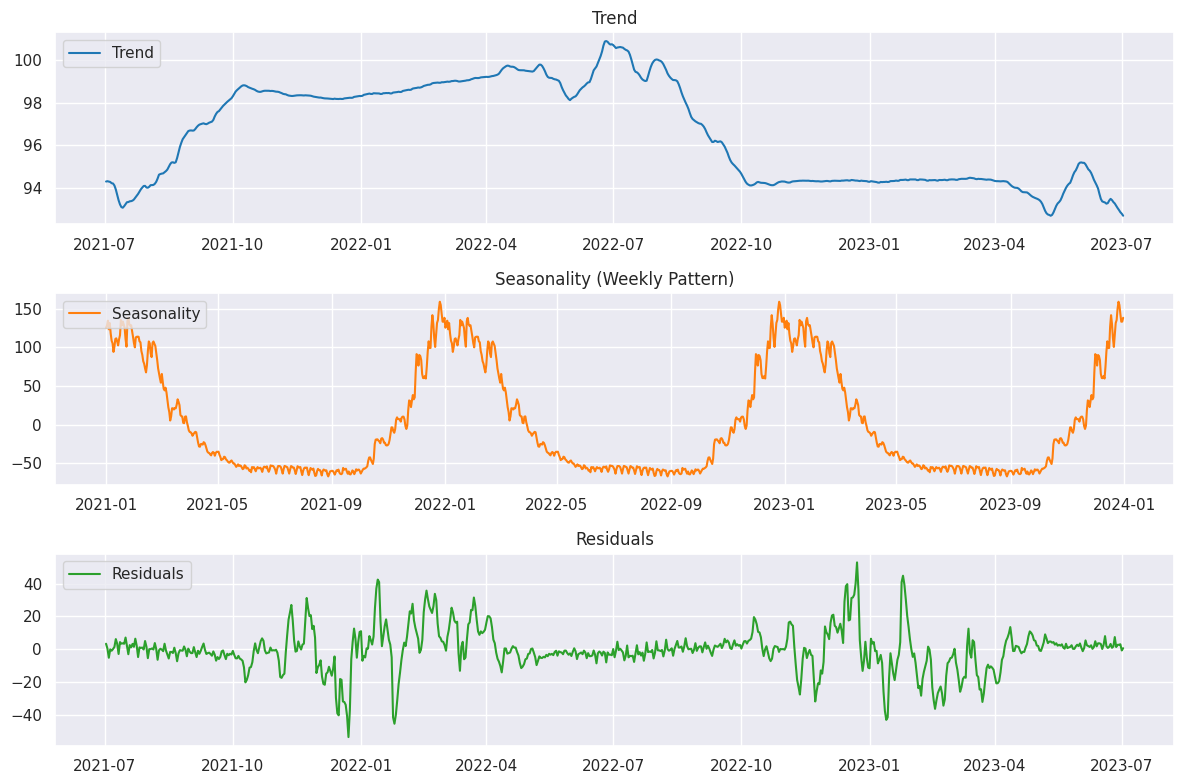

In [ ]:
# STL 분해
result = sm.tsa.seasonal_decompose(daily_avg_df, model='additive', period=365)

colors = plt.cm.tab10.colors
plt.figure(figsize=(12, 8))

# Trend
plt.subplot(3, 1, 1)
plt.plot(result.trend, label='Trend', color=colors[0])
plt.title('Trend')
plt.legend(loc='upper left')

# Seasonality
plt.subplot(3, 1, 2)
plt.plot(result.seasonal, label='Seasonality', color=colors[1])
plt.title('Seasonality (Weekly Pattern)')
plt.legend(loc='upper left')

# Residuals
plt.subplot(3, 1, 3)
plt.plot(result.resid, label='Residuals', color=colors[2])
plt.title('Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()



> Trend(추세) : 2021년 하반기부터 2022년 상반기까지는 완만한 증가 추세를 보이다가, 2022년 중반부터 급격한 감소, 이후 2023년부터는 안정적인 수준을 보인다. (trend는 계절성과 잔차를 제거한 후 남은 부드러운 장기 추세선임.)

> Seasonality : 매년 겨울철에는 계절성이 급상승하며, 여름에는 계절성이 0.5 근처까지 하락함. 이 패턴이 매년 동일하게 나타남

> Residuals(잔차) : 0.8 ~ 1.2 사이에서 일정한 범위로 분포하지만, 특정 구간에서 간헐적으로 튀는 값들이 보임. (ex. 2021년 10월, 2022년 10~11월) 확인이 필요함.





>> 시계열 데이터는 본질적으로 시간을 따라 반복되는 패턴이 존재하는데, 모델은 이 주기성을 이해하지 못함 → 주기성을 수학적으로 설명할 수 있는 방식으로 특징을 만들어 넣는 것이 필요함. 그게 바로 sin, cos변환 / 푸리에 변환임  sin/cos 변환
    
>> sin/cos 변환 : 가장 널리 쓰이는 인코딩 방식으로, 두 개의 변환을 동시에 써야 시간 간 거리가 보존되므로 같이 사용해야 한다. (시간, 요일, 월, 주차 등 주기를 가지는 시간 변수에 사용)
    
>> 푸리에(Fourier) 변환 : 더 복잡한 다중 계절성이 있을 때 사용하는 고차원 주기 인코딩 방식 (order=1이면 sin/cos 1쌍 → order=3이면 sin/cos 3쌍 생성 이런식으로 고차원 반영)



* 월 단위 주기로 파악

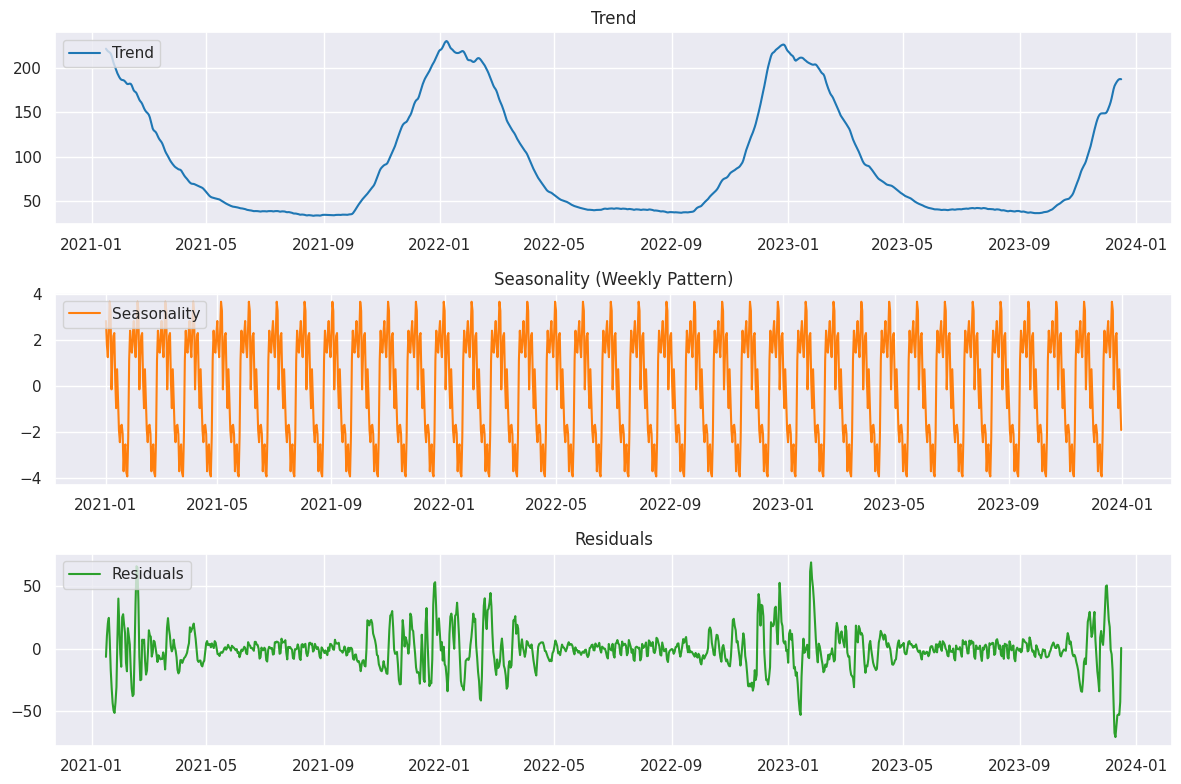

In [ ]:
# STL 분해
result = sm.tsa.seasonal_decompose(daily_avg_df, model='additive', period=30)

colors = plt.cm.tab10.colors
plt.figure(figsize=(12, 8))

# Trend
plt.subplot(3, 1, 1)
plt.plot(result.trend, label='Trend', color=colors[0])
plt.title('Trend')
plt.legend(loc='upper left')

# Seasonality
plt.subplot(3, 1, 2)
plt.plot(result.seasonal, label='Seasonality', color=colors[1])
plt.title('Seasonality (Weekly Pattern)')
plt.legend(loc='upper left')

# Residuals
plt.subplot(3, 1, 3)
plt.plot(result.resid, label='Residuals', color=colors[2])
plt.title('Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

##### **(3) 정상성**

* ACF : 시간 지연에 따라 시계열이 자기 자신과 얼마나 유사한지 측정
* PACF : 해당 시점 이전의 지연을 통제한 뒤 남은 자기상관만 측정

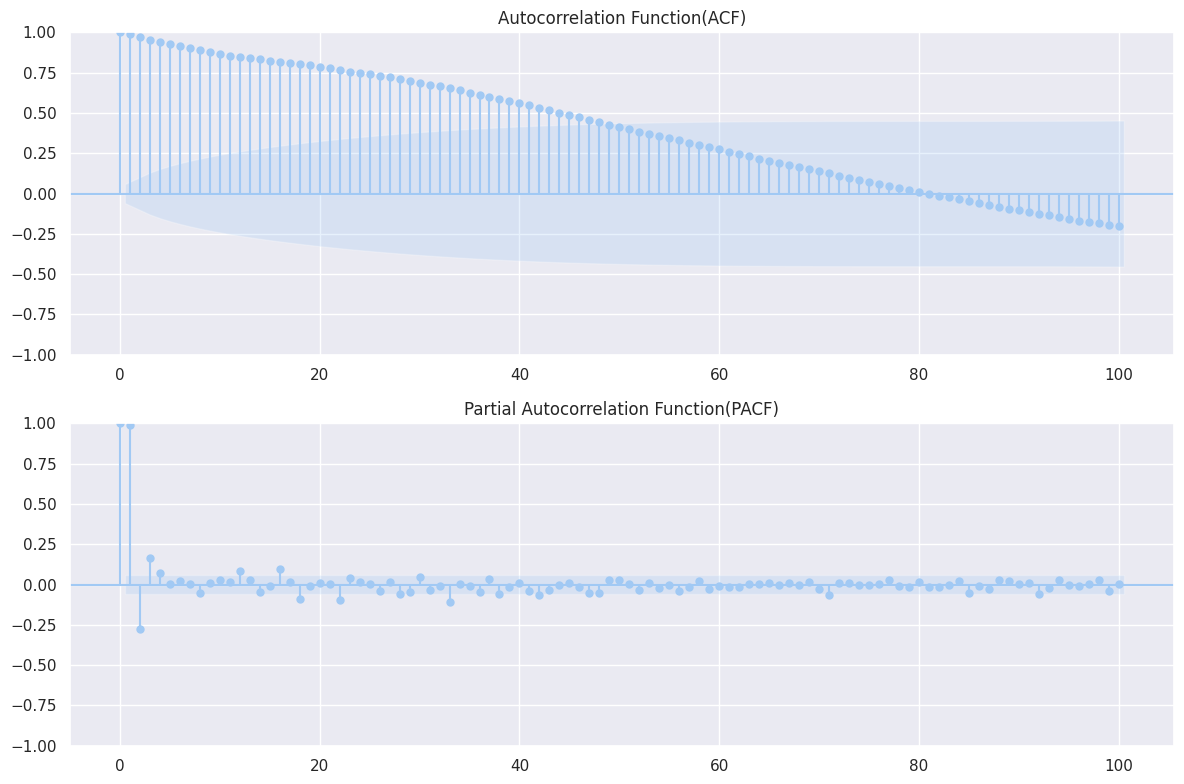

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

sm.graphics.tsa.plot_acf(daily_avg_df, lags=100, ax=axes[0])
axes[0].set_title('Autocorrelation Function(ACF)')

sm.graphics.tsa.plot_pacf(daily_avg_df, lags=100, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function(PACF)')

plt.tight_layout()
plt.show()



> ACF : lag이 커질수록 점진적으로 감소하는 형태이며 lab=80까지는 유의미한 양의 상관관계를 유지함. 이는 비정상 시계열의 전형적인 특징 (추세 또는 계절성이 존재한다는 뜻!, 오늘의 열수요가 이전의 데이터에 영향을 받는다.)

> PACF : lag=1에서 매우 강한 양의 상관관계를 보이며, 3이상부터는 대체로 0에 가까움. AR(1) 모형이 적합할 가능성이 있음 (전날 수요에 강하게 의존한다.) -> 차분 고려


In [ ]:
adf_result = adfuller(daily_average)

print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'    {key}: {value:.4f}')

ADF Statistic: -2.212958320822663
p-value: 0.20157599526129816
Critical Values:
    1%: -3.4365
    5%: -2.8642
    10%: -2.5682




> p-value=0.2016 > 0.05이므로 귀무가설을 기각하지 못하며, 이는 비정상 시계열을 가짐을 의미한다.



### **2-2) Target 분석**

##### **(1) 일별 열수요 평균**

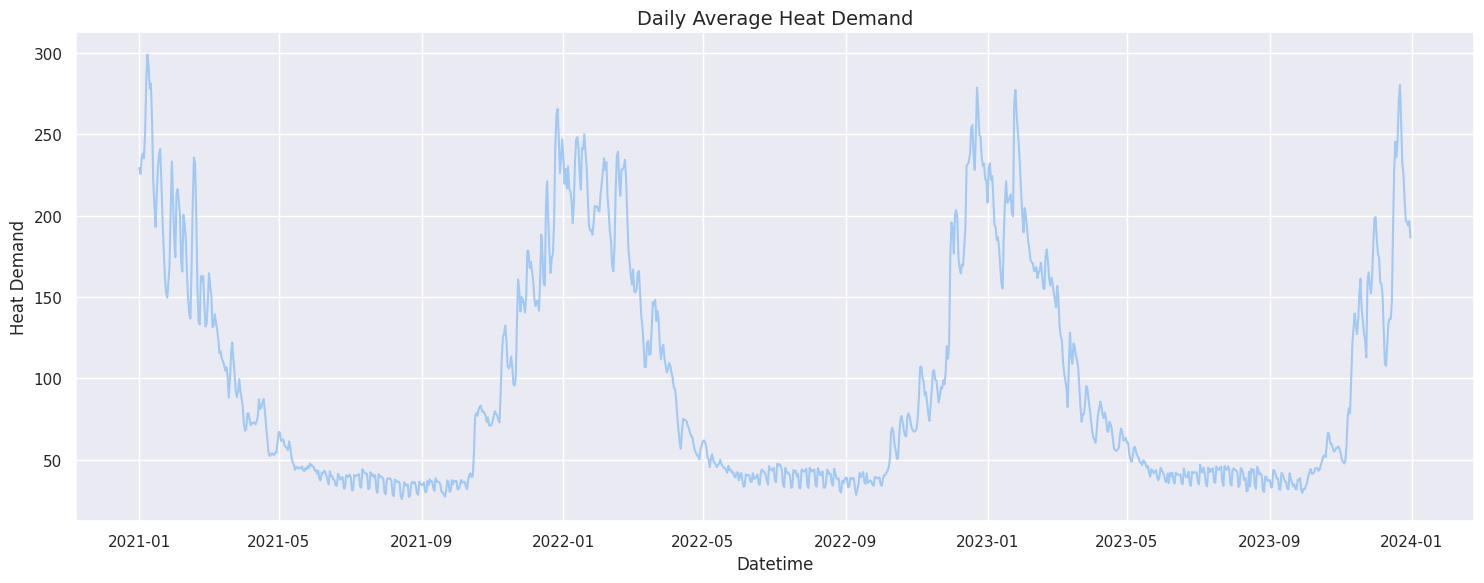

In [ ]:
# 시도표
plt.figure(figsize=(15, 6))
plt.plot(daily_avg_df.index, daily_avg_df.values)
plt.title('Daily Average Heat Demand', fontsize=14)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Heat Demand', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

##### **(2) 분포 시각화**

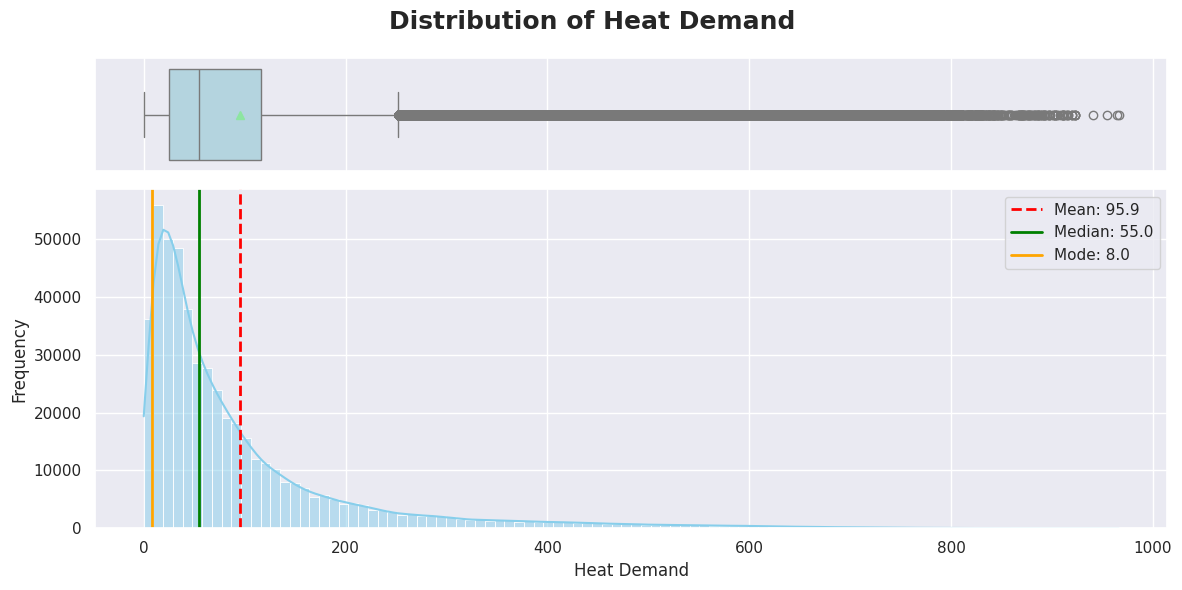

In [ ]:
# 평균, 중앙값, 최빈값 계산
mean = df_train['heat_demand'].mean()
median = df_train['heat_demand'].median()
mode = df_train['heat_demand'].mode()[0]

# 서브플롯 구성 (상단: 박스플롯 / 하단: 히스토그램+분포)
fig, (ax_box, ax_hist) = plt.subplots(
    2, 1,
    gridspec_kw={"height_ratios": (.25, .75)},
    figsize=(12, 6),
    sharex=True
)

fig.suptitle("Distribution of Heat Demand", fontsize=18, fontweight='bold')

# (1) Boxplot
sns.boxplot(
    x=df_train['heat_demand'],
    showmeans=True,
    orient='h',
    color='lightblue',
    ax=ax_box
)
ax_box.set(xlabel='')

# (2) Histogram + 평균/중앙값/최빈값 선
sns.histplot(df_train['heat_demand'], bins=100, kde=True, color='skyblue', ax=ax_hist)
ax_hist.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.1f}')
ax_hist.axvline(median, color='green', linestyle='-', linewidth=2, label=f'Median: {median:.1f}')
ax_hist.axvline(mode, color='orange', linestyle='-', linewidth=2, label=f'Mode: {mode:.1f}')

# 축 및 범례
ax_hist.set_xlabel('Heat Demand', fontsize=12)
ax_hist.set_ylabel('Frequency', fontsize=12)
ax_hist.grid(True)
ax_hist.legend()

plt.tight_layout()
plt.show()



> 오른쪽으로 꼬리가 긴 분포를 가지며, 비대칭적인 분포를 보임 -> 분포의 왜도를 줄일 수 있는 **로그 변환, 또는 Box-Cox 변환**을 고려하자!



* 이상치 파악해보기

In [ ]:
# 이상치 기준 설정
threshold = 930

# 이상치 탐색
outliers = df_train[df_train['heat_demand'] >= threshold]

# 결과 출력
outliers.sort_values('heat_demand', ascending=False)

tm branch_id    ta     wd   ws  rn_day  rn_hr1    hm  \
34914 2021-12-26 22:00:00         B -11.1  343.5  3.1     0.0     0.0  47.6   
34915 2021-12-26 23:00:00         B -11.4   14.0  1.9     0.0     0.0  48.5   
34916 2021-12-27 00:00:00         B -11.4   54.5  0.8     0.0     0.0  49.2   
34913 2021-12-26 21:00:00         B -10.8  346.7  2.8     0.0     0.0  45.8   

       si  ta_chi  heat_demand  year  quarter  month  day_of_week  season  \
34914 NaN   -15.0        966.0  2021        4     12            6  Winter   
34915 NaN   -12.1        964.0  2021        4     12            6  Winter   
34916 NaN   -13.0        955.0  2021        4     12            0  Winter   
34913 NaN   -15.6        941.0  2021        4     12            6  Winter   

      is_weekend  weekofyear  log_heat_demand  
34914    Weekend          51         6.874198  
34915    Weekend          51         6.872128  
34916    Weekday          52         6.862758  
34913    Weekend          51         6.848005

In [ ]:
# 이상치 기준 설정
threshold = 900

# 이상치 탐색
outliers = df_train[df_train['heat_demand'] >= threshold]

# 결과 출력
outliers.sort_values('heat_demand', ascending=False)



> B 지역의 2021년도 12월 26일 ~ 27일 사이가 한파였을 것 같다는 생각 ! 기상청 제공이기도 하고 시기상 아무래도 이상치는 아닐듯



* 로그 변환 후 분포 재시각화

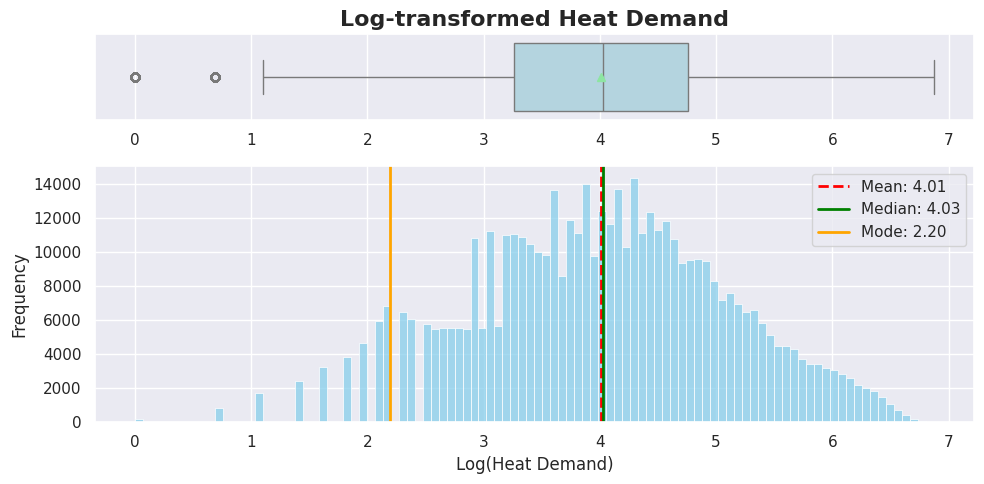

In [ ]:
df_train['log_heat_demand'] = np.log1p(df_train['heat_demand'])  # log(1 + x) 변환

# 시각화
fig, (ax_box, ax_dist) = plt.subplots(2, 1, gridspec_kw={"height_ratios": (.25, .75)}, figsize=(10, 5))

# 로그값에 대한 통계값
mean = df_train['log_heat_demand'].mean()
median = df_train['log_heat_demand'].median()
mode = df_train['log_heat_demand'].mode().iloc[0]

# Boxplot
sns.boxplot(x=df_train['log_heat_demand'], showmeans=True, orient='h', color='lightblue', ax=ax_box)
ax_box.set(xlabel='')
ax_box.set_title("Log-transformed Heat Demand", fontsize=16, fontweight='bold')

# Histogram
sns.histplot(df_train['log_heat_demand'], bins=100, kde=False, ax=ax_dist, color='skyblue')
ax_dist.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}')
ax_dist.axvline(median, color='green', linestyle='-', linewidth=2, label=f'Median: {median:.2f}')
ax_dist.axvline(mode, color='orange', linestyle='-', linewidth=2, label=f'Mode: {mode:.2f}')
ax_dist.set_xlabel('Log(Heat Demand)', fontsize=12)
ax_dist.set_ylabel('Frequency', fontsize=12)
ax_dist.legend()

plt.tight_layout()
plt.show()




> 로그 변환을 통해 열수요 분포의 왜도가 완화됨. 로그 변환 후에도 소수의 이상치가 보이지만, 이는 극단적인 열수요 부족(0 근처의 값들)인 값들을 로그변환 해서 0에 가까운 값이 나온 것으로 보임(이상치로 생각하지 않아도 될 것 같음)



##### **(3) 주별 / 월별 / 년도별 / 요일별 / 계절별 / 주말 여부 열수요 평균**

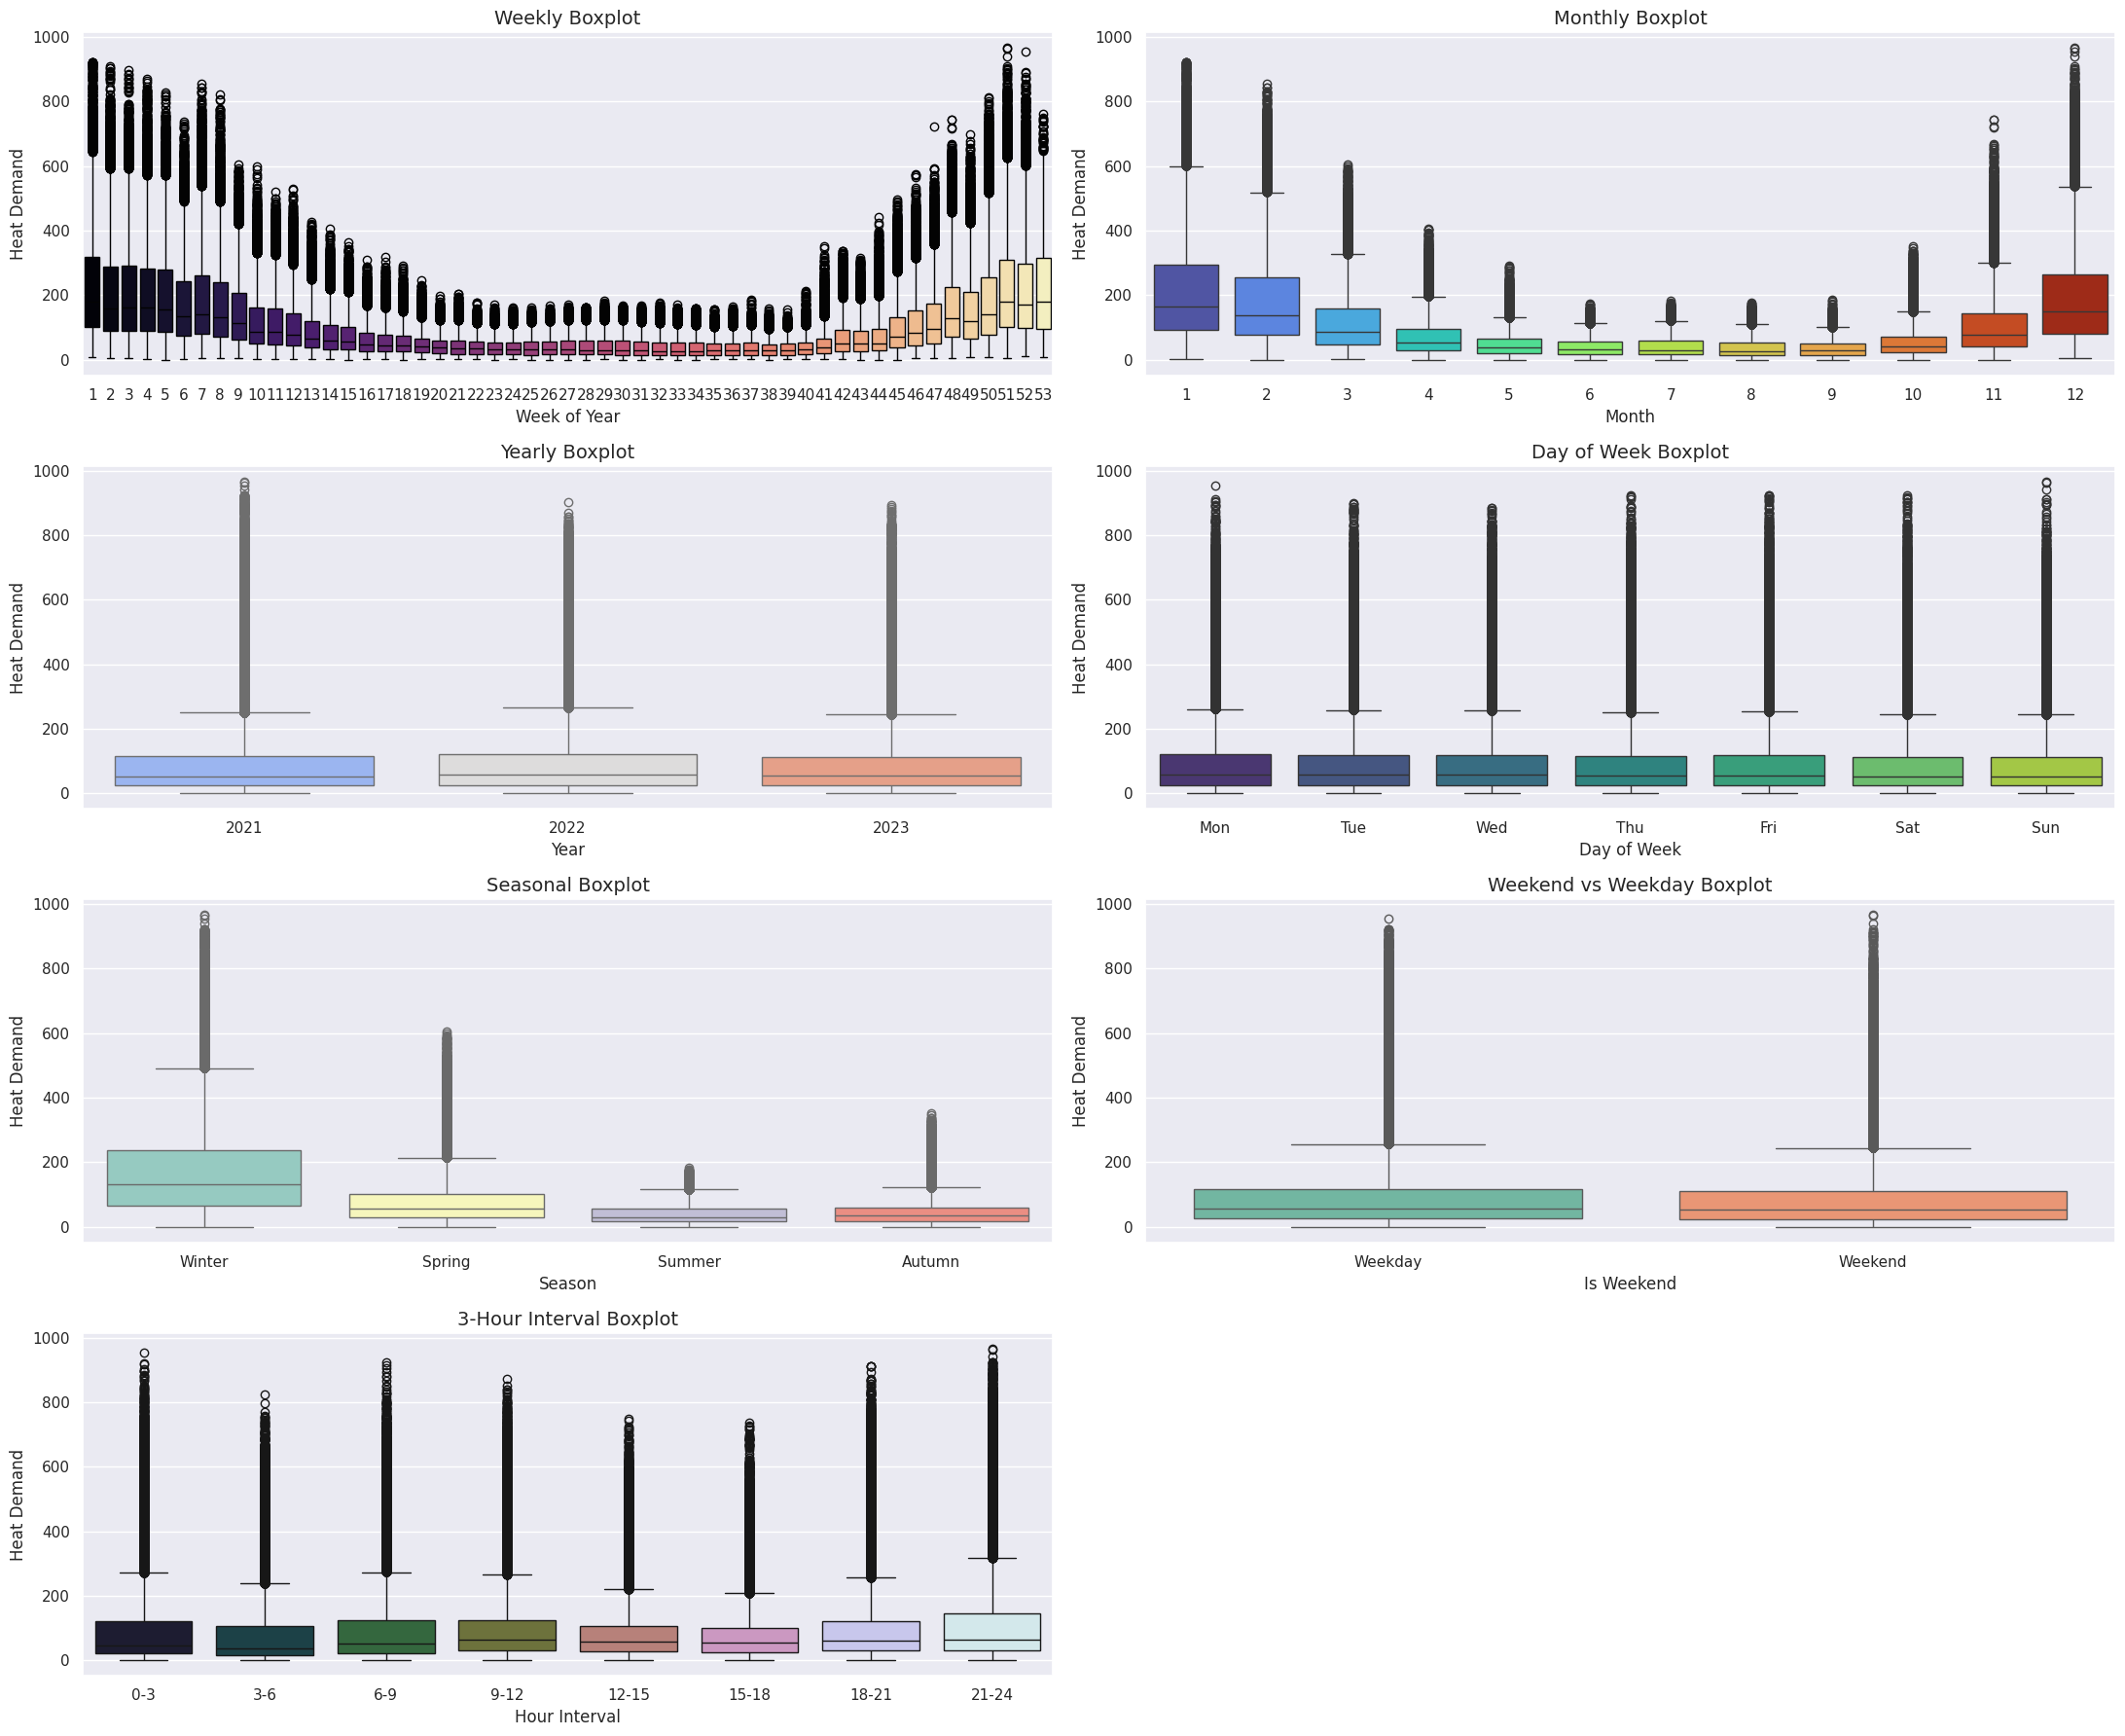

In [ ]:
# 요일 이름 매핑
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# 플롯 설정
fig, axes = plt.subplots(4, 2, figsize=(22, 18))
plt.subplots_adjust(hspace=0.4, wspace=0.2)

# 1. 주별
sns.boxplot(x='weekofyear', y='heat_demand', data=df_train, ax=axes[0,0], palette='magma')
axes[0,0].set_title('Weekly Boxplot', fontsize=14)
axes[0,0].set_xlabel('Week of Year')
axes[0,0].set_ylabel('Heat Demand')

# 2. 월별
sns.boxplot(x='month', y='heat_demand', data=df_train, ax=axes[0,1], palette='turbo')
axes[0,1].set_title('Monthly Boxplot', fontsize=14)
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Heat Demand')

# 3. 연도별
sns.boxplot(x='year', y='heat_demand', data=df_train, ax=axes[1,0], palette='coolwarm')
axes[1,0].set_title('Yearly Boxplot', fontsize=14)
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Heat Demand')

# 4. 요일별
sns.boxplot(x='day_of_week', y='heat_demand', data=df_train, ax=axes[1,1], palette='viridis')
axes[1,1].set_title('Day of Week Boxplot', fontsize=14)
axes[1,1].set_xlabel('Day of Week')
axes[1,1].set_ylabel('Heat Demand')
axes[1,1].set_xticklabels(weekday_labels)

# 5. 계절별
sns.boxplot(x='season', y='heat_demand', data=df_train, ax=axes[2,0], palette='Set3')
axes[2,0].set_title('Seasonal Boxplot', fontsize=14)
axes[2,0].set_xlabel('Season')
axes[2,0].set_ylabel('Heat Demand')

# 6. 주말여부
sns.boxplot(x='is_weekend', y='heat_demand', data=df_train, ax=axes[2,1], palette='Set2')
axes[2,1].set_title('Weekend vs Weekday Boxplot', fontsize=14)
axes[2,1].set_xlabel('Is Weekend')
axes[2,1].set_ylabel('Heat Demand')

# 7. 하루를 3시간 단위로 나눈 박스플롯
sns.boxplot(x='hour_group', y='heat_demand', data=df_train, ax=axes[3,0], palette='cubehelix')
axes[3,0].set_title('3-Hour Interval Boxplot', fontsize=14)
axes[3,0].set_xlabel('Hour Interval')
axes[3,0].set_ylabel('Heat Demand')
axes[3,0].set_xticklabels(hour_labels)

axes[3,1].axis('off')  # 일단 비워둠

plt.tight_layout()
plt.show()



> Monthly : 1,2,12월에 열수요가 매우 높고 분산도 큼 (한파 등의 영향일 수도), 6,7,8월에는 열수요가 거의 없음

> Yearly,Day of week, 주말 여부 : 뚜렷한 차이 없음

> Seasonal : 겨울은 수요 중앙값이 크고 변동성도 큼. Monthly와 비슷한 경향

> 3시간 단위 : 9-12가 가장 높음


* 계절별 시간대별 (3시간 간격) Boxplot

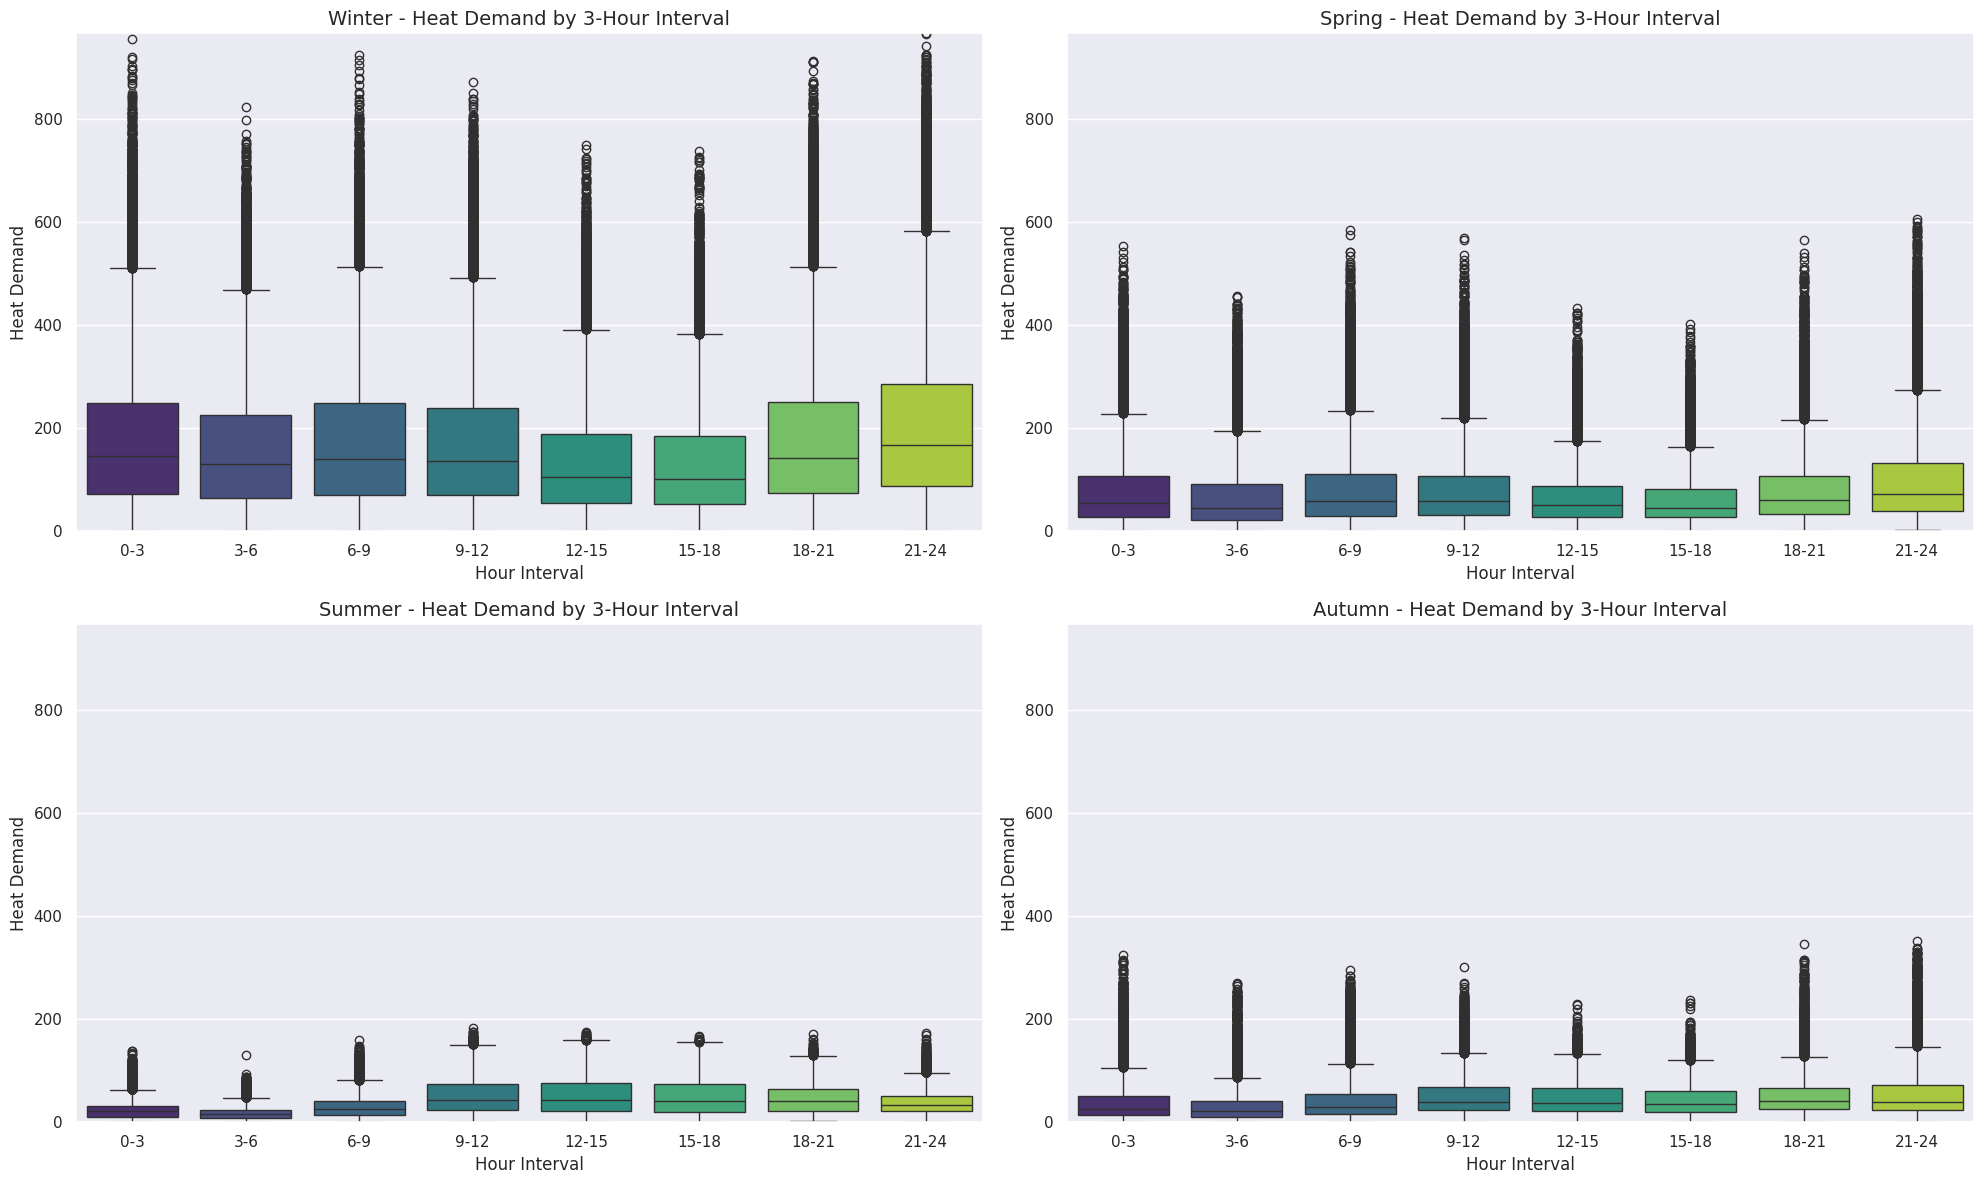

In [ ]:
# 3시간 단위 시간 그룹 레이블
hour_labels = ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']
df_train['hour_group'] = (df_train['tm'].dt.hour // 3).astype(int)

# 계절 순서 고정
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']

# 공통 y축 범위 지정
y_min = 0
y_max = df_train['heat_demand'].max()

# 시각화
plt.figure(figsize=(20, 12))
for i, season in enumerate(season_order):
    plt.subplot(2, 2, i+1)
    subset = df_train[df_train['season'] == season]
    sns.boxplot(x='hour_group', y='heat_demand', data=subset, palette='viridis')
    plt.title(f'{season} - Heat Demand by 3-Hour Interval', fontsize=14)
    plt.xlabel('Hour Interval')
    plt.ylabel('Heat Demand')
    plt.xticks(ticks=range(8), labels=hour_labels)
    plt.ylim(y_min, y_max)  # Y축 고정

plt.tight_layout()
plt.show()


> winter: 전 시간대에서 열수요가 높고, 특히 18-21, 21-24시에 가장 높은 것으로 보임. 이는 일반적인 주거 지역 위주의 지사라면 자연스러움(대부분의 가구는 저녁에 집에 있고, 이때 난방을 집중적으로 사용하니까)

> spring : 아침 시간대(6-9, 9-12), 그리고 밤(18-21, 21-24)에 높음

> **summer** : 이상하게 낮 시간대의 수요가 더 높음. 가능한 해석은 산업/상업 부문에서의 수요일 가능성이 있다. 여름에는 일반 건물에서의 열수요가 적기 때문에, 일부 산업체에서 사용하는 공정상 난방/증기 사용이 더 크게 느껴지는 것일 수도 있음(보통 낮에 가동되는 공장이 더 많으니 이때 난방 보일러나 열교환기를 쓸수도?). 아니면 냉방 보조 시스템으로서 열수요 일수도(흡수식 냉방기는 여름철 냉방을 위해 열을 소비한다고 함 -> 낮에 냉방 피크니까 열수요 증가?) 라고 지피티 선생님께서 조언 주셨습니다.

> autumn : 전반적으로 비슷하지만, 밤의 수요가 좀 더 높음

In [ ]:
# 1. 여름 + 낮 시간대 필터링
summer_daytime = df_train[
    (df_train['month'].isin([6, 7, 8])) &  # 여름
    (df_train['tm'].dt.hour >= 9) &
    (df_train['tm'].dt.hour < 18)
]

# 2. 이상치 기준 설정
q1 = summer_daytime['heat_demand'].quantile(0.25)
q3 = summer_daytime['heat_demand'].quantile(0.75)
iqr = q3 - q1
outlier_threshold = q3 + 1.5 * iqr  # upper bound

# 3. 이상치 추출
summer_outliers = summer_daytime[summer_daytime['heat_demand'] > outlier_threshold]

# 4. 결과 확인: 이상치가 발생한 날짜 및 열수요 상위 값
summer_outliers_sorted = summer_outliers.sort_values(by='heat_demand', ascending=False)
summer_outliers_sorted

tm branch_id    ta     wd   ws  rn_day  rn_hr1    hm  \
57341  2021-07-19 10:00:00         C  29.7  225.4  1.9     0.0     0.0  65.0   
57343  2021-07-19 12:00:00         C  31.2   66.7  1.8     0.0     0.0  59.1   
127864 2023-08-07 10:00:00         E  31.3  135.1  0.5     0.0     0.0  59.3   
74886  2023-07-20 11:00:00         C  31.2  357.3  0.8     0.0     0.0  61.4   
127865 2023-08-07 11:00:00         E  34.1   85.8  0.7     0.0     0.0  55.7   
...                    ...       ...   ...    ...  ...     ...     ...   ...   
110158 2021-07-30 11:00:00         E   NaN    NaN  NaN     NaN     NaN   NaN   
127743 2023-08-02 09:00:00         E  29.8  360.0  0.0     0.0     0.0  68.0   
119464 2022-08-22 10:00:00         E  30.4  144.4  2.1     0.0     0.0  68.5   
119321 2022-08-16 11:00:00         E  29.6  270.2  1.1     0.0     0.0  62.5   
127893 2023-08-08 15:00:00         E   NaN    NaN  NaN     NaN     NaN   NaN   

          si  ta_chi  heat_demand  year  quarter  month  day_of_week  season  \
57341   1.89    30.6        182.0  2021        3      7            0  Summer   
57343   1.09    31.7        176.0  2021        3      7            0  Summer   
127864  2.27    33.8        176.0  2023        3      8            0  Summer   
74886   2.60    31.4        175.0  2023        3      7            3  Summer   
127865  2.56    35.2        175.0  2023        3      8            0  Summer   
...      ...     ...          ...   ...      ...    ...          ...     ...   
110158  2.79    33.2        155.0  2021        3      7            4  Summer   
127743  1.49    32.0        155.0  2023        3      8            2  Summer   
119464  1.01    30.9        155.0  2022        3      8            0  Summer   
119321  2.57    30.1        155.0  2022        3      8            1  Summer   
127893  2.41    36.4        155.0  2023        3      8            1  Summer   

       is_weekend  weekofyear  log_heat_demand  hour_group  
57341     Weekday          29         5.209486           3  
57343     Weekday          29         5.176150           4  
127864    Weekday          32         5.176150           3  
74886     Weekday          29         5.170484           3  
127865    Weekday          32         5.170484           3  
...           ...         ...              ...         ...  
110158    Weekday          30         5.049856           3  
127743    Weekday          31         5.049856           3  
119464    Weekday          34         5.049856           3  
119321    Weekday          33         5.049856           3  
127893    Weekday          32         5.049856           5  

[166 rows x 20 columns]

In [ ]:
summer_outliers_sorted['branch_id'].value_counts()

branch_id
C    117
E     49
Name: count, dtype: int64



> 여름 낮 시간대에 수요가 높아지는게 branch 차이일수도?



* 브랜치별로 3시간 단위 파악

In [ ]:
branches

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S'], dtype=object)

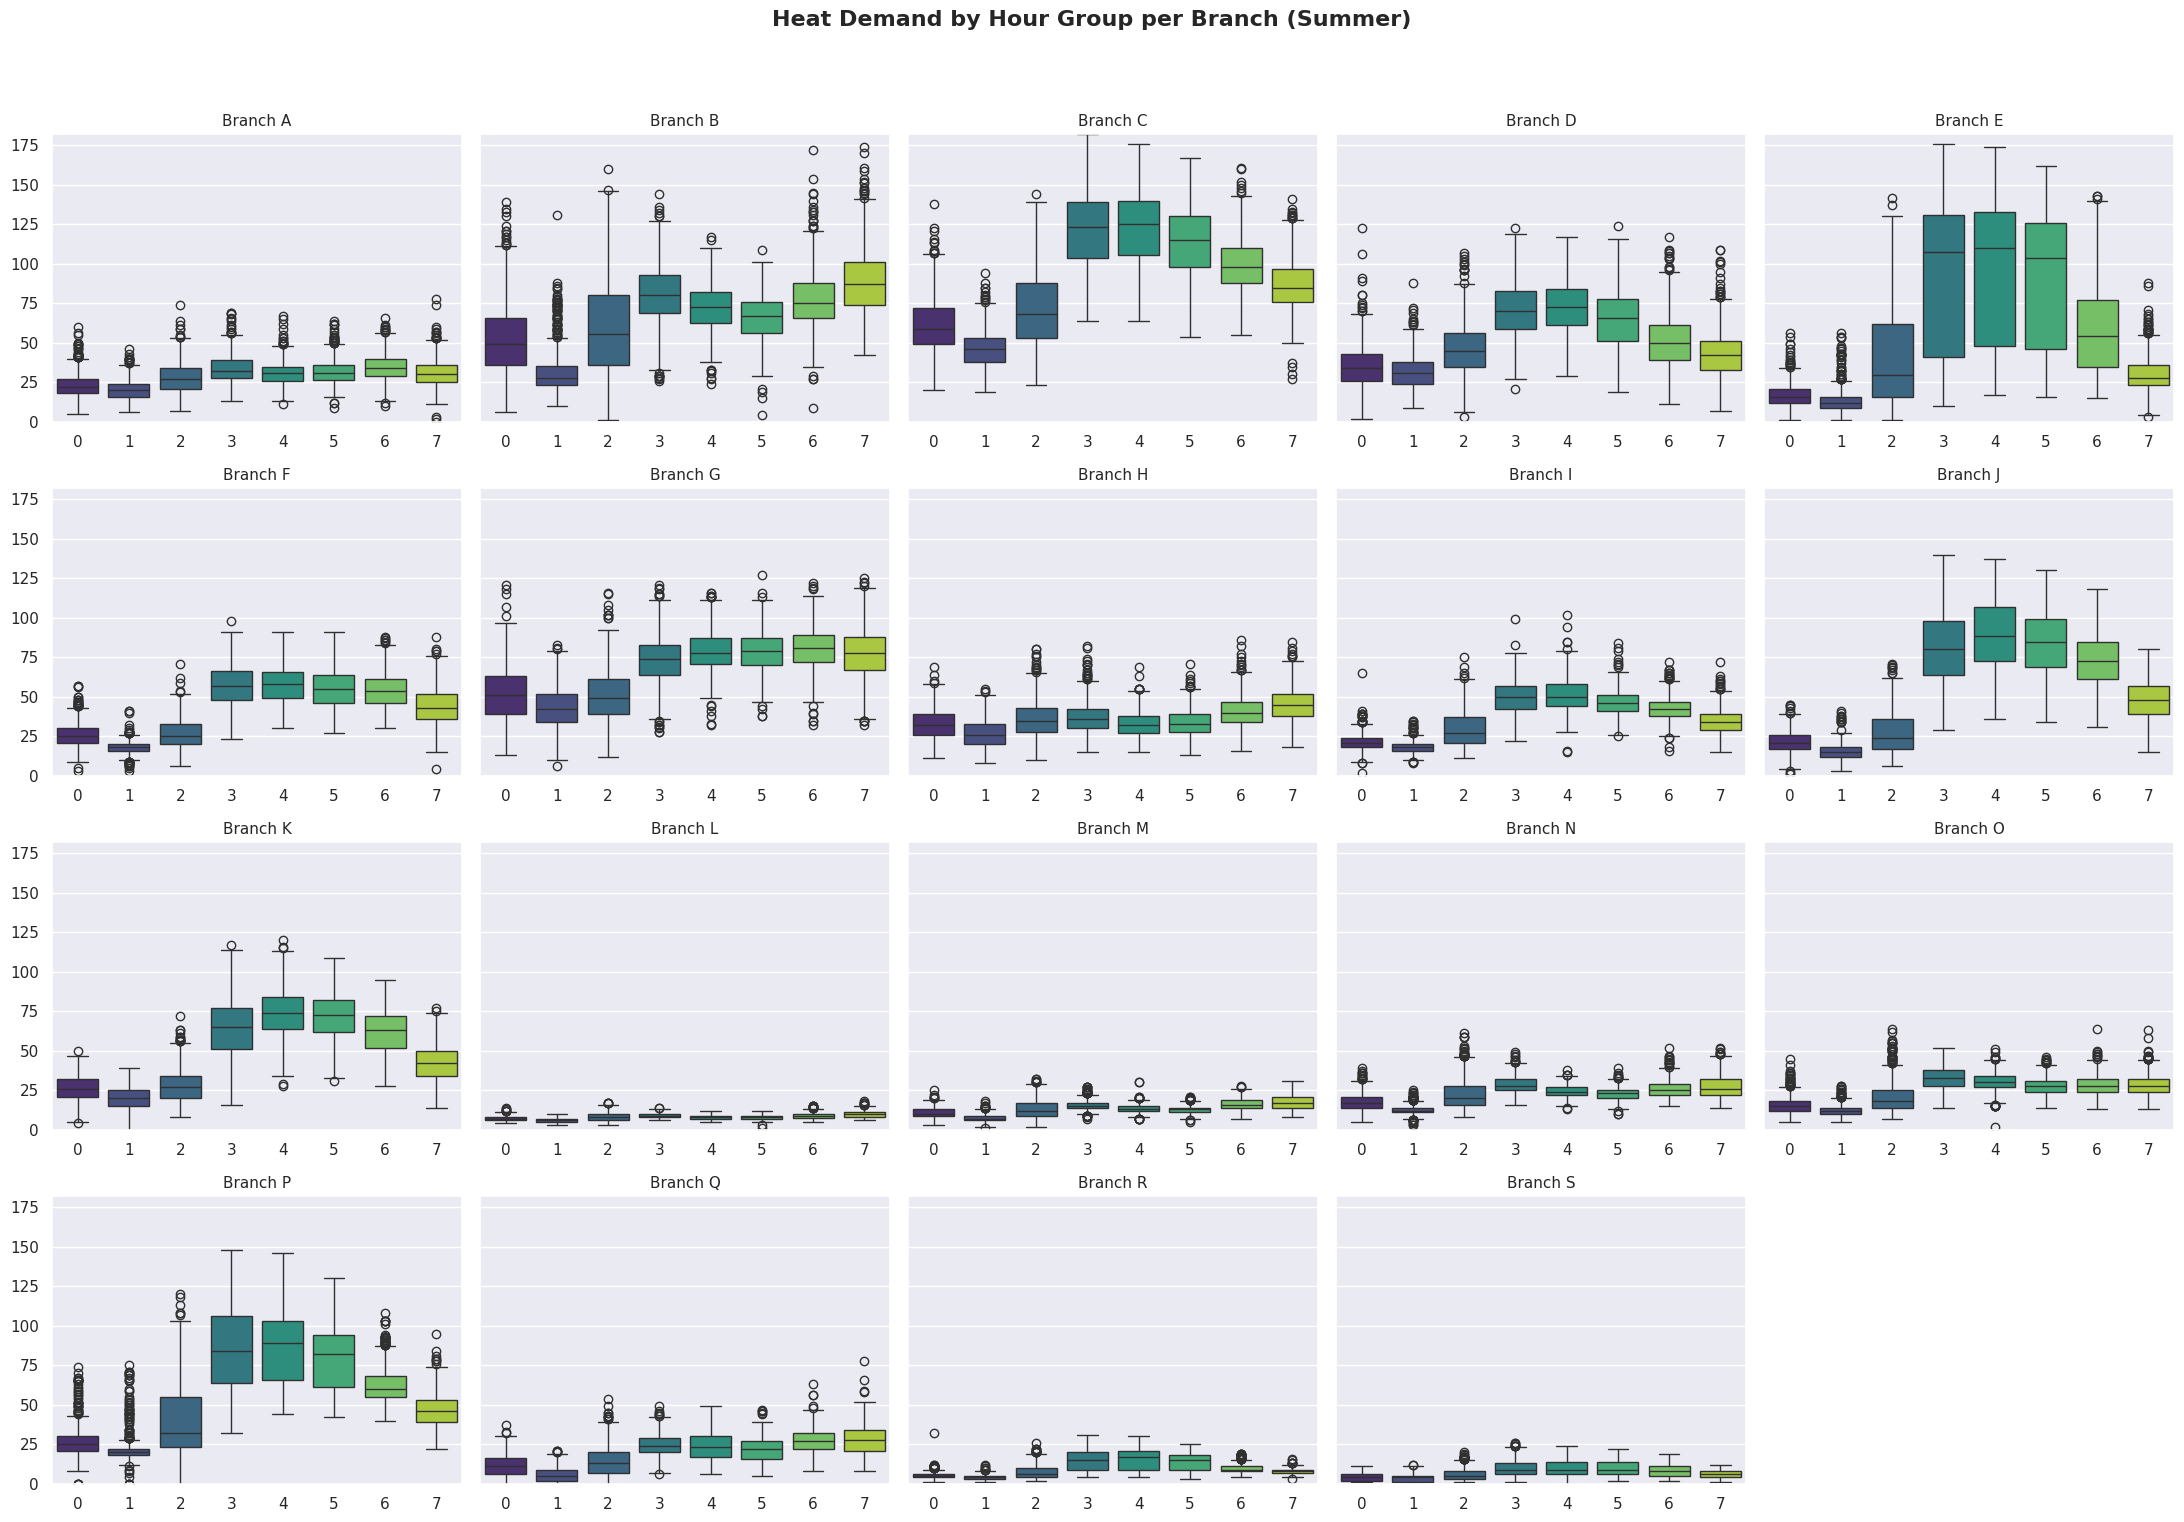

In [ ]:
# 여름철 데이터 필터링
summer_df = df_train[df_train['month'].isin([6, 7, 8])]

# 브랜치 정렬
branches = sorted(summer_df['branch_id'].unique())
n_branches = len(branches)

# 공통 y축 범위 설정 (예: 전체 여름 데이터 기준 0 ~ 200으로)
y_min = summer_df['heat_demand'].min()
y_max = summer_df['heat_demand'].max()

# subplot 설정
n_rows, n_cols = 4, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 16), sharey=True)  # sharey로 Y축 일치
axes = axes.flatten()

# 각 지점에 대해 boxplot 그리기
for i, branch in enumerate(branches):
    ax = axes[i]
    branch_df = summer_df[summer_df['branch_id'] == branch]
    sns.boxplot(data=branch_df, x='hour_group', y='heat_demand', ax=ax, palette='viridis')
    ax.set_title(f'Branch {branch}', fontsize=11)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(y_min, y_max)  # 모든 서브플롯에 동일한 y축 설정

# 남는 subplot은 비활성화
for j in range(len(branches), len(axes)):
    fig.delaxes(axes[j])

# 전체 레이아웃 조정
plt.suptitle('Heat Demand by Hour Group per Branch (Summer)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



> C, E, J : 여름 낮 시간대 에 눈에 띄는 높은 열수요가 존재. 공장, 산업체, 흡수식 냉방기 사용 등이 집중된 지사일 가능성 큼. 특히 Branch C는 9~15시에 열수요가 가장 집중되어 있음 → 산업체/설비 중심?

> B, D, K : 여름임에도 불구하고 전반적인 시간대에서 꾸준한 열수요가 존재. 상업시설(예: 병원, 대형마트, 백화점 등)이 포함된 지사일 가능성. 또는 일부 상시 난방/온수 공급이 필요한 지역 포함 가능성 있음.

> 나머지 : 열수요는 존재하지만, 전반적으로 낮은 편. 일반적인 주거 밀집형 지역일 가능성이 높고, 여름철에는 난방보다는 온수 수요 정도로 해석될 수 있음.


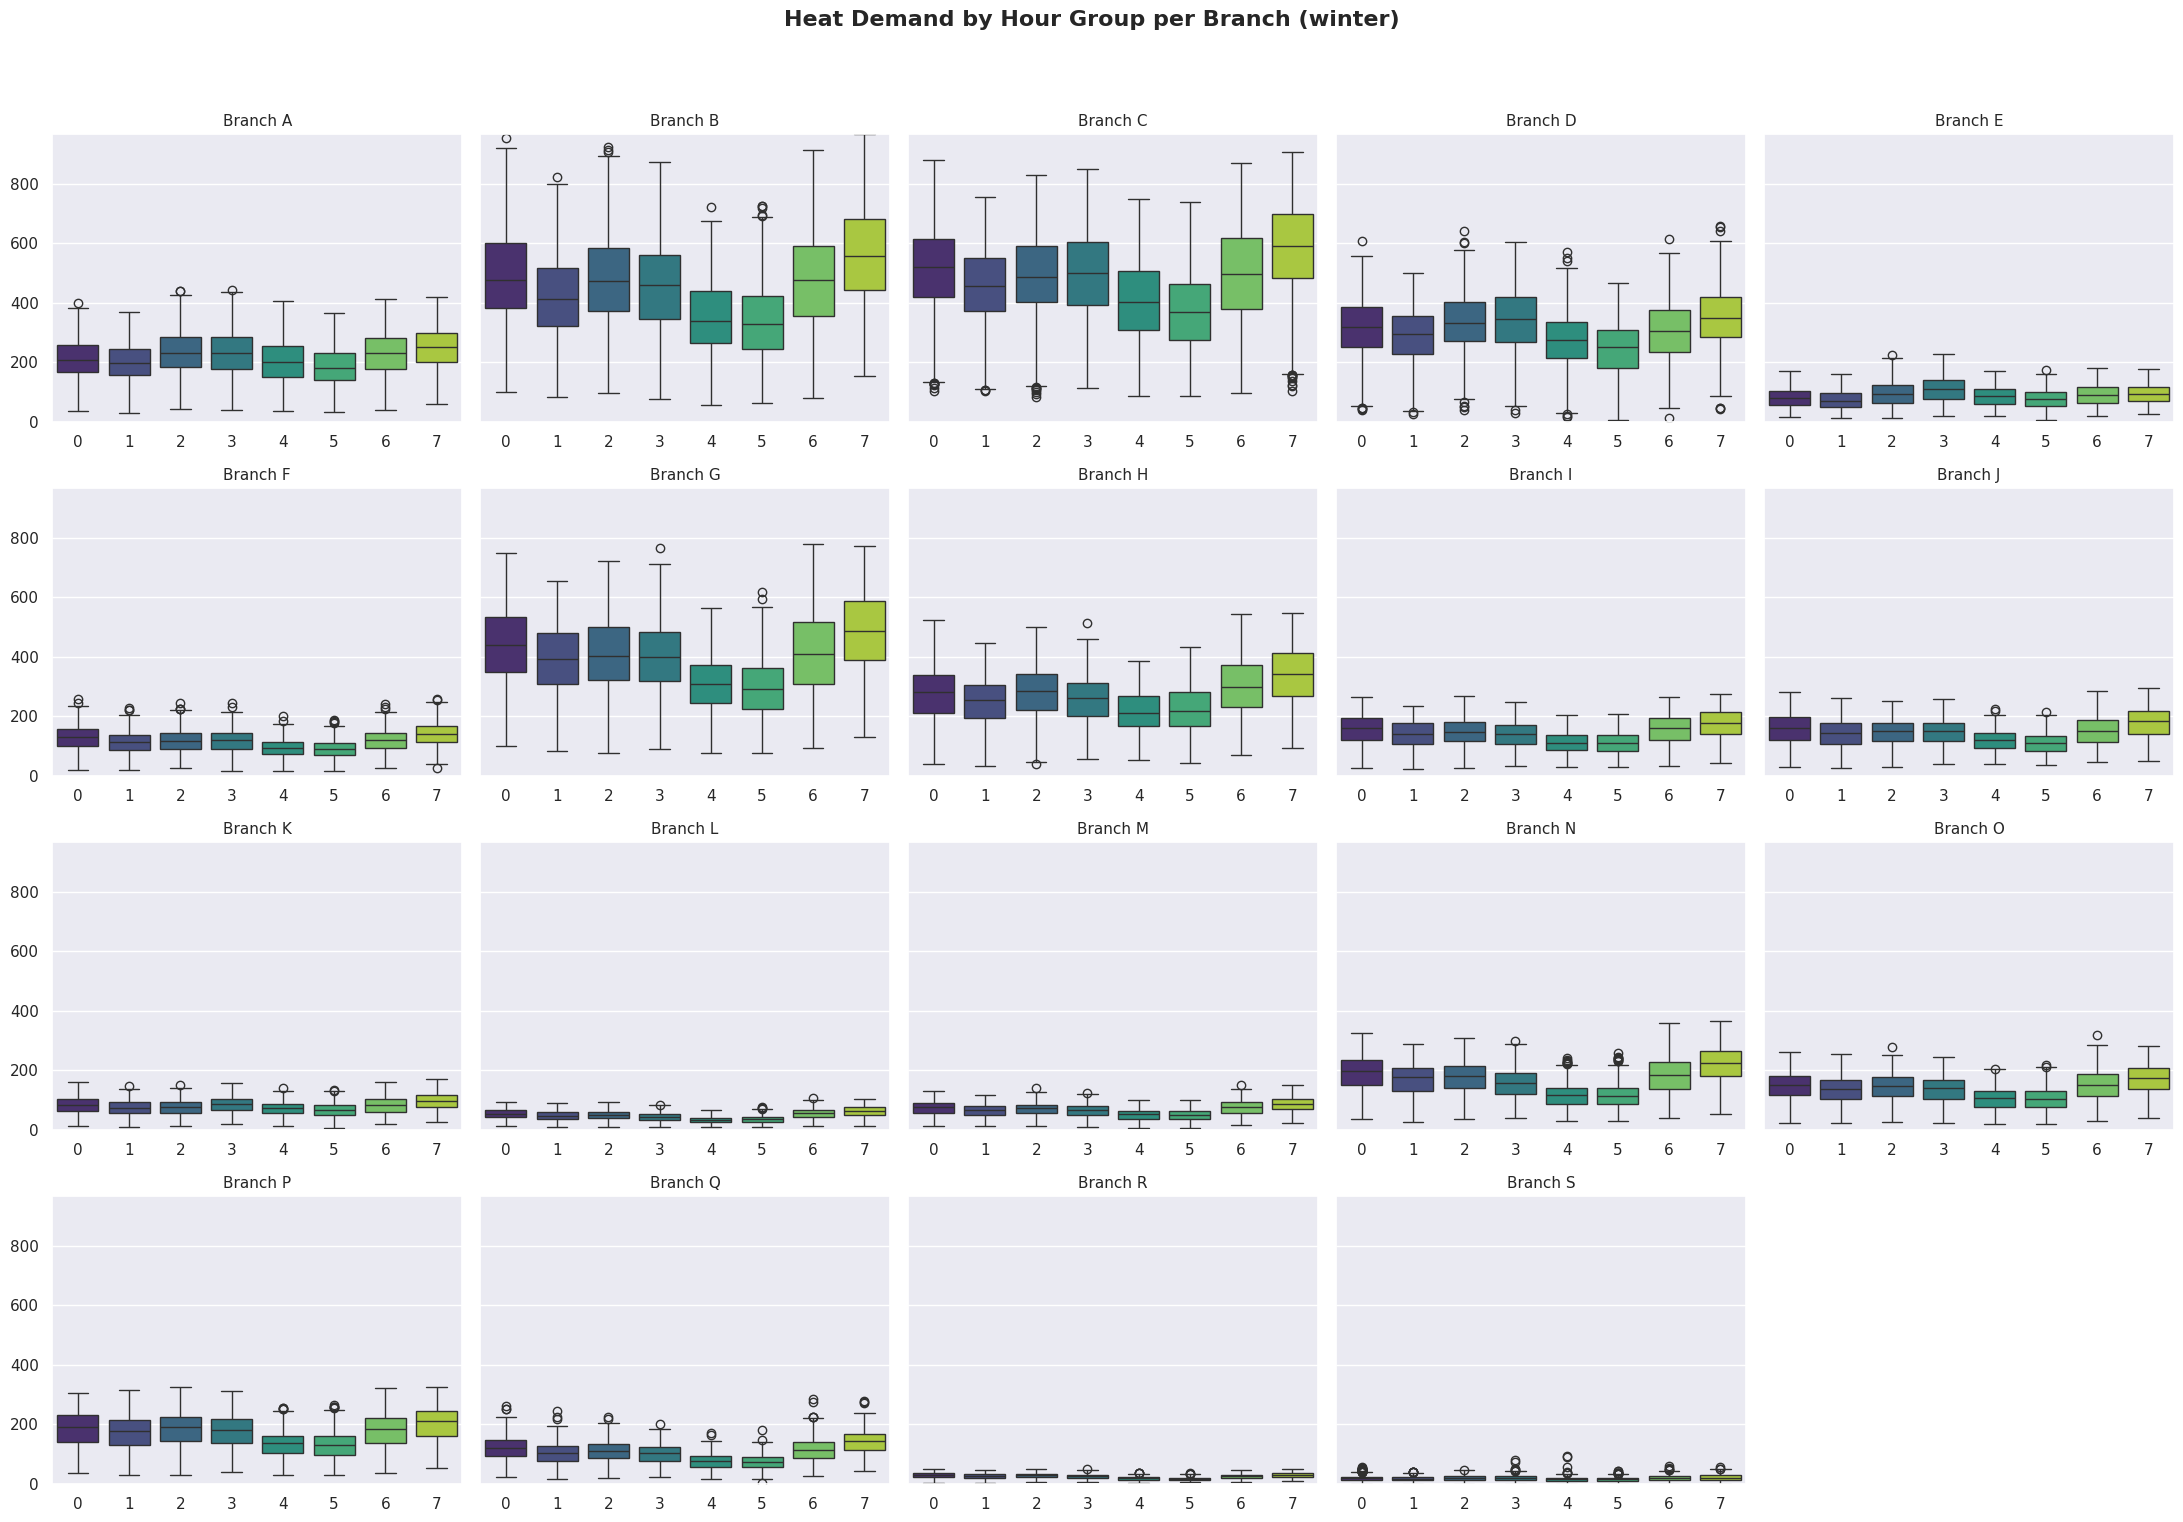

In [ ]:
# 겨울철 데이터 필터링
winter_df = df_train[df_train['month'].isin([11,12,1,2])]

# 브랜치 정렬
branches = sorted(winter_df['branch_id'].unique())
n_branches = len(branches)

# 공통 y축 범위 설정 (예: 전체 여름 데이터 기준 0 ~ 200으로)
y_min = winter_df['heat_demand'].min()
y_max = winter_df['heat_demand'].max()

# subplot 설정
n_rows, n_cols = 4, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 16), sharey=True)  # sharey로 Y축 일치
axes = axes.flatten()

# 각 지점에 대해 boxplot 그리기
for i, branch in enumerate(branches):
    ax = axes[i]
    branch_df = winter_df[winter_df['branch_id'] == branch]
    sns.boxplot(data=branch_df, x='hour_group', y='heat_demand', ax=ax, palette='viridis')
    ax.set_title(f'Branch {branch}', fontsize=11)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(y_min, y_max)  # 모든 서브플롯에 동일한 y축 설정

# 남는 subplot은 비활성화
for j in range(len(branches), len(axes)):
    fig.delaxes(axes[j])

# 전체 레이아웃 조정
plt.suptitle('Heat Demand by Hour Group per Branch (winter)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




> branch별 시간대에 따른 차이가 크지 않음. 겨울철에는 열수요가 모든 시간대에 있으며, 야간에 상대적으로 높은 경향이 모두 존재함

> 여름철과 비교했을 때 확연한 차이로 드러난다.모델링시 계절*시간대 상호작용 항을 만드는건 어떨지


**이런 브런치별 차이를 클러스터링으로 보는 방식도 좋을듯(그리고 군집의 특성과 관련된 feature를 추가..)**

[참고]

https://www.dacon.io/competitions/official/235736/codeshare/2844?page=2&dtype=recent

https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent






### **2-3) Feature 분석**


##### **(1) branch_id**

In [ ]:
df_train.groupby('branch_id')['heat_demand'].describe()

count        mean         std   min   25%    50%    75%    max
branch_id                                                                  
A          26277.0  106.935723   92.703412   0.0  32.0   63.0  175.0  443.0
B          26279.0  227.792306  191.536709   1.0  77.0  147.0  352.5  966.0
C          26279.0  248.294836  193.857982  14.0  99.0  155.0  387.0  908.0
D          26277.0  158.477338  127.236265   2.0  57.0  105.0  247.0  659.0
E          26270.0   58.333689   40.510389   0.0  26.0   45.0   87.0  227.0
F          26278.0   67.806378   42.540855   1.0  37.0   54.0   93.0  257.0
G          26279.0  205.476654  162.316447   6.0  78.0  136.0  313.0  779.0
H          26279.0  134.981468  114.004033   4.0  42.0   87.0  214.0  546.0
I          26279.0   77.364664   56.433210   2.0  36.0   53.0  112.0  275.0
J          26277.0   85.767515   54.627913   1.0  46.0   71.0  118.0  295.0
K          26278.0   52.653018   29.387538   0.0  28.0   47.0   73.0  171.0
L          26279.0   24.844857   19.912355   1.0   9.0   16.0   37.0  107.0
M          26278.0   36.321410   27.783214   1.0  15.0   25.0   55.0  152.0
N          26279.0   84.274820   72.145200   3.0  27.0   53.0  129.0  365.0
O          26278.0   71.502816   57.704600   2.0  27.0   45.0  109.0  317.0
P          26279.0   98.550211   65.794263   0.0  50.0   77.0  138.0  326.0
Q          26279.0   55.578294   45.094550   0.0  22.0   37.0   83.0  286.0
R          26279.0   15.248792    9.650868   0.0   8.0   12.0   21.0   51.0
S          26275.0   11.315509    8.077017   0.0   5.0    9.0   15.0   93.0

* 지사별 열수요 분포

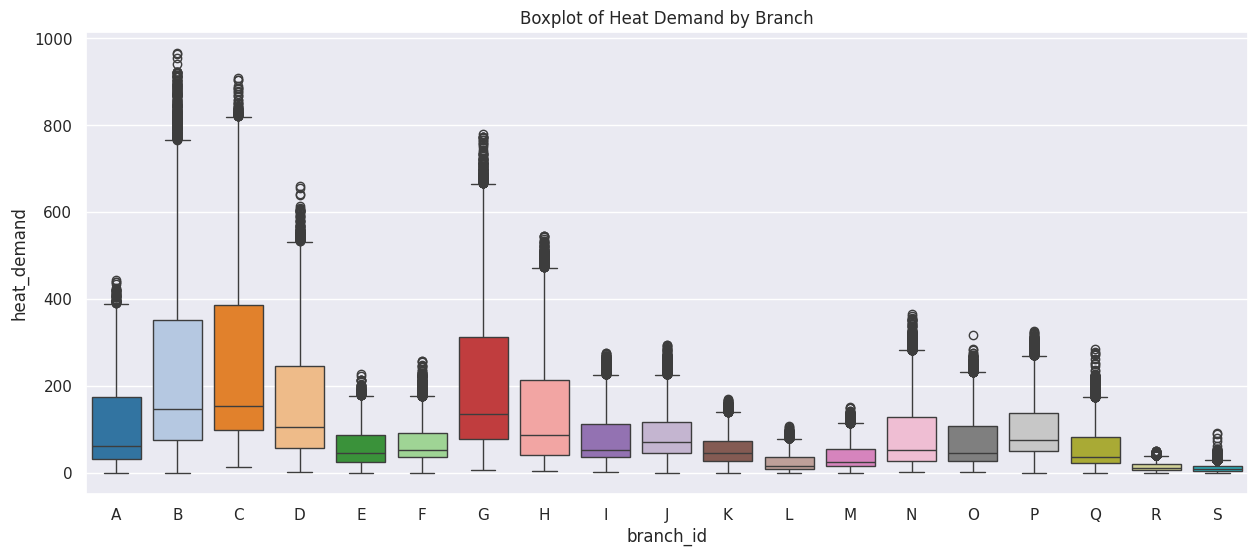

In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(x='branch_id', y='heat_demand', data=df_train, palette='tab20')
plt.title('Boxplot of Heat Demand by Branch')
plt.show()


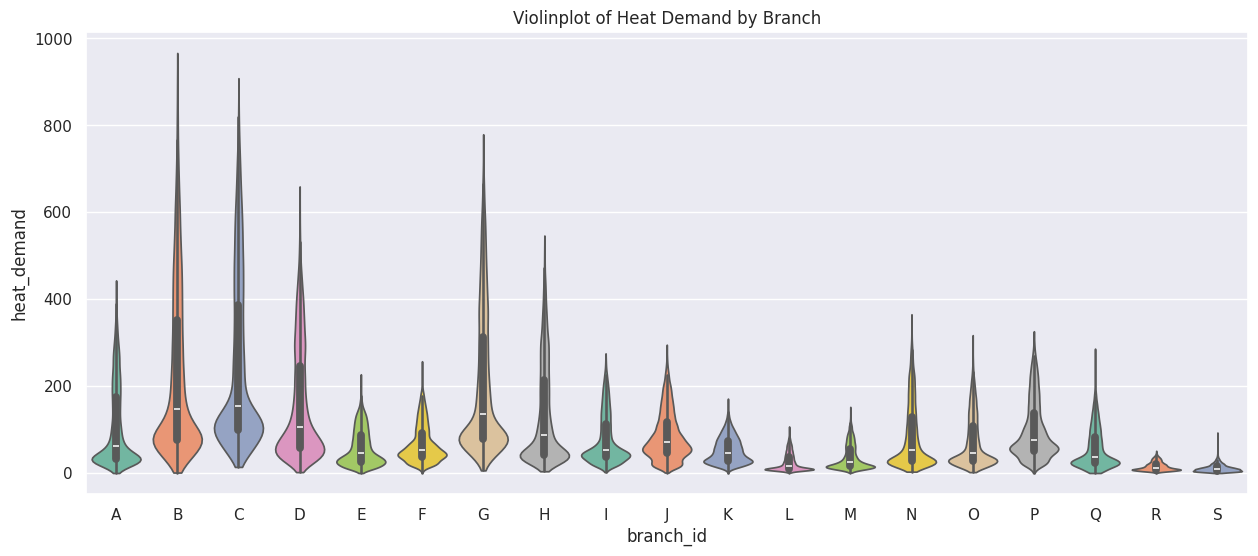

In [ ]:
plt.figure(figsize=(15,6))
sns.violinplot(x='branch_id', y='heat_demand', data=df_train, palette='Set2', cut=0)
plt.title('Violinplot of Heat Demand by Branch')
plt.show()

* 브랜치별 시간에 따른 평균 열수요

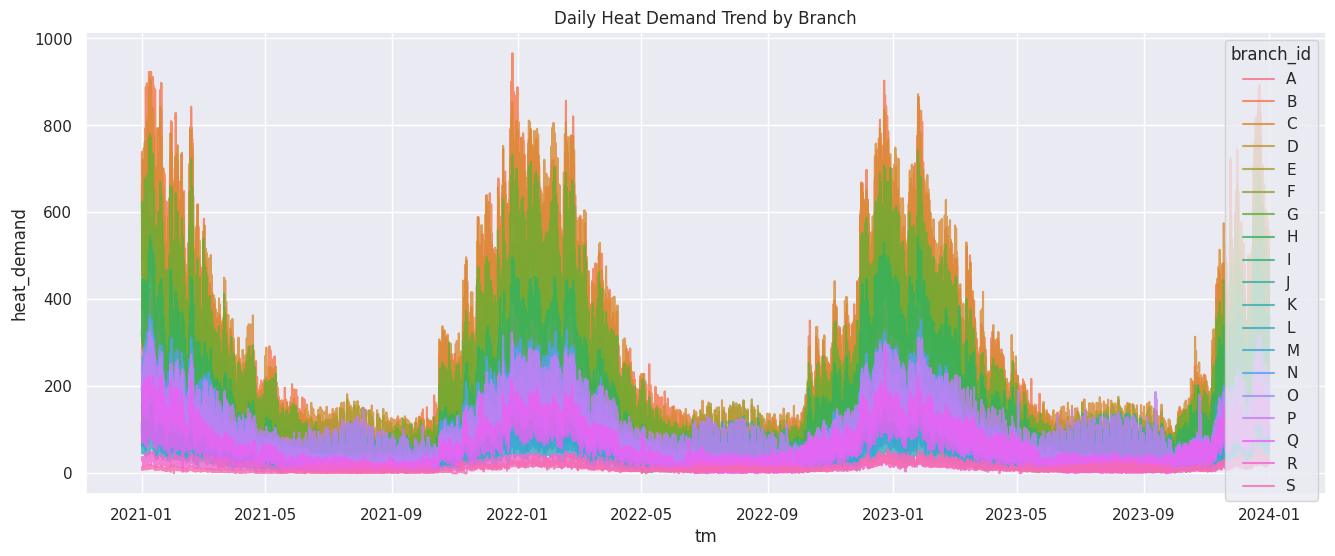

In [ ]:
daily_branch_avg = df_train.groupby(['tm', 'branch_id'])['heat_demand'].mean().reset_index()
plt.figure(figsize=(16,6))
sns.lineplot(data=daily_branch_avg, x='tm', y='heat_demand', hue='branch_id', alpha=0.8)
plt.title('Daily Heat Demand Trend by Branch')
plt.show()

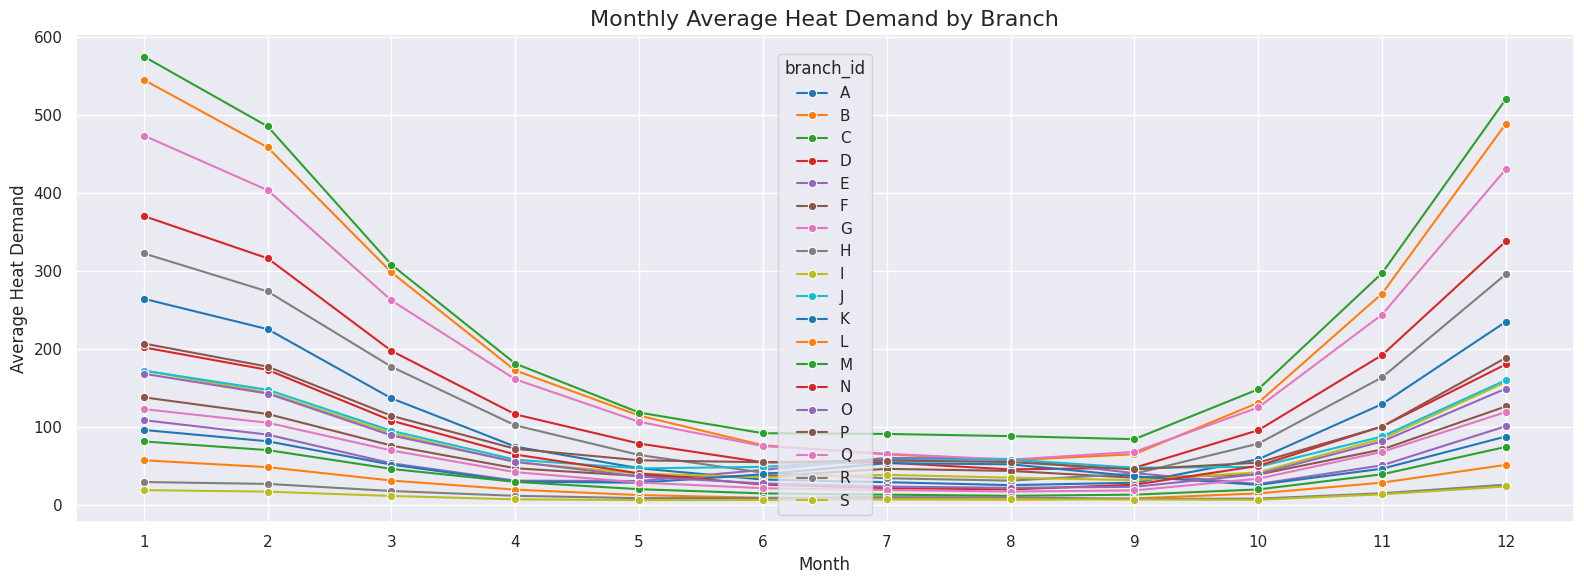

In [ ]:
# 월별 평균 열수요 계산
monthly_branch_avg = df_train.groupby(['month', 'branch_id'])['heat_demand'].mean().reset_index()

# 시각화
plt.figure(figsize=(16, 6))
sns.lineplot(data=monthly_branch_avg, x='month', y='heat_demand', hue='branch_id', marker='o', palette='tab10')
plt.title('Monthly Average Heat Demand by Branch', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Average Heat Demand')
plt.xticks(ticks=range(1, 13))  # 1~12월 표시
plt.grid(True)
plt.tight_layout()
plt.show()


* 브랜치별 열수요 상관관계 heatmap

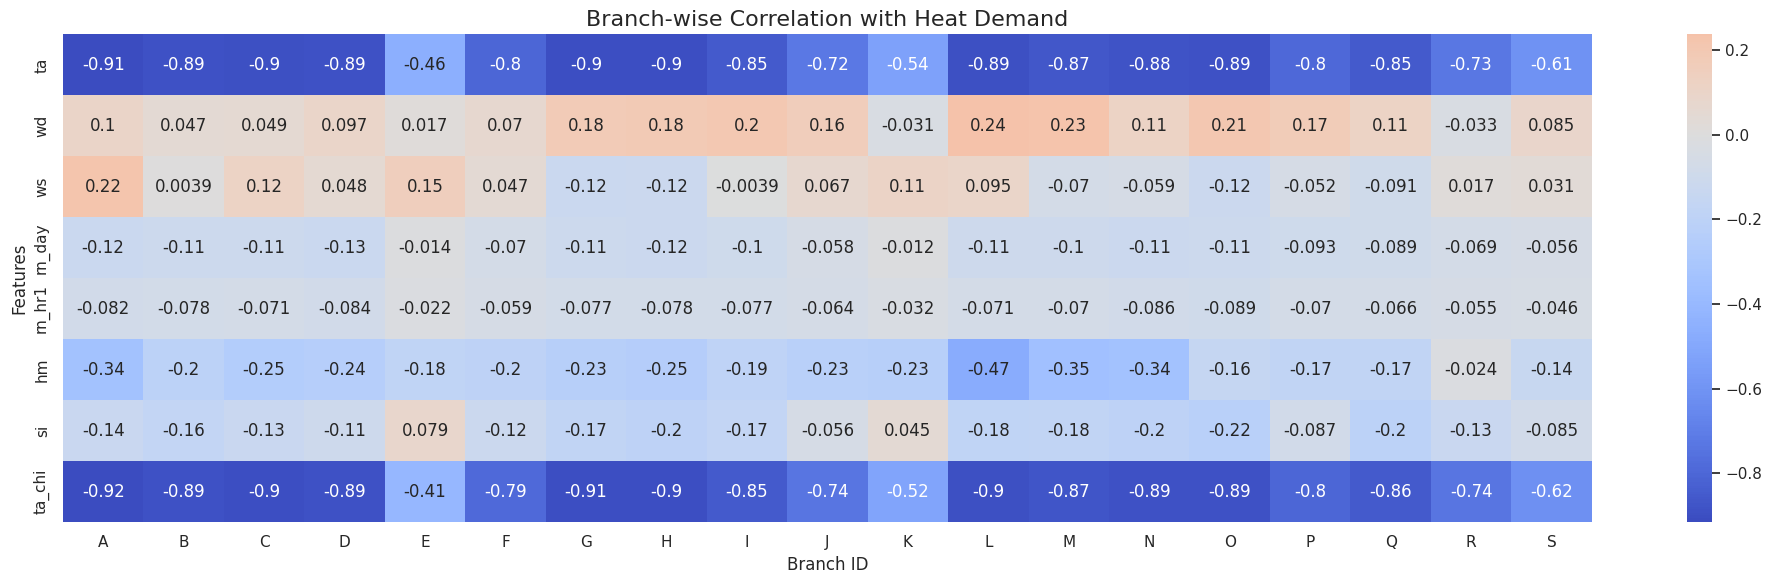

In [ ]:
numeric_features = ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi']

corr_list = []
branch_ids = df_train['branch_id'].unique()

for b in branch_ids:
    df_branch = df_train[df_train['branch_id'] == b]
    corr = df_branch[numeric_features + ['heat_demand']].corr()['heat_demand'].drop('heat_demand')
    corr_list.append(corr)

# 데이터프레임 형태로 변환
corr_df = pd.concat(corr_list, axis=1)
corr_df.columns = branch_ids

# 시각화
plt.figure(figsize=(20, 6))
sns.heatmap(corr_df, cmap='coolwarm', center=0, annot=True)
plt.title('Branch-wise Correlation with Heat Demand', fontsize=16)
plt.xlabel('Branch ID')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

* 시간 (3시간 단위) x 지사별 열수요

Text(0.5, 0.98, 'Heat Demand by Hour Group per Branch')

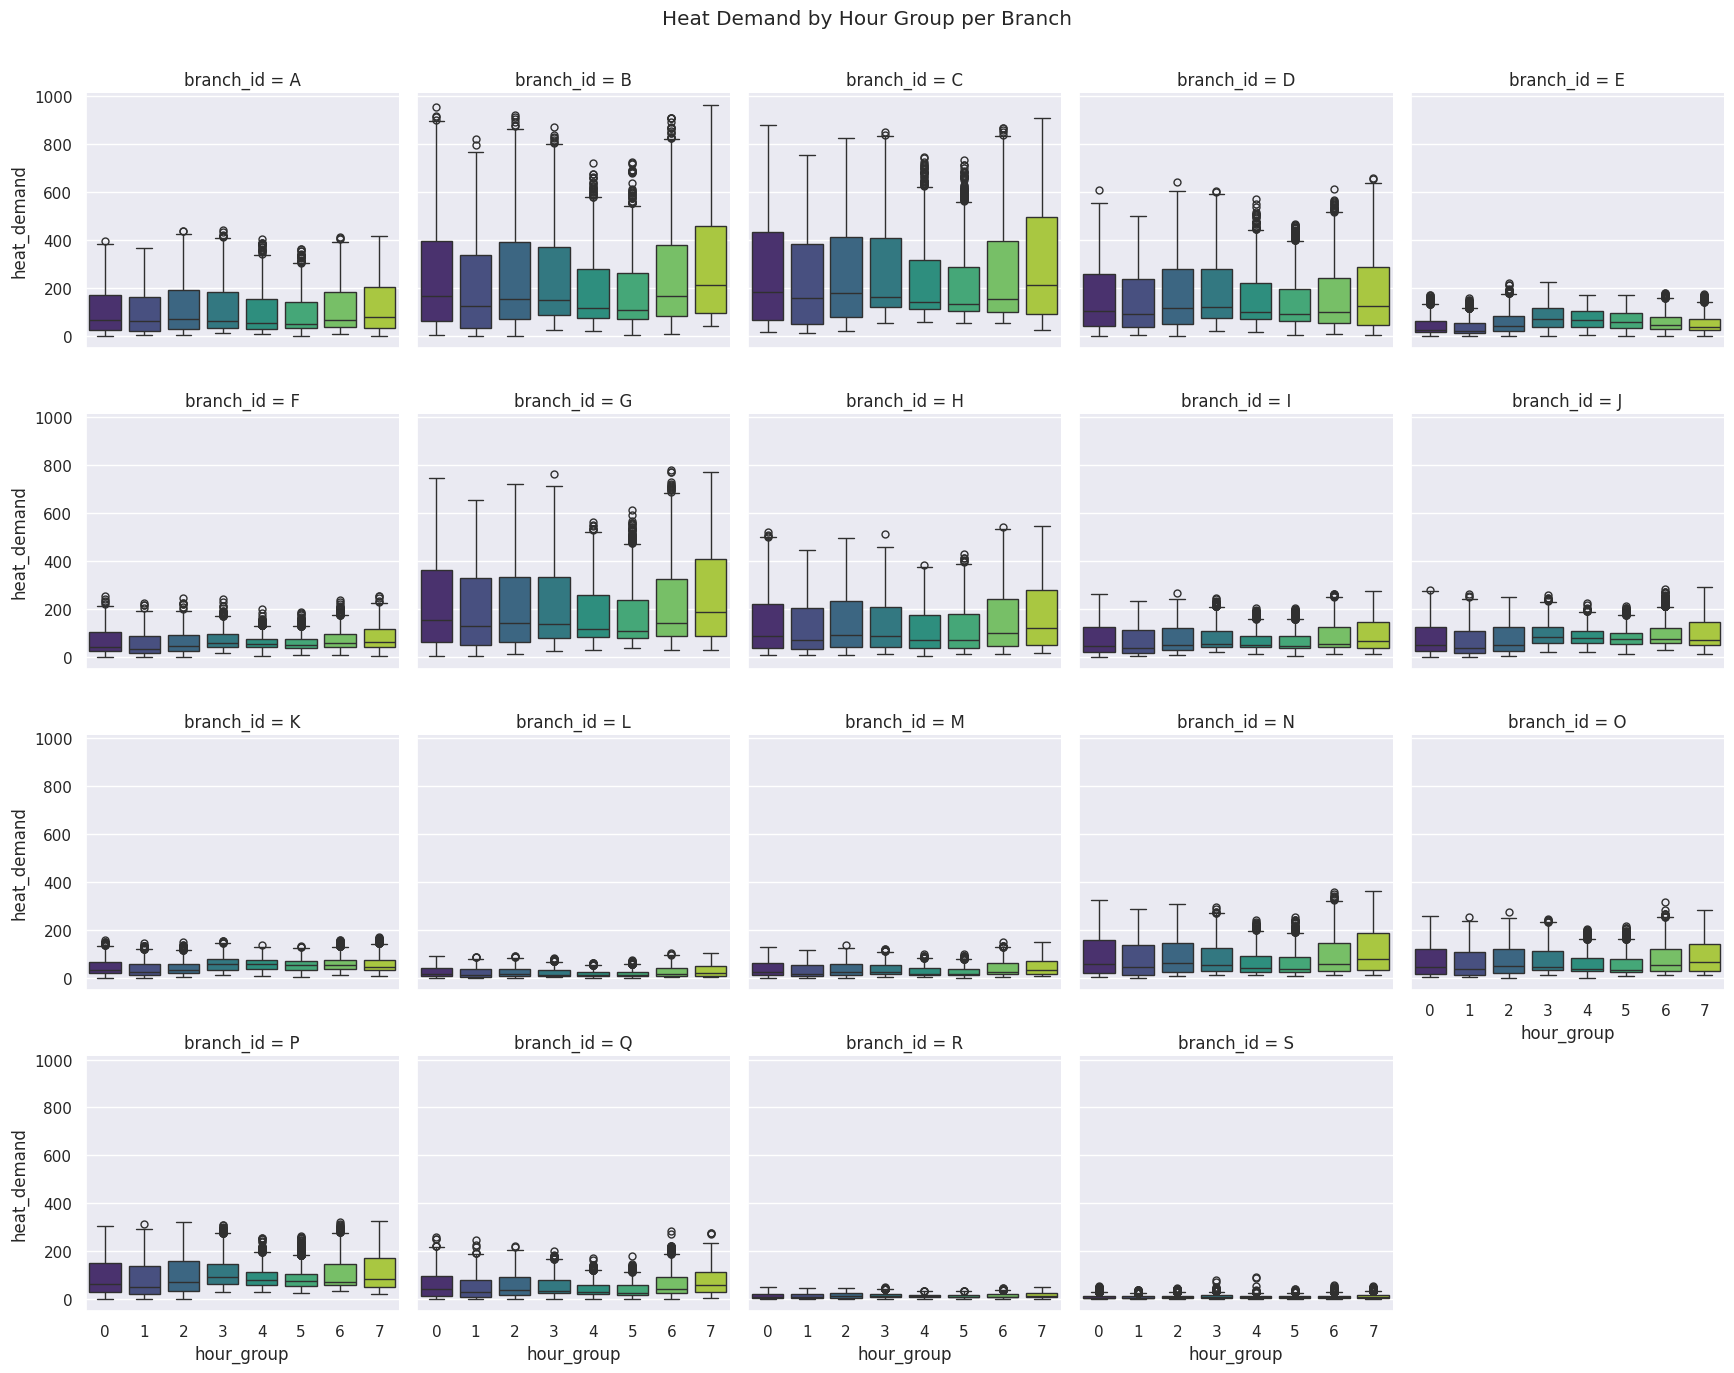

In [ ]:
g = sns.catplot(
    data=df_train, kind='box',
    x='hour_group', y='heat_demand', col='branch_id',
    col_wrap=5, height=3.5, aspect=1,
    palette='viridis'
)
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Heat Demand by Hour Group per Branch')


* 계절 x 지사별 열수요

Text(0.5, 0.98, 'Heat Demand by Season per Branch')

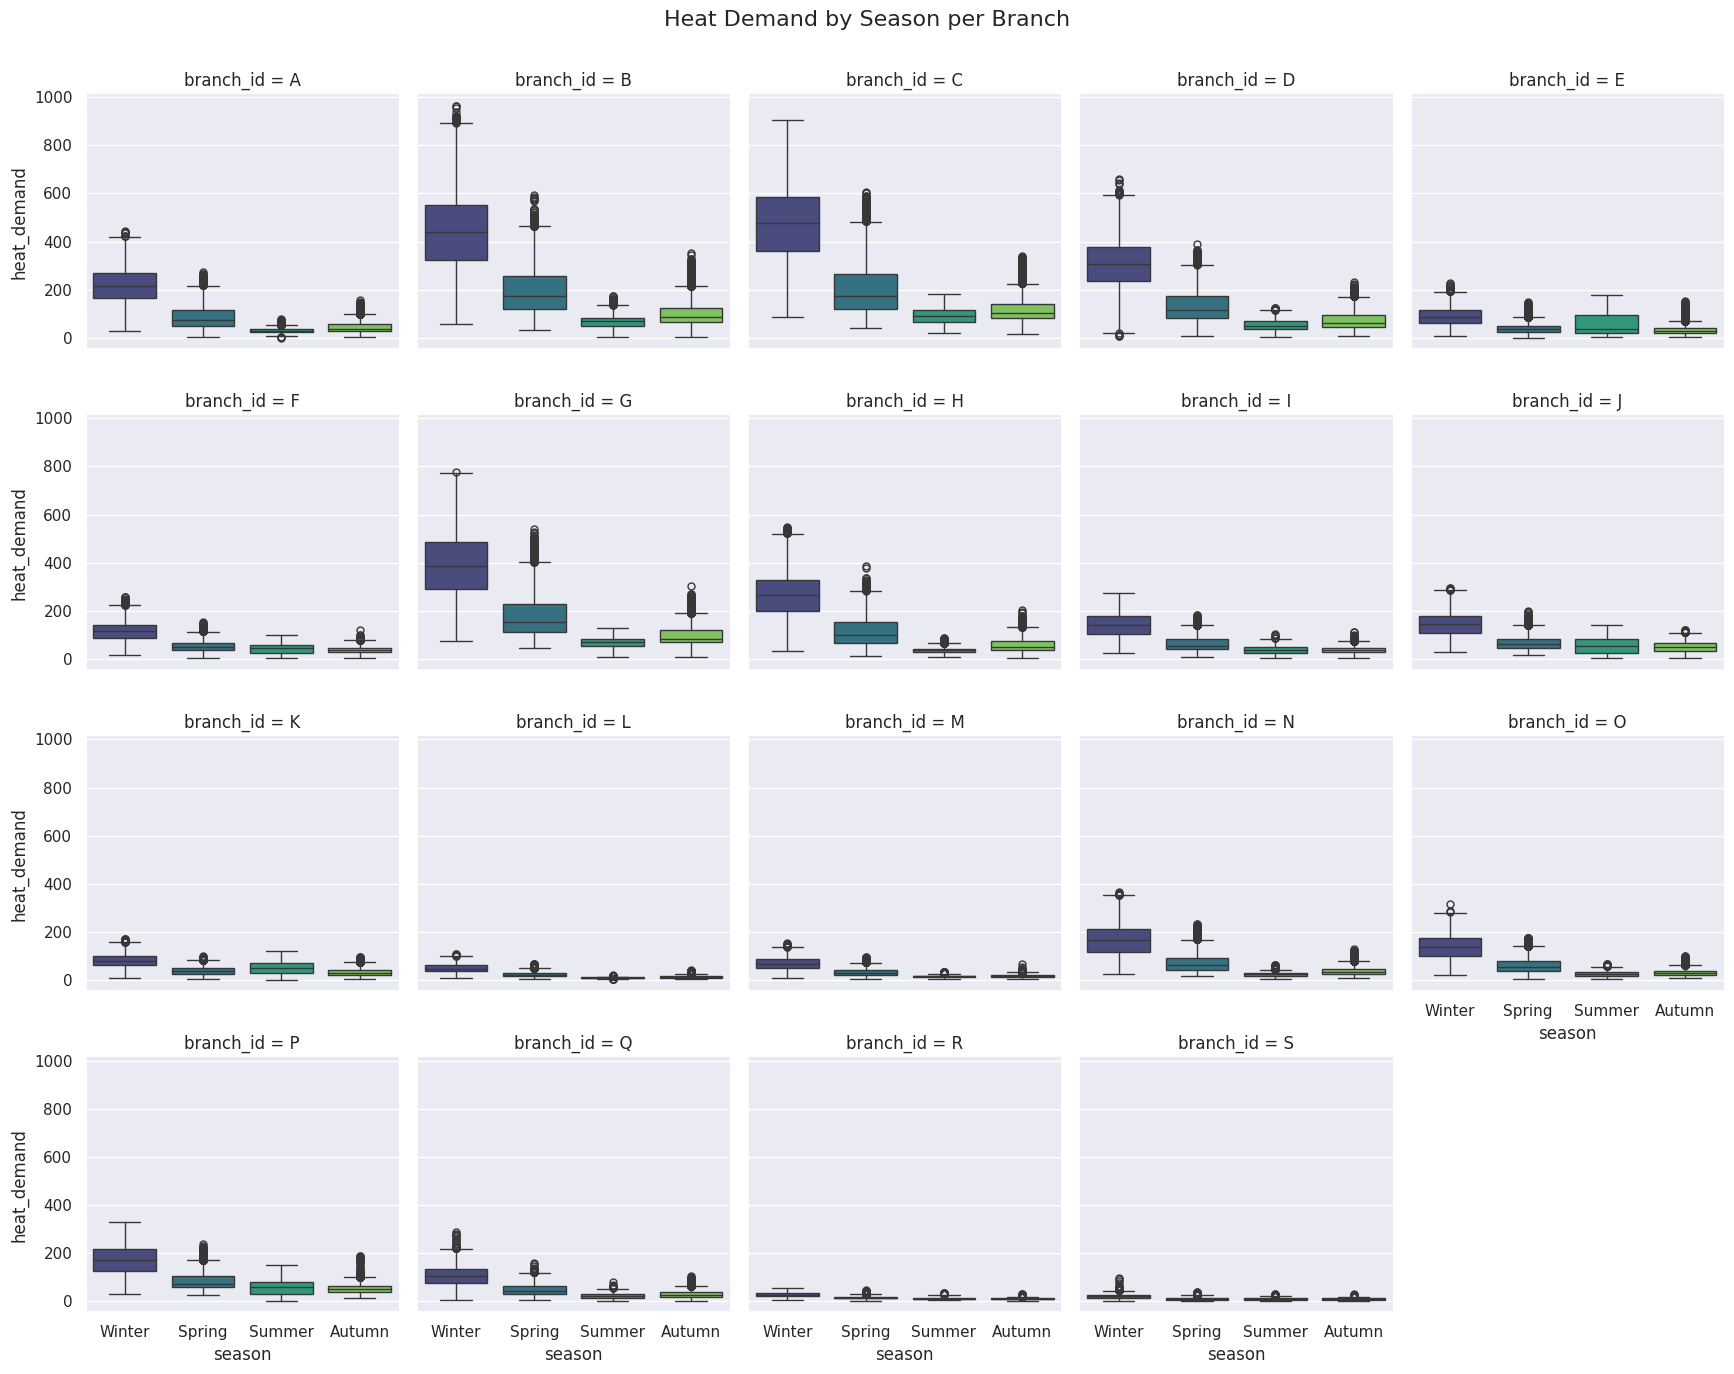

In [ ]:
# 계절 순서 명시 (선택사항: 기존에 설정 안 되어 있다면)
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']

# 시각화
g = sns.catplot(
    data=df_train, kind='box',
    x='season', y='heat_demand', col='branch_id',
    col_wrap=5, height=3.5, aspect=1,
    palette='viridis',
    order=season_order  # x축 계절 순서 지정
)

g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Heat Demand by Season per Branch', fontsize=16)

* 월별 x 지사별 열 수요

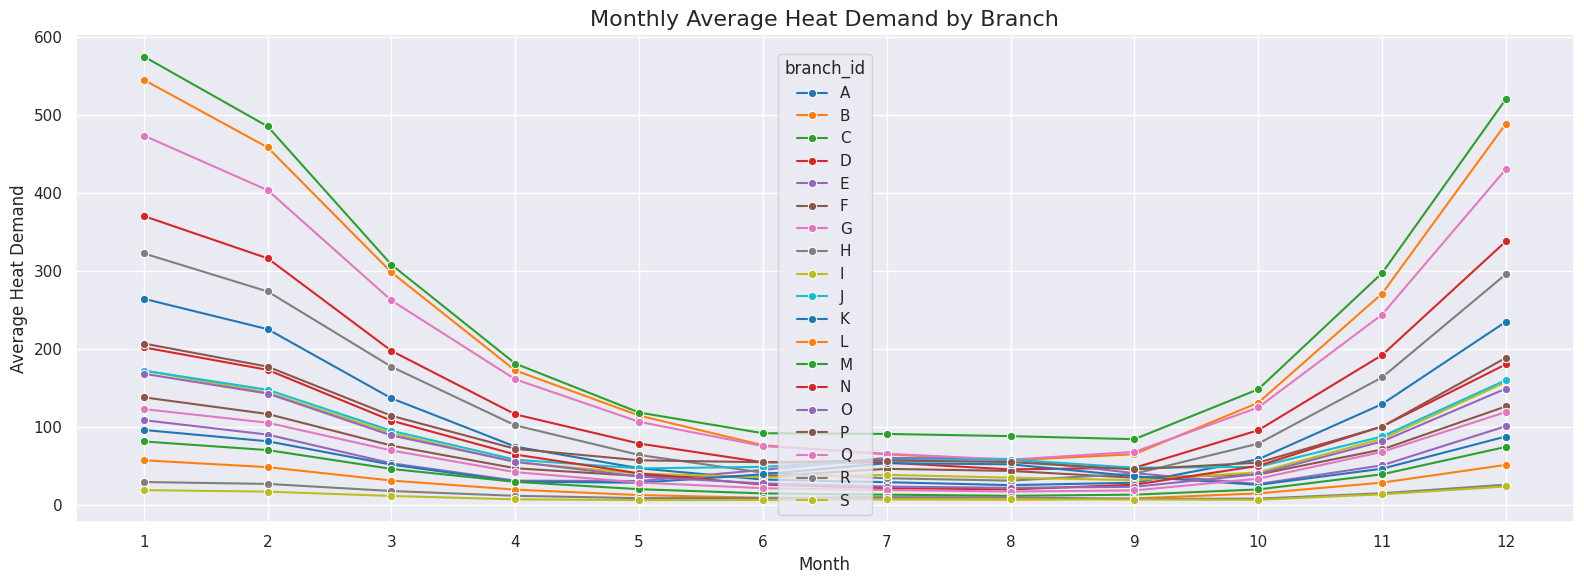

In [ ]:
# 월별 평균 열수요 계산
monthly_branch_avg = df_train.groupby(['month', 'branch_id'])['heat_demand'].mean().reset_index()

# 시각화
plt.figure(figsize=(16, 6))
sns.lineplot(data=monthly_branch_avg, x='month', y='heat_demand', hue='branch_id', marker='o', palette='tab10')
plt.title('Monthly Average Heat Demand by Branch', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Average Heat Demand')
plt.xticks(ticks=range(1, 13))  # 1~12월 표시
plt.grid(True)
plt.tight_layout()
plt.show()


##### **(2) ta (기온)**

* 결측치

In [ ]:
# 결측치 개수 확인
null_count = df_train['ta'].isnull().sum()
print(f"Missing values in 'ta': {null_count}")

# 전체 대비 비율 확인
total = len(df_train)
print(f"Percentage of missing: {null_count / total:.2%}")

Missing values in 'ta': 12995
Percentage of missing: 2.60%


In [ ]:
# 결측치가 있는 행 살펴보기
df_train[df_train['ta'].isnull()]

tm branch_id  ta  wd  ws  rn_day  rn_hr1  hm    si  \
12512  2022-06-06 10:00:00         A NaN NaN NaN     NaN     NaN NaN  0.68   
14504  2022-08-28 10:00:00         A NaN NaN NaN     NaN     NaN NaN  1.81   
15722  2022-10-18 04:00:00         A NaN NaN NaN     NaN     NaN NaN   NaN   
15941  2022-10-27 07:00:00         A NaN NaN NaN     NaN     NaN NaN  0.00   
28998  2021-04-24 10:00:00         B NaN NaN NaN     NaN     NaN NaN  1.20   
...                    ...       ...  ..  ..  ..     ...     ...  ..   ...   
498088 2023-11-12 10:00:00         S NaN NaN NaN     NaN     NaN NaN  1.31   
498089 2023-11-12 11:00:00         S NaN NaN NaN     NaN     NaN NaN  1.80   
498090 2023-11-12 12:00:00         S NaN NaN NaN     NaN     NaN NaN  2.11   
498091 2023-11-12 13:00:00         S NaN NaN NaN     NaN     NaN NaN  2.17   
498092 2023-11-12 14:00:00         S NaN NaN NaN     NaN     NaN NaN  2.03   

        ta_chi  heat_demand  year  quarter  month  day_of_week  season  \
12512     19.6         30.0  2022        2      6            0  Summer   
14504     23.2         27.0  2022        3      8            6  Summer   
15722      6.1         95.0  2022        4     10            1  Autumn   
15941      7.7        103.0  2022        4     10            3  Autumn   
28998     18.9        123.0  2021        2      4            5  Spring   
...        ...          ...   ...      ...    ...          ...     ...   
498088     2.0         16.0  2023        4     11            6  Winter   
498089     1.7         17.0  2023        4     11            6  Winter   
498090     1.7         15.0  2023        4     11            6  Winter   
498091     2.7         15.0  2023        4     11            6  Winter   
498092     3.1         15.0  2023        4     11            6  Winter   

       is_weekend  weekofyear  log_heat_demand  hour_group  
12512     Weekday          23         3.433987           3  
14504     Weekend          34         3.332205           3  
15722     Weekday          42         4.564348           1  
15941     Weekday          43         4.644391           2  
28998     Weekend          16         4.820282           3  
...           ...         ...              ...         ...  
498088    Weekend          45         2.833213           3  
498089    Weekend          45         2.890372           3  
498090    Weekend          45         2.772589           4  
498091    Weekend          45         2.772589           4  
498092    Weekend          45         2.772589           4  

[12995 rows x 20 columns]

* 계절별 기온 / 월별 기온

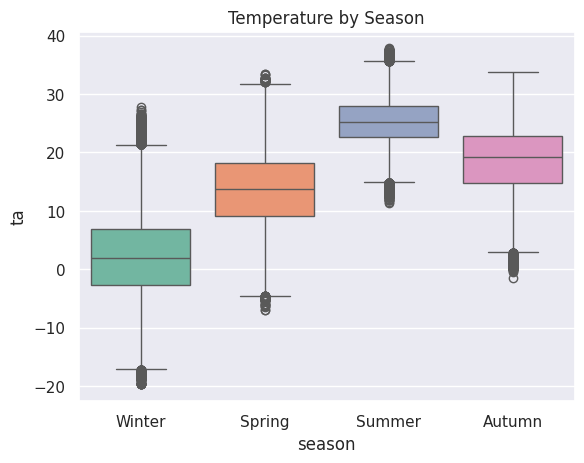

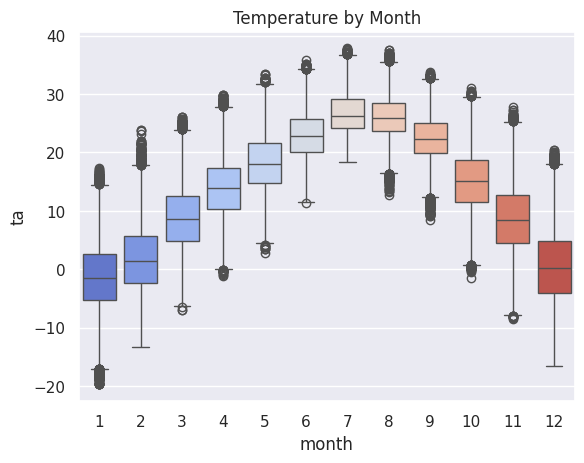

In [ ]:
# 계절별
sns.boxplot(x='season', y='ta', data=df_train, palette='Set2', order=['Winter', 'Spring', 'Summer', 'Autumn'])
plt.title('Temperature by Season')
plt.show()

# 월별
sns.boxplot(x='month', y='ta', data=df_train, palette='coolwarm')
plt.title('Temperature by Month')
plt.show()

* 기온과 열수요의 관계

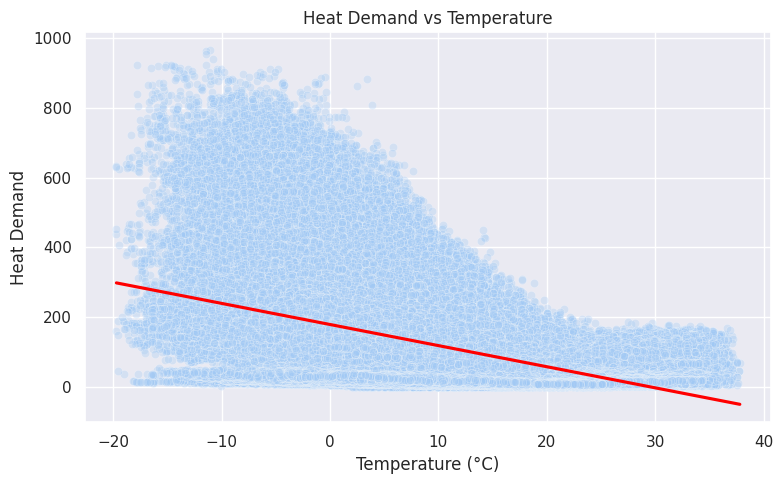

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='ta', y='heat_demand', data=df_train, alpha=0.3)
sns.regplot(x='ta', y='heat_demand', data=df_train, scatter=False, color='red')
plt.title('Heat Demand vs Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Heat Demand')
plt.grid(True)
plt.tight_layout()
plt.show()

* 지점별 기온과 열수요 관계

Text(0.5, 0.98, 'Heat Demand vs Temperature by Branch')

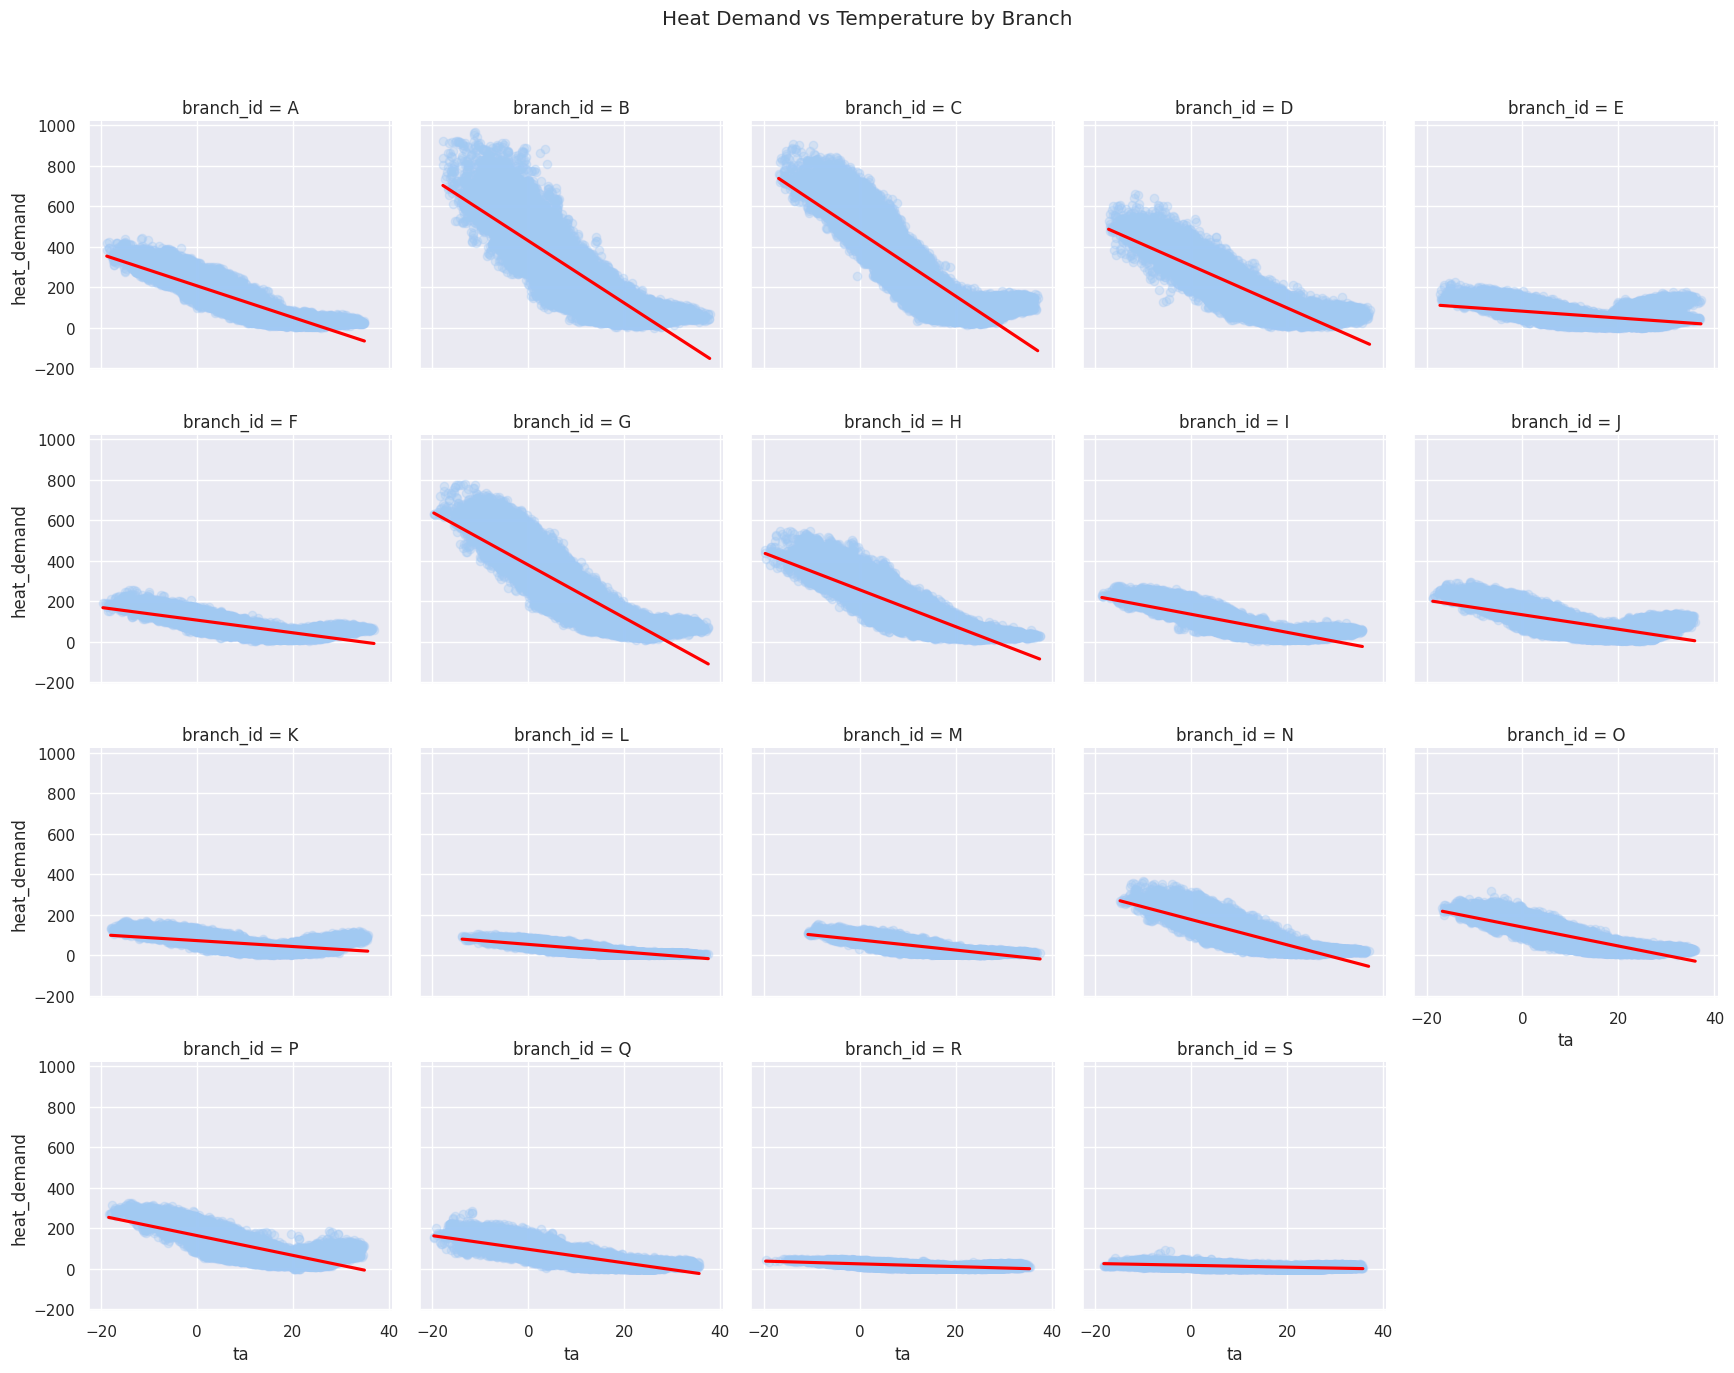

In [ ]:
g = sns.lmplot(data=df_train, x='ta', y='heat_demand', col='branch_id', col_wrap=5,
               scatter_kws={'alpha':0.3}, line_kws={'color':'red'}, height=3.5, aspect=1)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Heat Demand vs Temperature by Branch')

##### **(3) wd (풍향)**

풍향 변수는 범주형 변수로 다룰 수도 있고, 연속 각도 변수로 다룰 수도 있음

+ 풍향은 주기를 가지기 때문에 sin, cos 변환을 고려해도 됨

* 범주형 변수인 경우

In [ ]:
def wind_direction_category(deg):
    if pd.isna(deg):
        return 'Unknown'  # 또는 np.nan
    directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    return directions[int((deg % 360) / 45)]

df_train['wd_cat'] = df_train['wd'].apply(wind_direction_category)

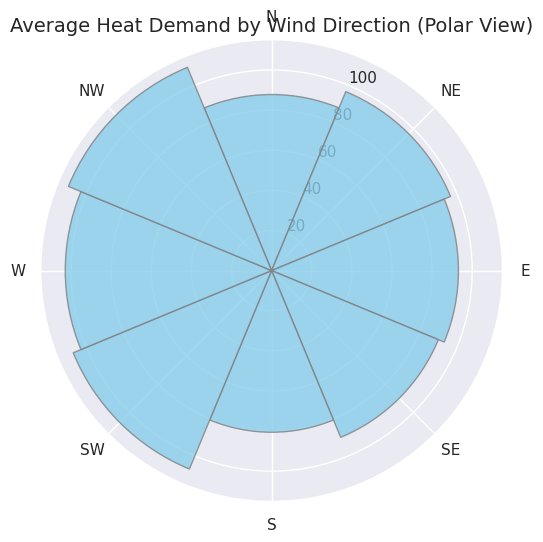

In [77]:
# 방위 각도 설정 (중심 각, degree 기준)
direction_labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
direction_angles = np.deg2rad(np.arange(0, 360, 45))  # [0, 45, 90, ..., 315]

# 평균 열수요 계산 (Unknown 제외)
direction_mean = (
    df_train[df_train['wd_cat'] != 'Unknown']
    .groupby('wd_cat')['heat_demand']
    .mean()
    .reindex(direction_labels)  # 순서 맞추기
)

# 극좌표 막대그래프
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, polar=True)

bars = ax.bar(
    direction_angles,                  # 각도
    direction_mean.values,            # 길이(열수요)
    width=np.deg2rad(45),             # 각 막대의 너비
    bottom=0, color='skyblue', edgecolor='gray', alpha=0.8
)

ax.set_theta_zero_location("N")  # 0도를 북쪽으로
ax.set_theta_direction(-1)       # 시계 방향

ax.set_xticks(direction_angles)
ax.set_xticklabels(direction_labels)
ax.set_title("Average Heat Demand by Wind Direction (Polar View)", fontsize=14)

plt.show()


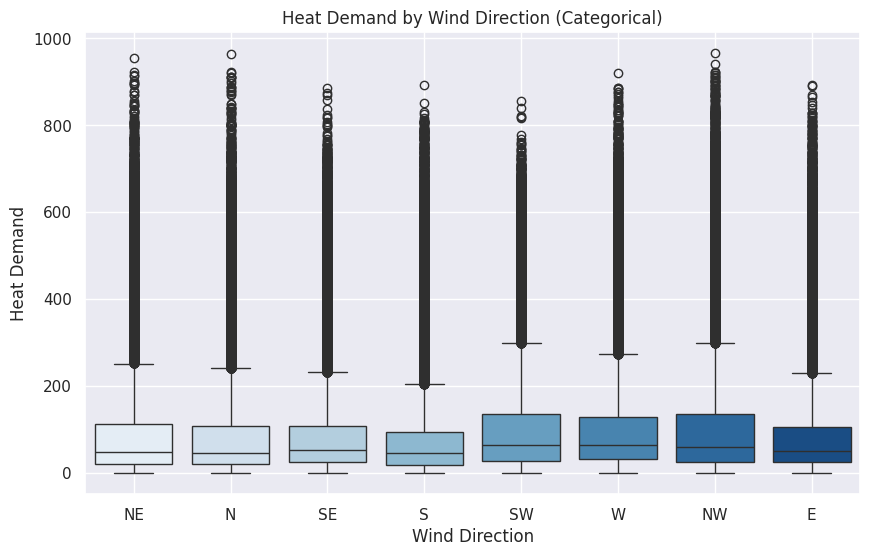

In [76]:
# 결측 방위는 제외하고 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='wd_cat', y='heat_demand', data=df_train[df_train['wd_cat'] != 'Unknown'], palette='Blues')
plt.title('Heat Demand by Wind Direction (Categorical)')
plt.xlabel('Wind Direction')
plt.ylabel('Heat Demand')
plt.grid(True)
plt.show()

* 연속형 변수로 다루는 경우

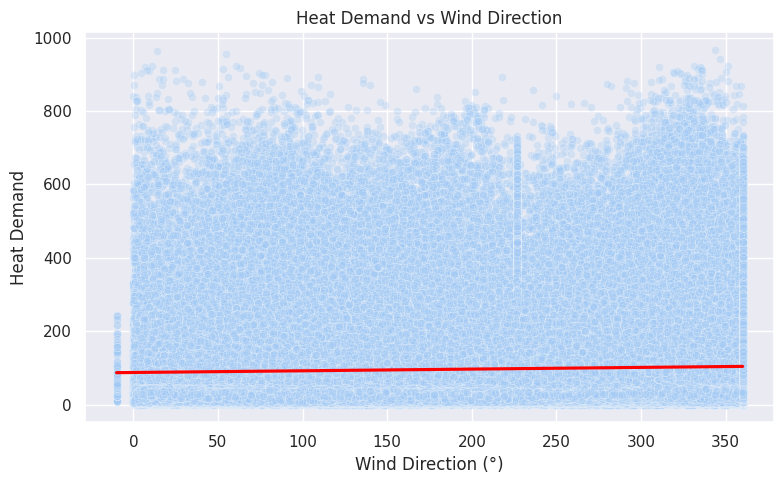

In [29]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='wd', y='heat_demand', data=df_train, alpha=0.3)
sns.regplot(x='wd', y='heat_demand', data=df_train, scatter=False, color='red')
plt.title('Heat Demand vs Wind Direction')
plt.xlabel('Wind Direction (°)')
plt.ylabel('Heat Demand')
plt.grid(True)
plt.tight_layout()
plt.show()


* 지사별로 풍향과 열수요 관계 확인

Text(0.5, 0.98, 'Heat Demand by Wind Direction per Branch')

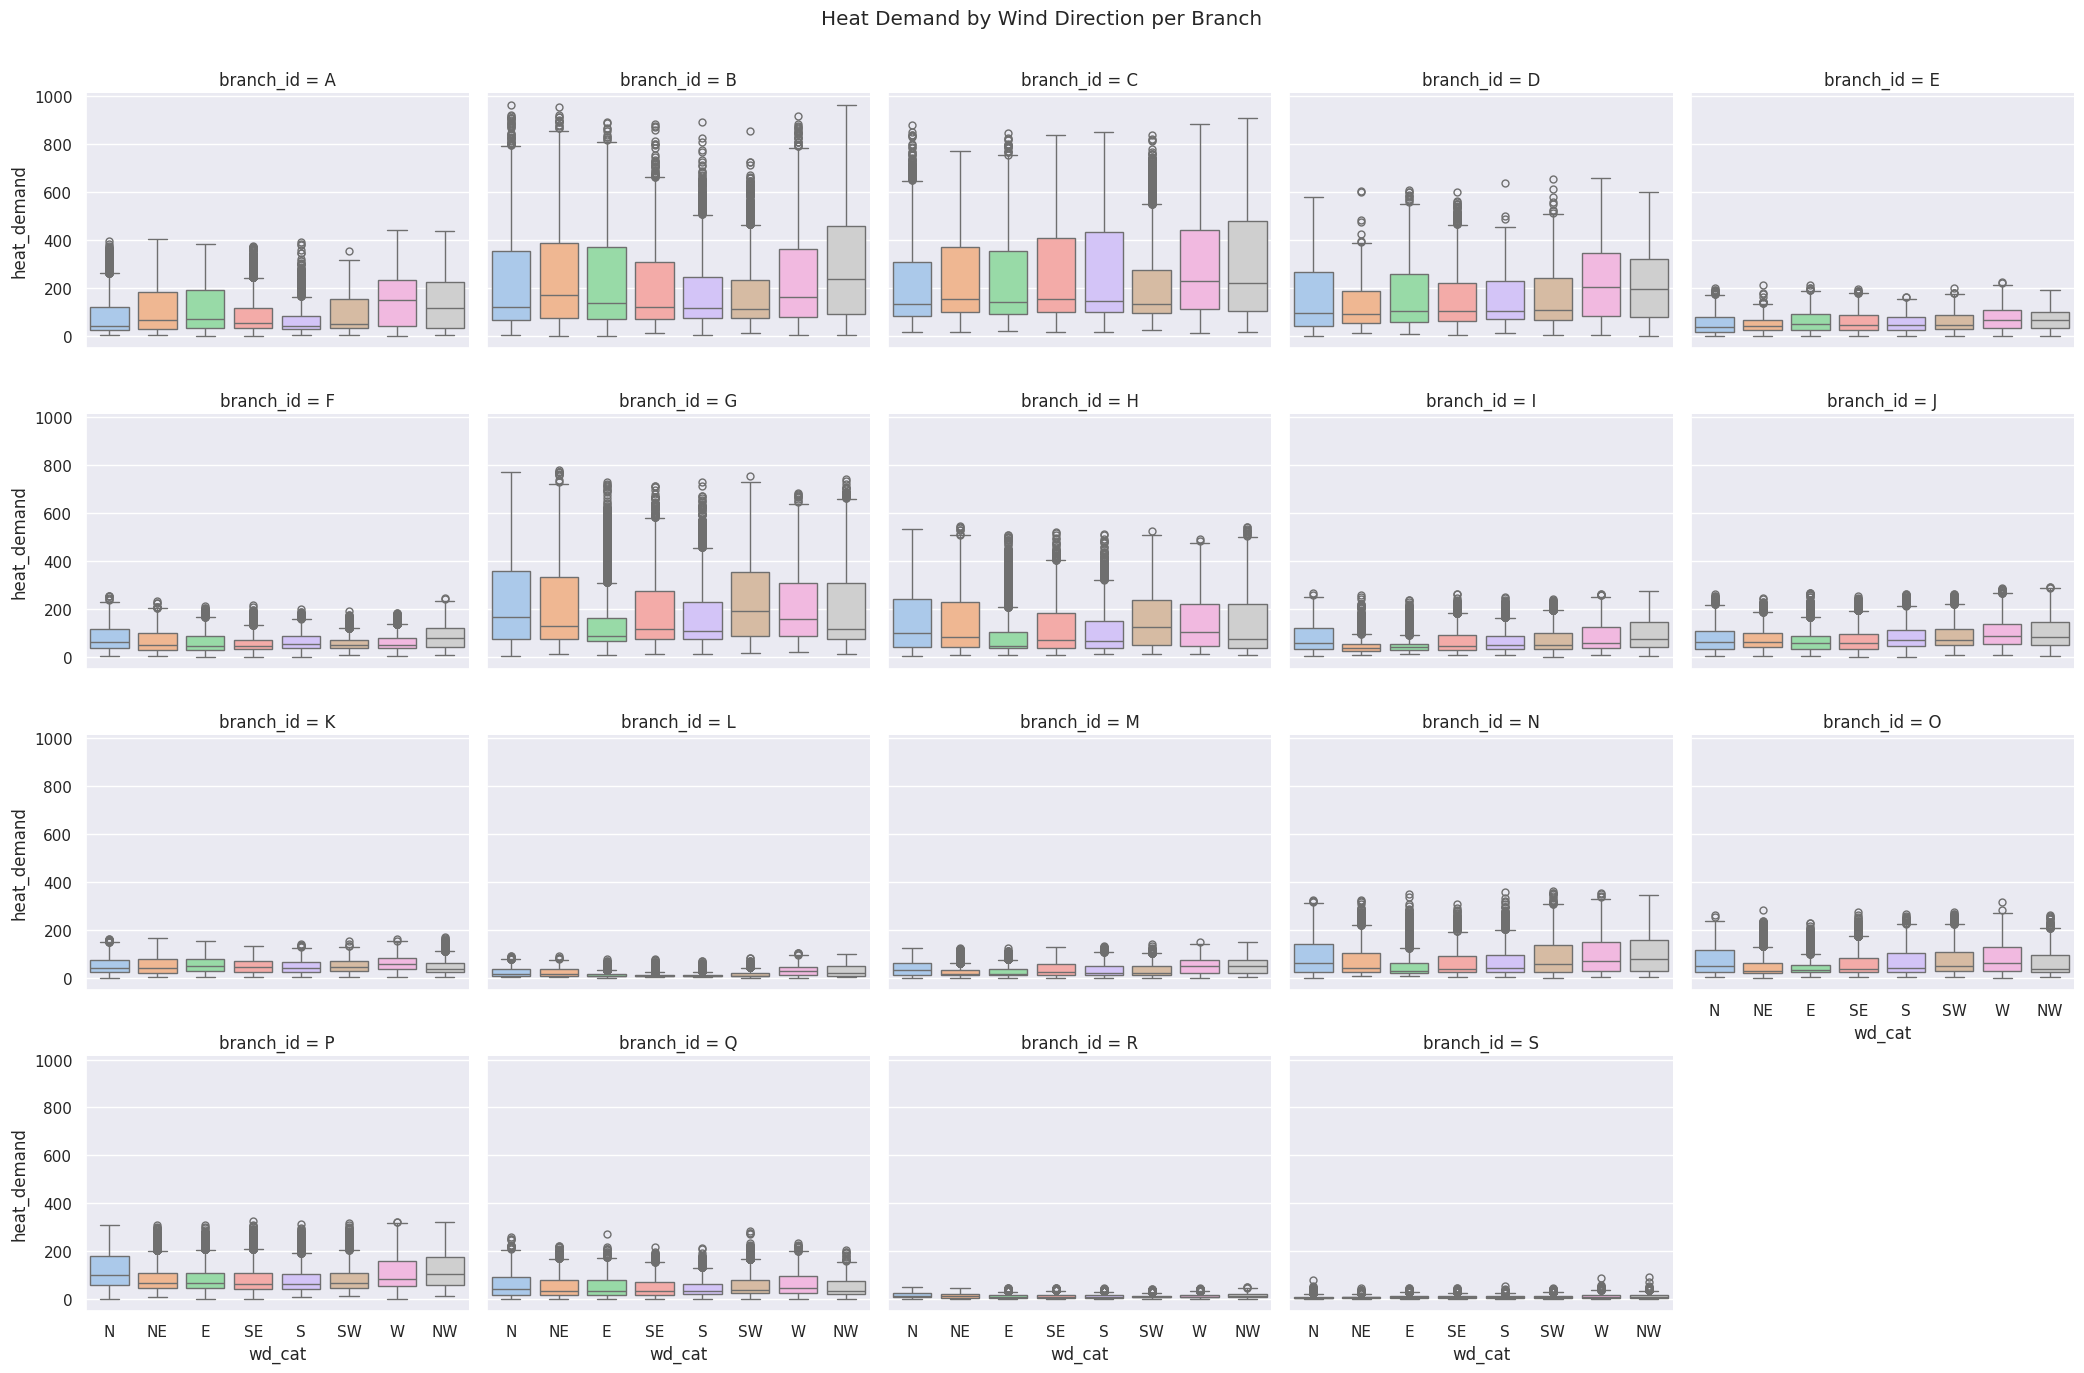

In [79]:
# 1. 풍향별 열수요 분포 (지사별 박스플롯)
g = sns.catplot(
    data=df_train[df_train['wd_cat'] != 'Unknown'],
    kind='box', x='wd_cat', y='heat_demand', col='branch_id',
    col_wrap=5, height=3.5, aspect=1.2, palette='pastel',
    order=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
)
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Heat Demand by Wind Direction per Branch')

Text(0.5, 0.98, 'Heat Demand vs Wind Direction by Branch')

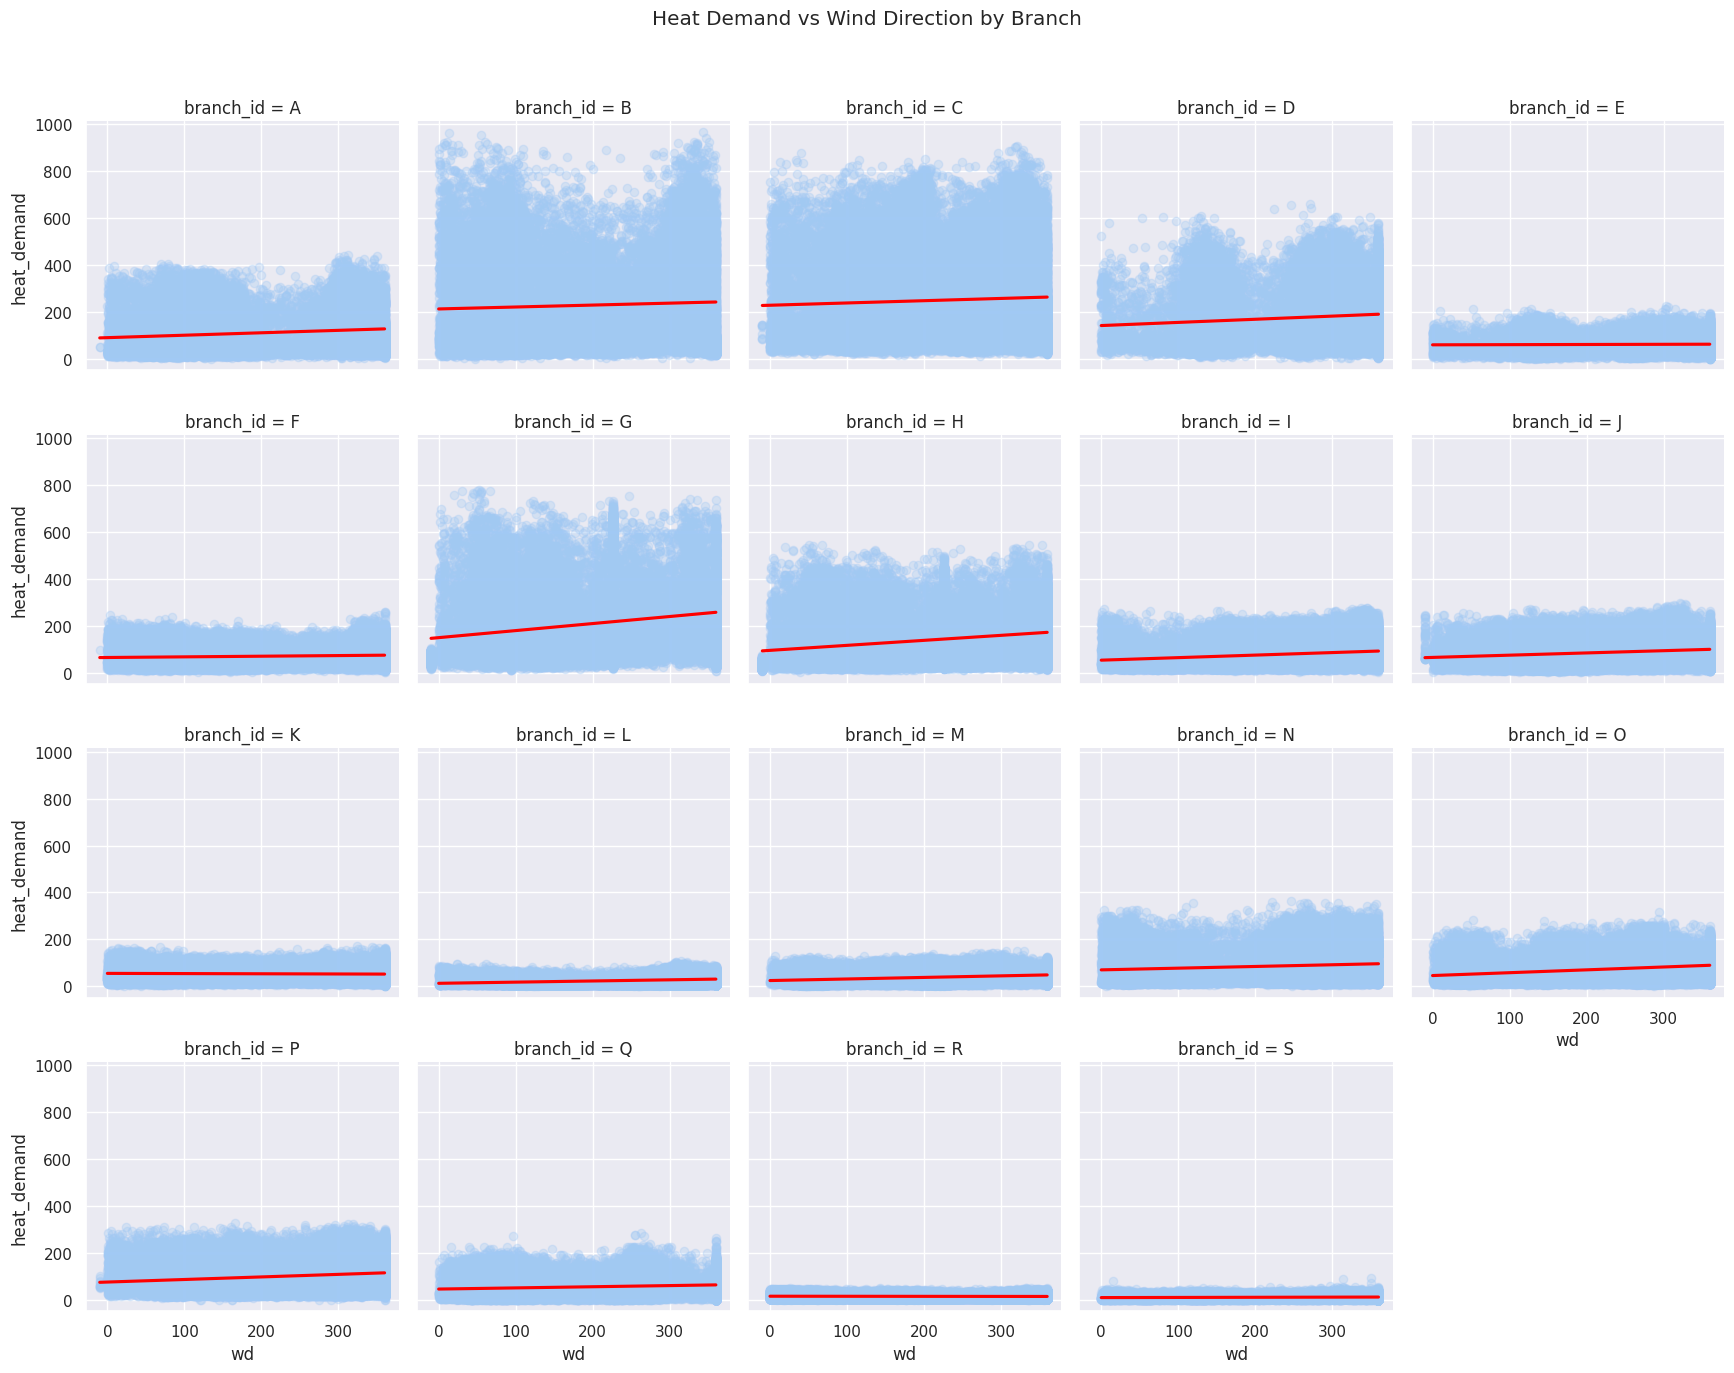

In [30]:
g = sns.lmplot(data=df_train, x='wd', y='heat_demand', col='branch_id', col_wrap=5,
               scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'}, height=3.5, aspect=1)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Heat Demand vs Wind Direction by Branch')

##### **(4) ws**

* 풍속 분포 확인

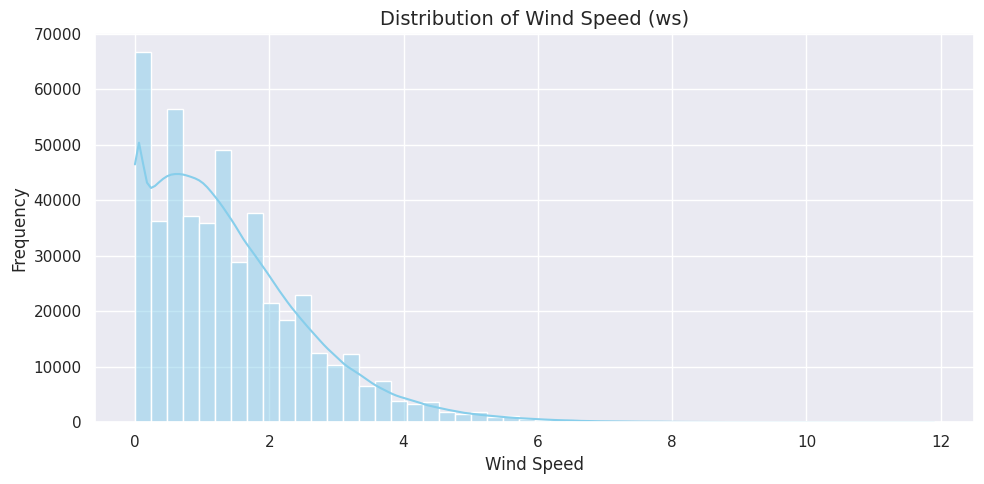

In [81]:
plt.figure(figsize=(10, 5))
sns.histplot(df_train['ws'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Wind Speed (ws)', fontsize=14)
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

* 풍속과 열수요 관계

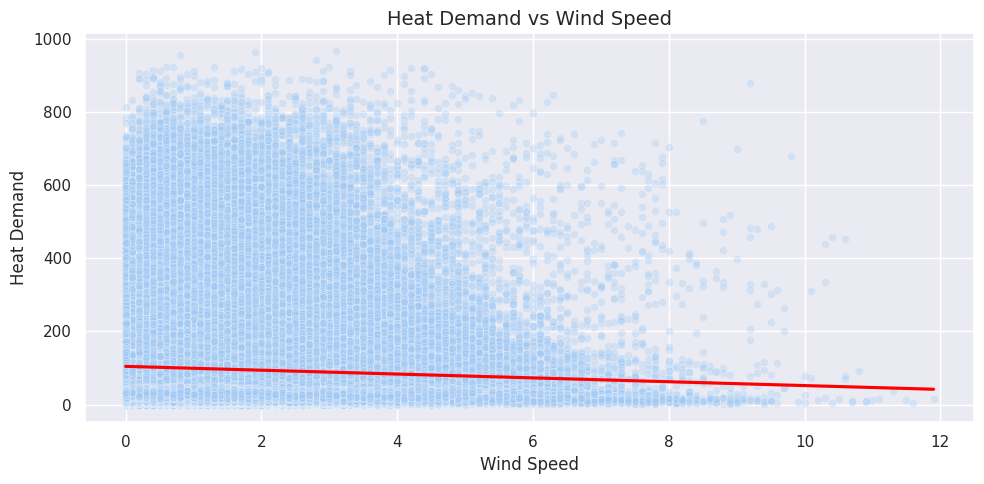

In [82]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_train, x='ws', y='heat_demand', alpha=0.3)
sns.regplot(data=df_train, x='ws', y='heat_demand', scatter=False, color='red')
plt.title('Heat Demand vs Wind Speed', fontsize=14)
plt.xlabel('Wind Speed')
plt.ylabel('Heat Demand')
plt.grid(True)
plt.tight_layout()
plt.show()

* 지사별 풍속과 열수요 관계

Text(0.5, 0.98, 'Heat Demand vs Wind Speed by Branch')

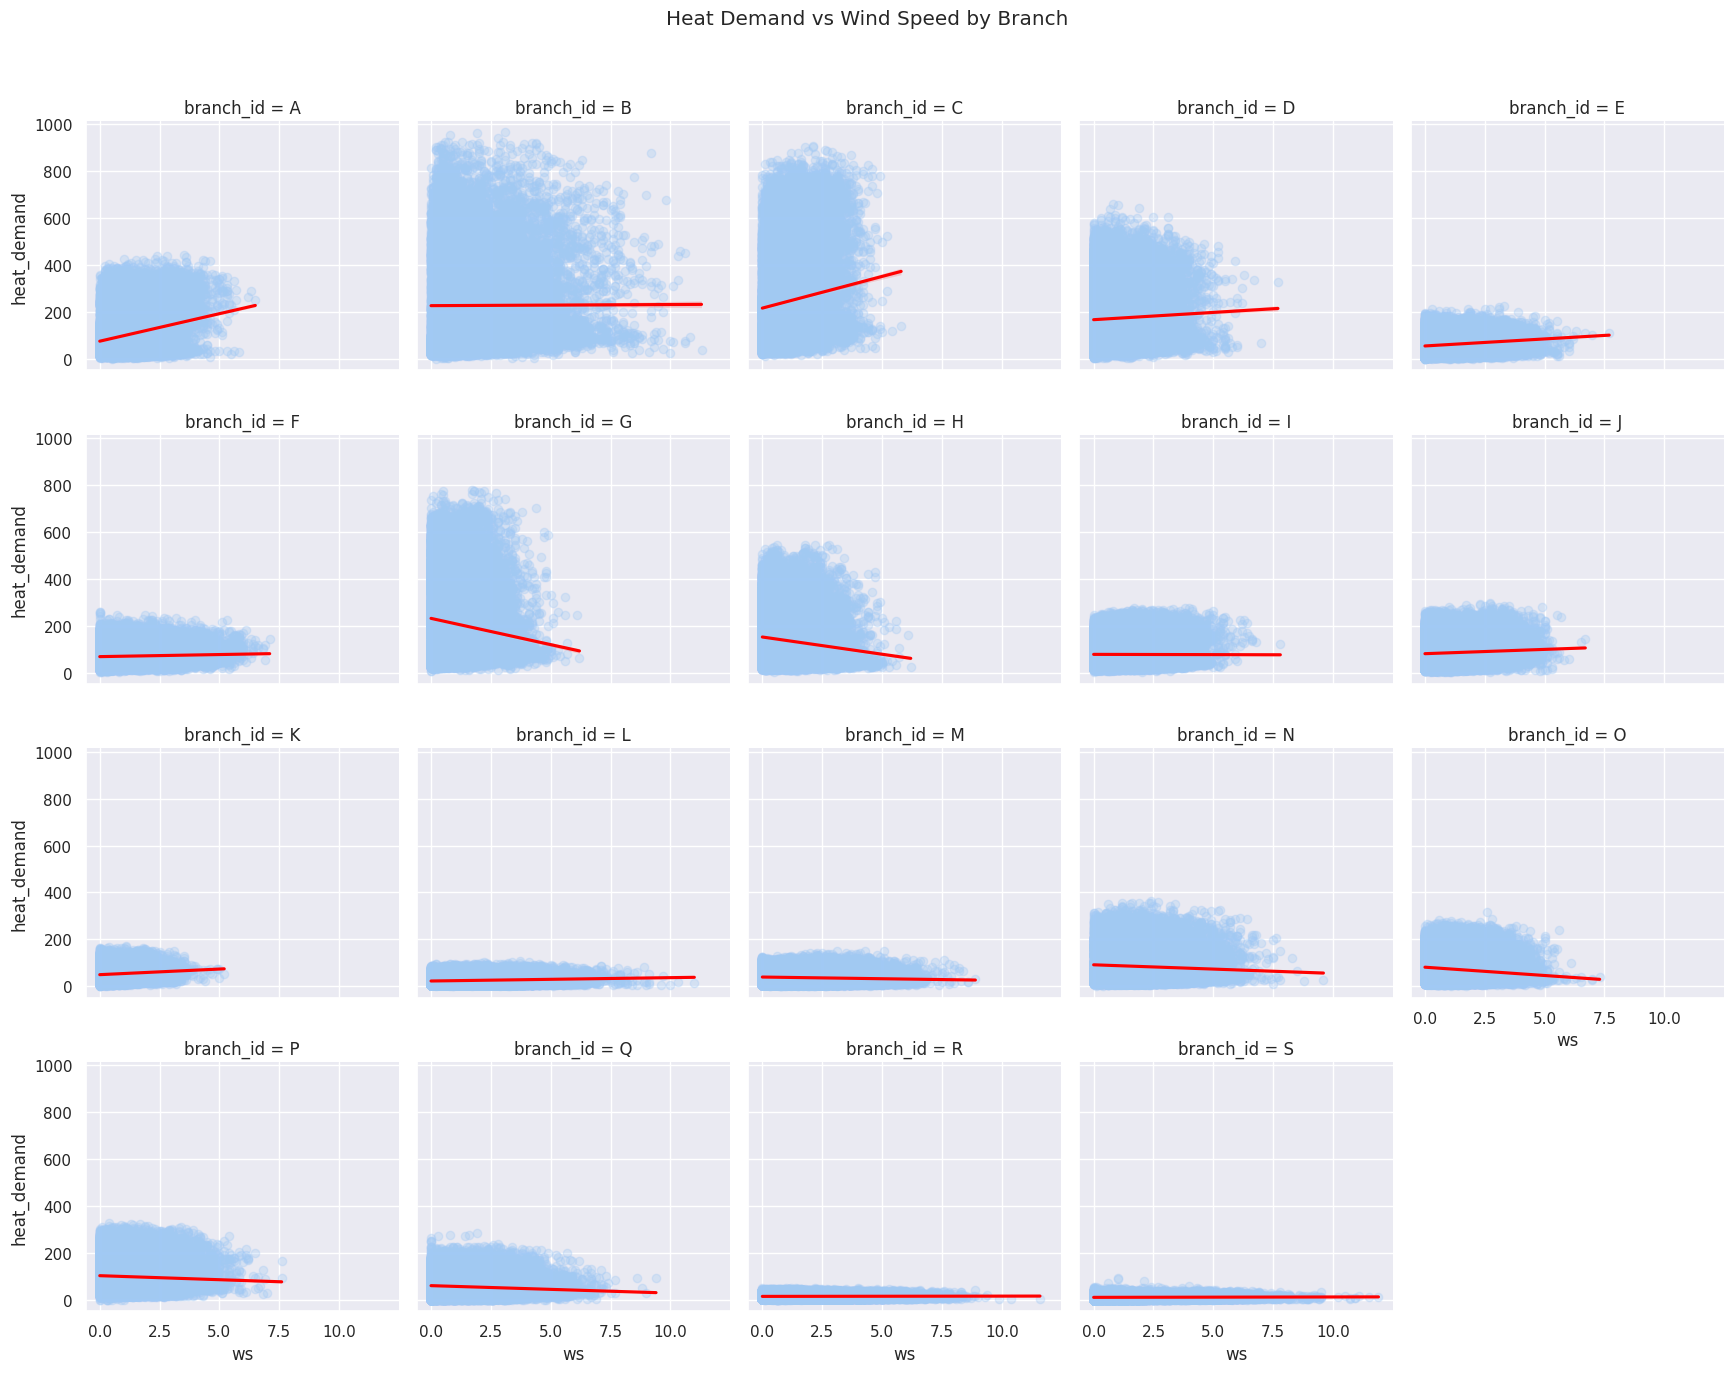

In [83]:
g = sns.lmplot(
    data=df_train,
    x='ws', y='heat_demand', col='branch_id',
    col_wrap=5, height=3.5, aspect=1,
    scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'}
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Heat Demand vs Wind Speed by Branch')

* 풍속 + 풍향 조합의 히트맵

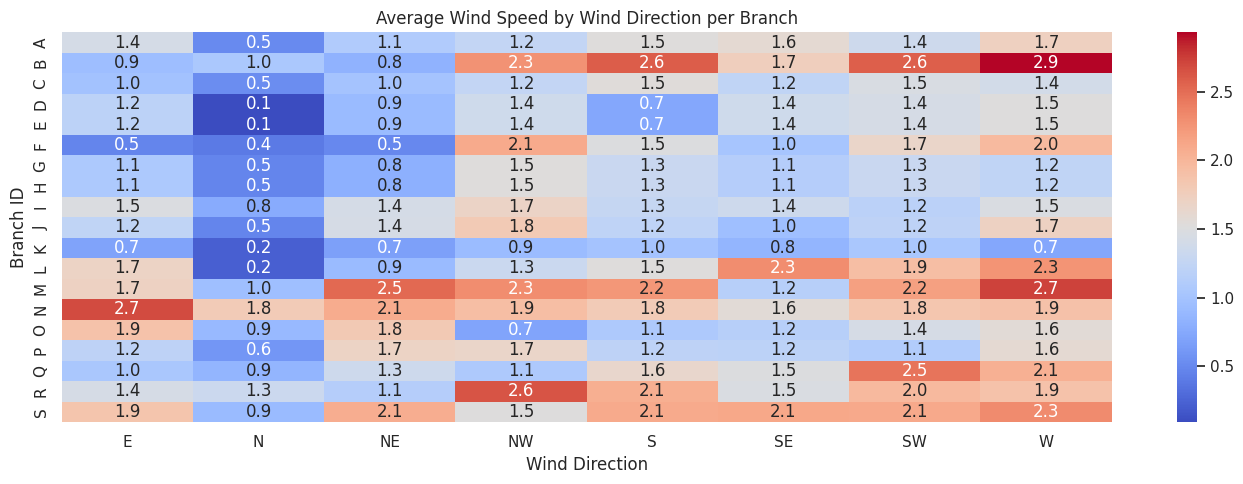

In [84]:
# 2. 풍속 + 풍향 조합 히트맵 (지사별 평균 풍속)
wind_speed_dir = (
    df_train[df_train['wd_cat'] != 'Unknown']
    .groupby(['branch_id', 'wd_cat'])['ws']
    .mean()
    .unstack()
)

plt.figure(figsize=(14, 5))
sns.heatmap(wind_speed_dir, cmap='coolwarm', annot=True, fmt=".1f")
plt.title('Average Wind Speed by Wind Direction per Branch')
plt.xlabel('Wind Direction')
plt.ylabel('Branch ID')
plt.tight_layout()
plt.show()


##### **(5) rn_day**

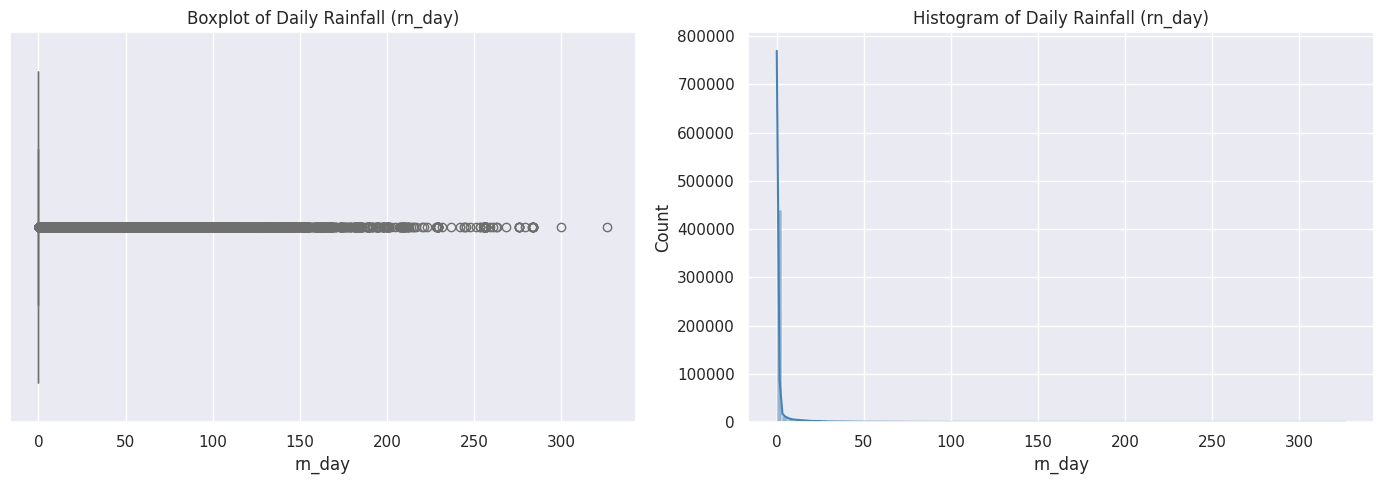

In [87]:
plt.figure(figsize=(14, 5))

# 박스플롯
plt.subplot(1, 2, 1)
sns.boxplot(x=df_train['rn_day'], color='skyblue')
plt.title('Boxplot of Daily Rainfall (rn_day)')

# 히스토그램
plt.subplot(1, 2, 2)
sns.histplot(df_train['rn_day'], bins=100, kde=True, color='steelblue')
plt.title('Histogram of Daily Rainfall (rn_day)')

plt.tight_layout()
plt.show()

* 계절별 박스플롯

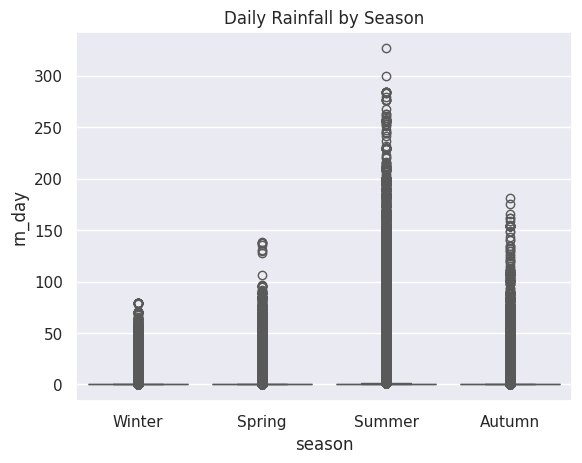

In [89]:
sns.boxplot(x='season', y='rn_day', data=df_train, palette='Set2', order=['Winter', 'Spring', 'Summer', 'Autumn'])
plt.title('Daily Rainfall by Season')
plt.show()

* 월별 강수량 추이

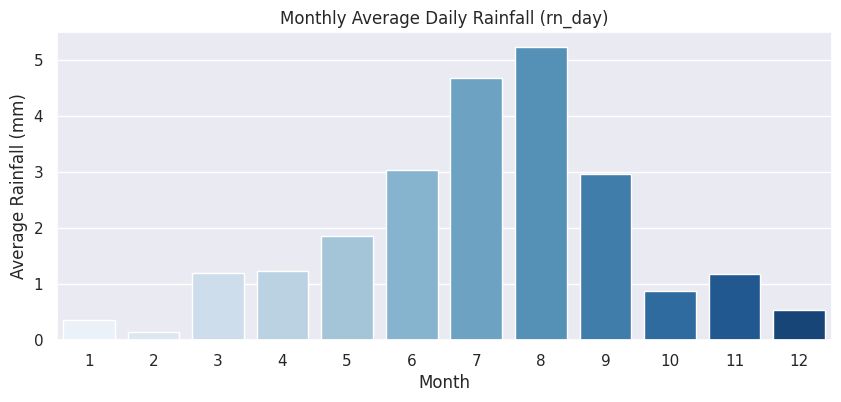

In [90]:
monthly_rain = df_train.groupby('month')['rn_day'].mean()
plt.figure(figsize=(10, 4))
sns.barplot(x=monthly_rain.index, y=monthly_rain.values, palette='Blues')
plt.title('Monthly Average Daily Rainfall (rn_day)')
plt.xlabel('Month')
plt.ylabel('Average Rainfall (mm)')
plt.show()


* 강수량과 열수요 관계

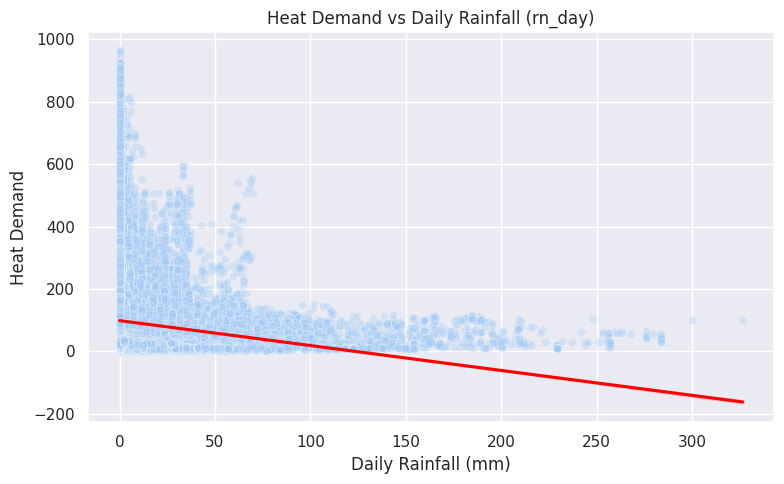

In [88]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='rn_day', y='heat_demand', data=df_train, alpha=0.3)
sns.regplot(x='rn_day', y='heat_demand', data=df_train, scatter=False, color='red')
plt.title('Heat Demand vs Daily Rainfall (rn_day)')
plt.xlabel('Daily Rainfall (mm)')
plt.ylabel('Heat Demand')
plt.grid(True)
plt.tight_layout()
plt.show()

##### **(6) hm**

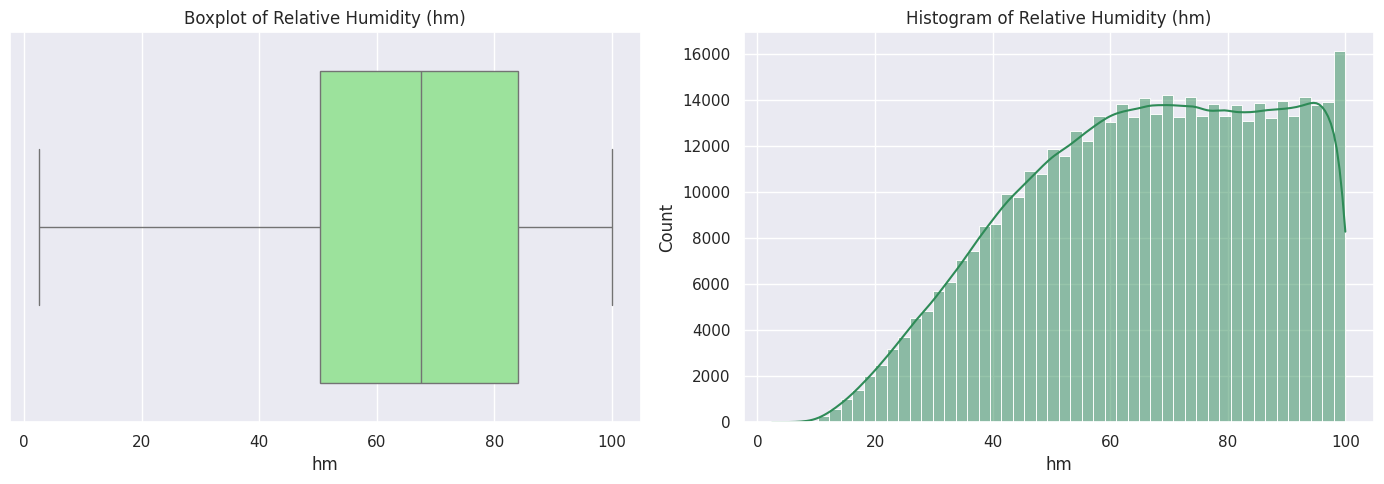

In [91]:
plt.figure(figsize=(14, 5))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x=df_train['hm'], color='lightgreen')
plt.title('Boxplot of Relative Humidity (hm)')

# Histogram
plt.subplot(1, 2, 2)
sns.histplot(df_train['hm'], bins=50, kde=True, color='seagreen')
plt.title('Histogram of Relative Humidity (hm)')

plt.tight_layout()
plt.show()


* 계절별 습도 비교

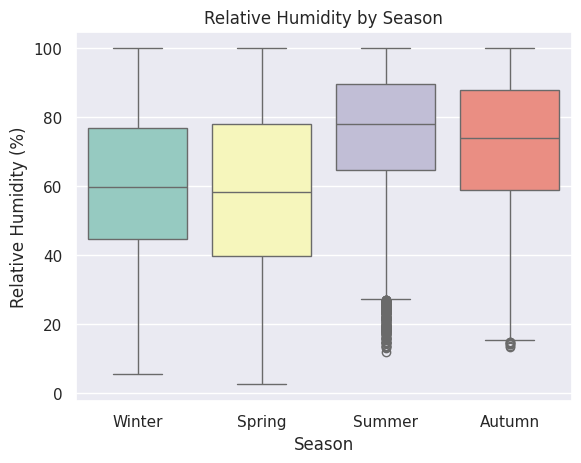

In [93]:
sns.boxplot(x='season', y='hm', data=df_train, palette='Set3', order=['Winter', 'Spring', 'Summer', 'Autumn'])
plt.title('Relative Humidity by Season')
plt.xlabel('Season')
plt.ylabel('Relative Humidity (%)')
plt.show()

* 월별 습도 비교

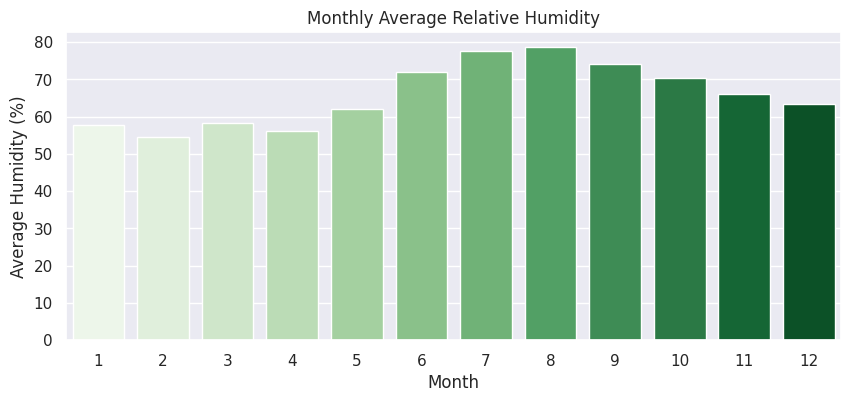

In [94]:
monthly_humidity = df_train.groupby('month')['hm'].mean()
plt.figure(figsize=(10, 4))
sns.barplot(x=monthly_humidity.index, y=monthly_humidity.values, palette='Greens')
plt.title('Monthly Average Relative Humidity')
plt.xlabel('Month')
plt.ylabel('Average Humidity (%)')
plt.show()

* 열수요와 습도 관계

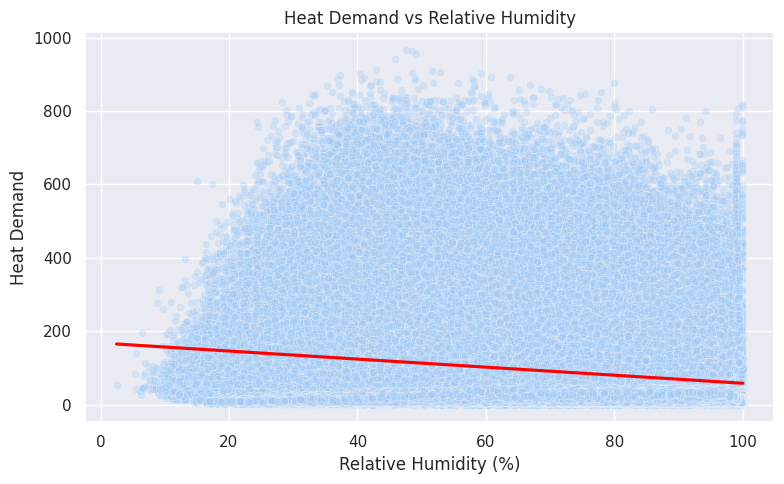

In [92]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='hm', y='heat_demand', data=df_train, alpha=0.3)
sns.regplot(x='hm', y='heat_demand', data=df_train, scatter=False, color='red')
plt.title('Heat Demand vs Relative Humidity')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Heat Demand')
plt.grid(True)
plt.tight_layout()
plt.show()


##### **(7) si**

* si 분포

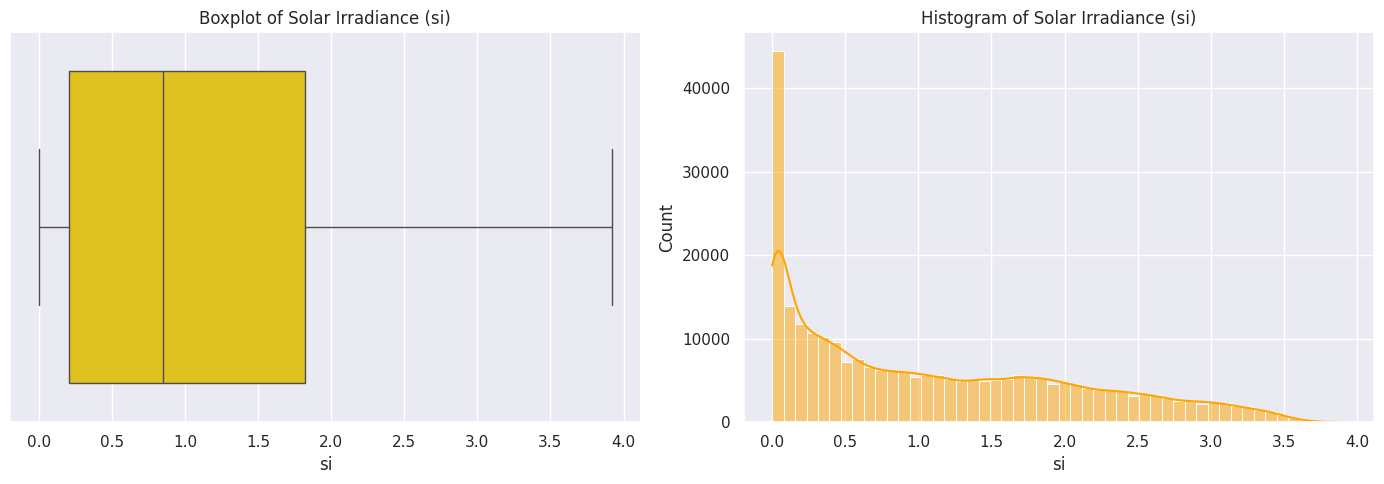

In [95]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=df_train['si'], color='gold')
plt.title('Boxplot of Solar Irradiance (si)')

plt.subplot(1, 2, 2)
sns.histplot(df_train['si'], bins=50, kde=True, color='orange')
plt.title('Histogram of Solar Irradiance (si)')

plt.tight_layout()
plt.show()


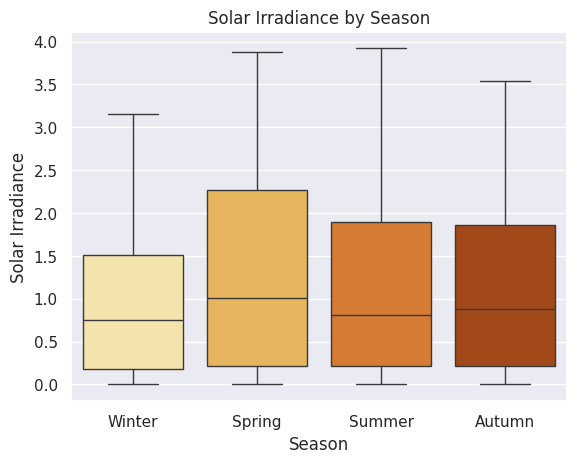

In [97]:
sns.boxplot(x='season', y='si', data=df_train, palette='YlOrBr', order=['Winter', 'Spring', 'Summer', 'Autumn'])
plt.title('Solar Irradiance by Season')
plt.xlabel('Season')
plt.ylabel('Solar Irradiance')
plt.show()


* 열수요와 일사량 관계

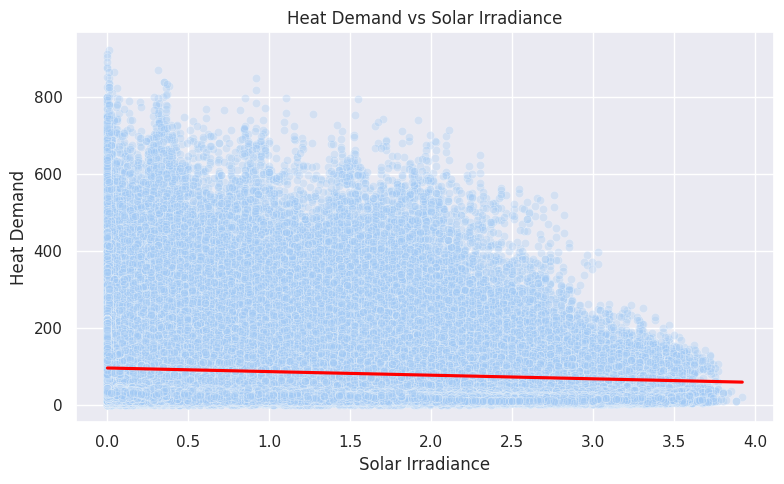

In [96]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='si', y='heat_demand', data=df_train, alpha=0.3)
sns.regplot(x='si', y='heat_demand', data=df_train, scatter=False, color='red')
plt.title('Heat Demand vs Solar Irradiance')
plt.xlabel('Solar Irradiance')
plt.ylabel('Heat Demand')
plt.grid(True)
plt.tight_layout()
plt.show()


* 지사별

Text(0.5, 0.98, 'Heat Demand vs si by Branch')

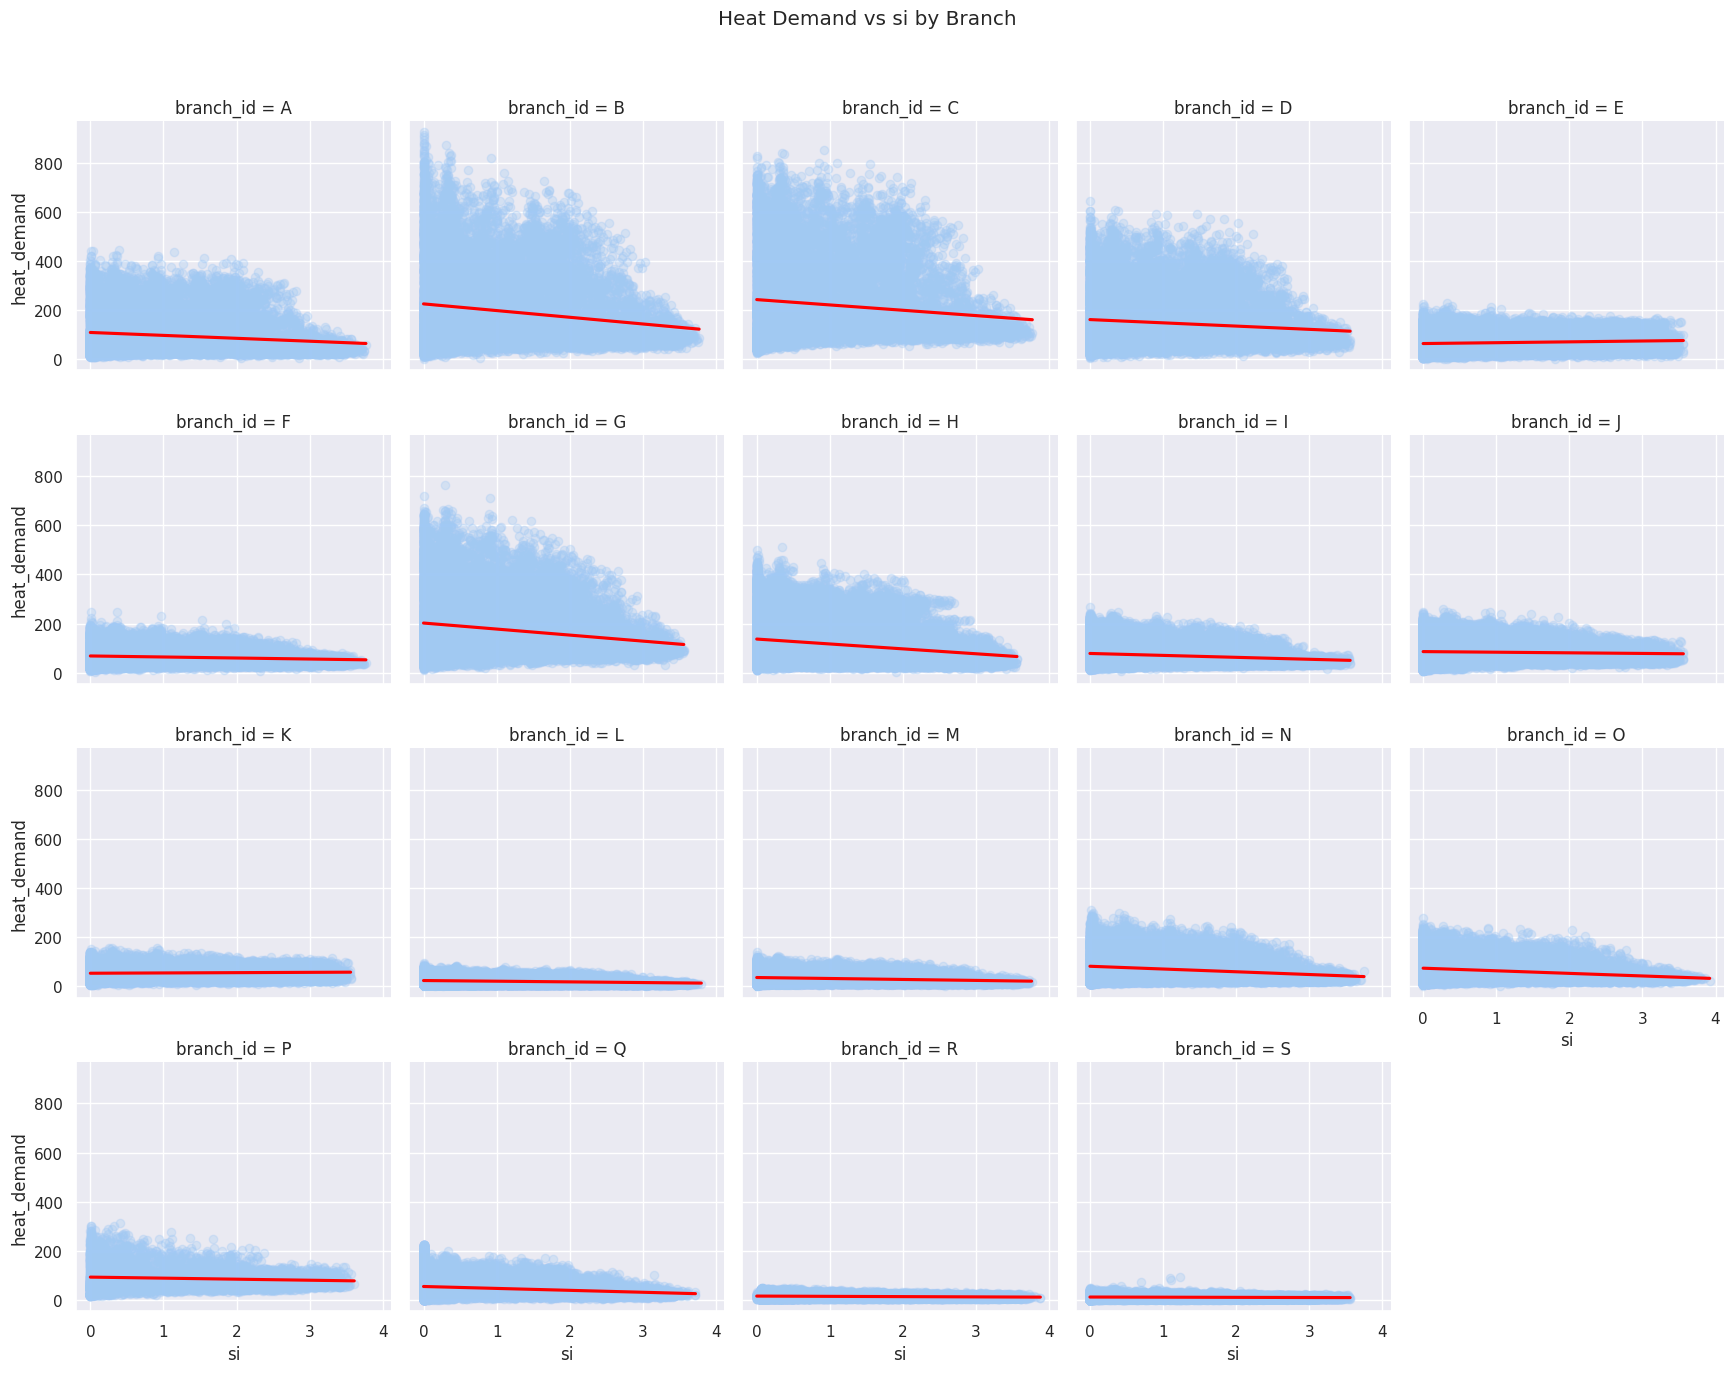

In [98]:
g = sns.lmplot(data=df_train, x='si', y='heat_demand', col='branch_id', col_wrap=5,
               scatter_kws={'alpha':0.3}, line_kws={'color':'red'}, height=3.5, aspect=1)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Heat Demand vs si by Branch')

##### **(8) ta_chi**

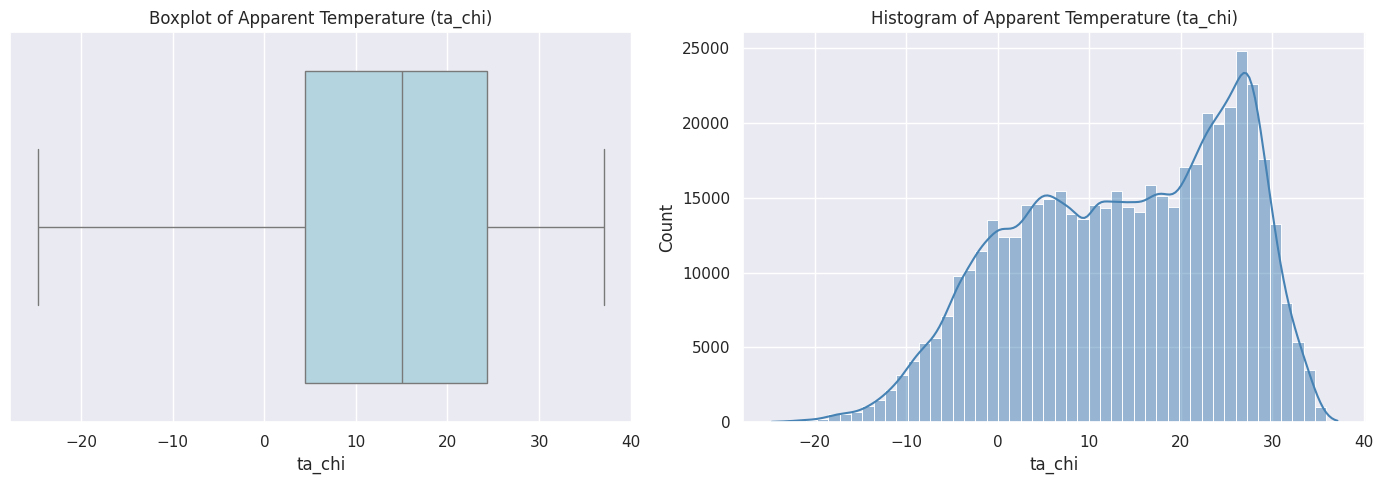

In [99]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=df_train['ta_chi'], color='lightblue')
plt.title('Boxplot of Apparent Temperature (ta_chi)')

plt.subplot(1, 2, 2)
sns.histplot(df_train['ta_chi'], bins=50, kde=True, color='steelblue')
plt.title('Histogram of Apparent Temperature (ta_chi)')

plt.tight_layout()
plt.show()


* 체감온도와 열수요 관계

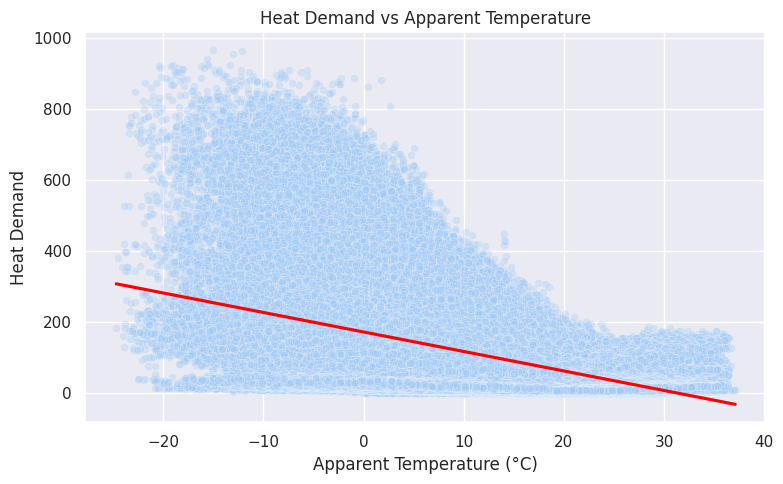

In [100]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='ta_chi', y='heat_demand', data=df_train, alpha=0.3)
sns.regplot(x='ta_chi', y='heat_demand', data=df_train, scatter=False, color='red')
plt.title('Heat Demand vs Apparent Temperature')
plt.xlabel('Apparent Temperature (°C)')
plt.ylabel('Heat Demand')
plt.grid(True)
plt.tight_layout()
plt.show()


* 지사별

Text(0.5, 0.98, 'Heat Demand vs Apparent Temperature by Branch')

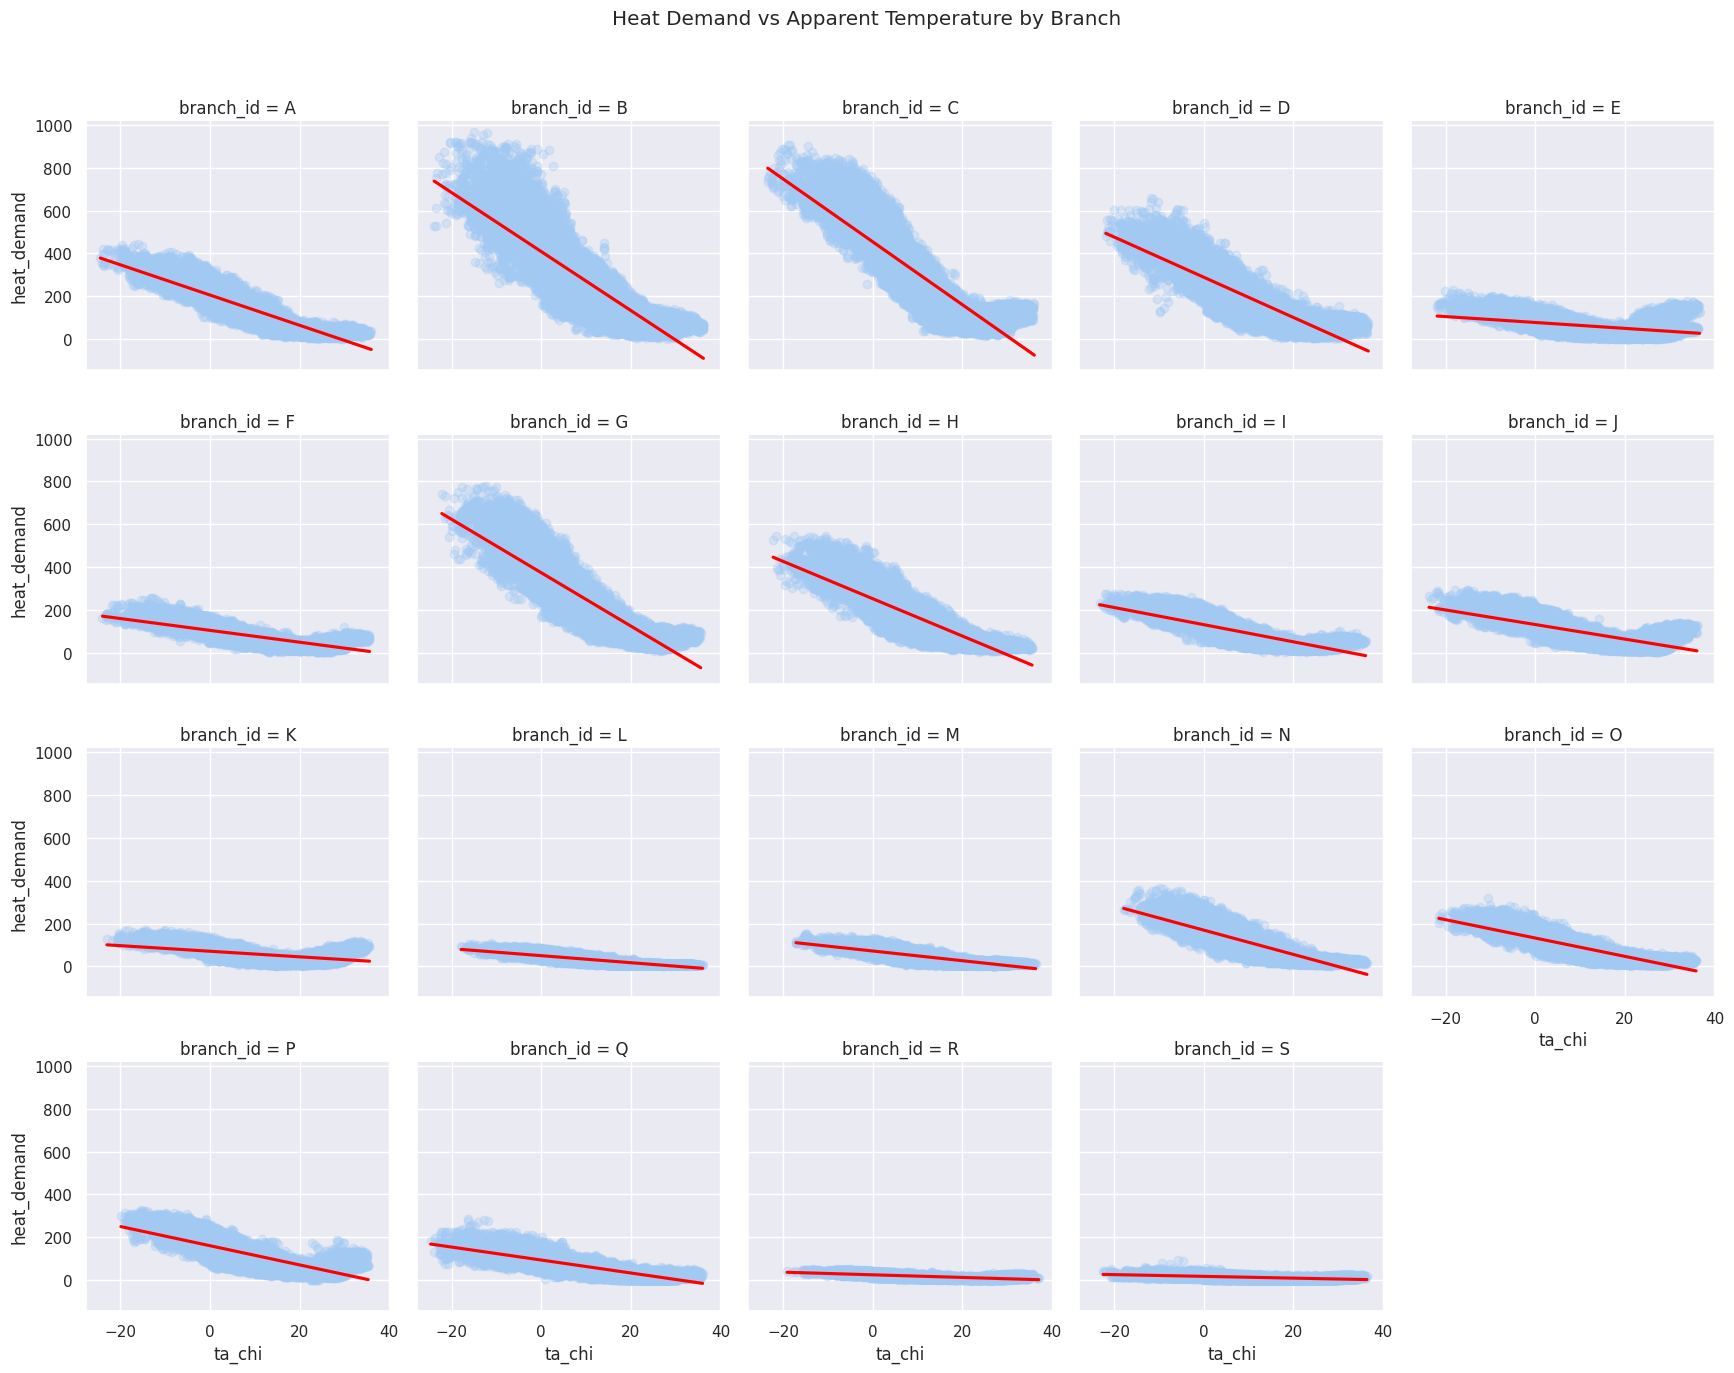

In [101]:
g = sns.lmplot(data=df_train, x='ta_chi', y='heat_demand', col='branch_id', col_wrap=5,
               scatter_kws={'alpha':0.3}, line_kws={'color':'red'}, height=3.5, aspect=1)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Heat Demand vs Apparent Temperature by Branch')


## **3. 결측치**

##### **(1) 결측치 확인**

In [32]:
# 결측치 확인
missing_df = pd.DataFrame({
    'Missing Count': df_train.isnull().sum(),
    'Missing Ratio (%)': df_train.isnull().mean() * 100
})

# 결측치가 있는 열만 추출
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)
print(missing_df)

        Missing Count  Missing Ratio (%)
si             232908          46.648961
hm              39711           7.953685
rn_hr1          19152           3.835939
wd              18813           3.768041
ws              18813           3.768041
rn_day          18624           3.730186
ta              12995           2.602758
ta_chi             20           0.004006


##### **(2) ta, wd, ws, m_day, m_hr1, hm 변수**

 이 변수들은 다같이 비어있는 경우가 많음 (지사의 휴식기간..? 인 거 같음)
    
연속으로 결측인 경우 먼저 확인

 우선 ta를 기준으로 추출을 한 뒤에 직접 확인을 진행해서 아래에 결과를 써둠

* ta

In [38]:
# 1. ta가 결측인 경우를 표시한 boolean 시리즈 생성
ta_null = df_train['ta'].isnull()

# 2. 결측이 연속된 구간마다 그룹 번호 부여
ta_null_group = (ta_null != ta_null.shift()).cumsum()

# 3. 결측 True인 행만 추출하고 group 번호 추가
ta_null_df = df_train[ta_null].copy()
ta_null_df['group'] = ta_null_group[ta_null]

# 4. 각 그룹의 통계 구하기
null_summary = ta_null_df.groupby('group').agg({
    'tm': ['count', 'min', 'max'],
    'branch_id': 'first'
}).reset_index()

# 5. 컬럼 정리
null_summary.columns = ['group','length', 'start_time', 'end_time', 'branch_id']

# 6. 기간 일수 추가 (종료 - 시작)
null_summary['duration_days'] = (null_summary['end_time'] - null_summary['start_time']).dt.days + 1

# 7. 연속 길이 1 초과 필터링 및 정렬
null_summary = null_summary[null_summary['length'] > 1].sort_values(by='length', ascending=False).reset_index(drop=True)

# 8. 결과 확인
null_summary

group  length          start_time            end_time branch_id  \
0       86    3312 2021-07-21 18:00:00 2021-12-06 17:00:00         D   
1      184    3311 2021-07-21 18:00:00 2021-12-06 17:00:00         E   
2      312    2387 2023-06-19 08:00:00 2023-09-26 18:00:00         F   
3      474     311 2021-12-03 14:00:00 2021-12-16 12:00:00         J   
4      530     247 2023-06-17 09:00:00 2023-06-27 15:00:00         K   
..     ...     ...                 ...                 ...       ...   
244    790       2 2022-04-21 10:00:00 2022-04-21 11:00:00         S   
245    794       2 2022-07-05 10:00:00 2022-07-05 11:00:00         S   
246    802       2 2022-10-24 12:00:00 2022-10-24 13:00:00         S   
247    804       2 2022-10-27 07:00:00 2022-10-27 08:00:00         S   
248    808       2 2022-12-05 07:00:00 2022-12-05 08:00:00         S   

     duration_days  
0              138  
1              138  
2              100  
3               13  
4               11  
..             ...  
244              1  
245              1  
246              1  
247              1  
248              1  

[249 rows x 6 columns]

In [40]:
# 가장 긴 결측 구간 보기
longest_group = null_summary.loc[0, 'group']
df_train.loc[ta_null_group[ta_null_group == longest_group].index]

tm branch_id  ta  wd  ws  rn_day  rn_hr1  hm    si  \
83676 2021-07-21 18:00:00         D NaN NaN NaN     NaN     NaN NaN  1.39   
83677 2021-07-21 19:00:00         D NaN NaN NaN     NaN     NaN NaN  0.67   
83678 2021-07-21 20:00:00         D NaN NaN NaN     NaN     NaN NaN  0.04   
83679 2021-07-21 21:00:00         D NaN NaN NaN     NaN     NaN NaN   NaN   
83680 2021-07-21 22:00:00         D NaN NaN NaN     NaN     NaN NaN   NaN   
...                   ...       ...  ..  ..  ..     ...     ...  ..   ...   
86983 2021-12-06 13:00:00         D NaN NaN NaN     NaN     NaN NaN  1.79   
86984 2021-12-06 14:00:00         D NaN NaN NaN     NaN     NaN NaN  1.35   
86985 2021-12-06 15:00:00         D NaN NaN NaN     NaN     NaN NaN  1.01   
86986 2021-12-06 16:00:00         D NaN NaN NaN     NaN     NaN NaN  0.57   
86987 2021-12-06 17:00:00         D NaN NaN NaN     NaN     NaN NaN  0.09   

       ta_chi  heat_demand  year  quarter  month  day_of_week  season  \
83676    33.8         56.0  2021        3      7            2  Summer   
83677    32.9         50.0  2021        3      7            2  Summer   
83678    30.7         39.0  2021        3      7            2  Summer   
83679    29.2         37.0  2021        3      7            2  Summer   
83680    28.6         36.0  2021        3      7            2  Summer   
...       ...          ...   ...      ...    ...          ...     ...   
86983    11.3        259.0  2021        4     12            0  Winter   
86984    11.9        222.0  2021        4     12            0  Winter   
86985    11.9        194.0  2021        4     12            0  Winter   
86986    11.1        196.0  2021        4     12            0  Winter   
86987     9.1        213.0  2021        4     12            0  Winter   

      is_weekend  weekofyear  hour_group  
83676    Weekday          29           6  
83677    Weekday          29           6  
83678    Weekday          29           6  
83679    Weekday          29           7  
83680    Weekday          29           7  
...          ...         ...         ...  
86983    Weekday          49           4  
86984    Weekday          49           4  
86985    Weekday          49           5  
86986    Weekday          49           5  
86987    Weekday          49           5  

[3312 rows x 19 columns]

In [41]:
# 두번째로 긴 결측 구간 보기
longest_group = null_summary.loc[1, 'group']
df_train.loc[ta_null_group[ta_null_group == longest_group].index]

tm branch_id  ta  wd  ws  rn_day  rn_hr1  hm    si  \
109949 2021-07-21 18:00:00         E NaN NaN NaN     NaN     NaN NaN  1.39   
109950 2021-07-21 19:00:00         E NaN NaN NaN     NaN     NaN NaN  0.67   
109951 2021-07-21 20:00:00         E NaN NaN NaN     NaN     NaN NaN  0.04   
109952 2021-07-21 21:00:00         E NaN NaN NaN     NaN     NaN NaN   NaN   
109953 2021-07-21 22:00:00         E NaN NaN NaN     NaN     NaN NaN   NaN   
...                    ...       ...  ..  ..  ..     ...     ...  ..   ...   
113255 2021-12-06 13:00:00         E NaN NaN NaN     NaN     NaN NaN  1.79   
113256 2021-12-06 14:00:00         E NaN NaN NaN     NaN     NaN NaN  1.35   
113257 2021-12-06 15:00:00         E NaN NaN NaN     NaN     NaN NaN  1.01   
113258 2021-12-06 16:00:00         E NaN NaN NaN     NaN     NaN NaN  0.57   
113259 2021-12-06 17:00:00         E NaN NaN NaN     NaN     NaN NaN  0.09   

        ta_chi  heat_demand  year  quarter  month  day_of_week  season  \
109949    33.8        115.0  2021        3      7            2  Summer   
109950    32.9         93.0  2021        3      7            2  Summer   
109951    30.7         57.0  2021        3      7            2  Summer   
109952    29.2         34.0  2021        3      7            2  Summer   
109953    28.6         27.0  2021        3      7            2  Summer   
...        ...          ...   ...      ...    ...          ...     ...   
113255    11.3         78.0  2021        4     12            0  Winter   
113256    11.9         71.0  2021        4     12            0  Winter   
113257    11.9         73.0  2021        4     12            0  Winter   
113258    11.1         82.0  2021        4     12            0  Winter   
113259     9.1         79.0  2021        4     12            0  Winter   

       is_weekend  weekofyear  hour_group  
109949    Weekday          29           6  
109950    Weekday          29           6  
109951    Weekday          29           6  
109952    Weekday          29           7  
109953    Weekday          29           7  
...           ...         ...         ...  
113255    Weekday          49           4  
113256    Weekday          49           4  
113257    Weekday          49           5  
113258    Weekday          49           5  
113259    Weekday          49           5  

[3311 rows x 19 columns]



> D 지사가 2021년 7월 21일 오후 6시 ~ 2021년 12월 6일 오후 5시까지 ta부터 hm까지 결측임 (약 138일)

> E 지사가 2021년 7월 21일 오후 6시 ~ 2021년 12월 6일 오후 5시까지 ta부터 hm까지 결측임 (약 138일)

> F 지사가 2023년 6월 19일 오전 8시 ~ 2023년 9월 26일 오후 6시까지 ta부터 hm까지 결측임 (약 100일)

> J 지사가 2021년 12월 3일 14시부터 2021년 12월 16일 12시까지 ta부터 hm까지 결측임 (약 13일)

> K 지사가 2023년 6월 17일 9시부터 2023년 6월 27일 15시까지 ta부터 hm까지 결측임 (약 11일)

> S 지사가 2021년 11월 12일 09시부터 2021년 11월 30일 16시까지 결측 (11월 17시 17시, 11월 25일 16시만 중간에 ta가 기록됨, 약 19일)

> K 지사가 2023년 6월 30일 6시부터 2023년 7월 6일 13시까지 ta부터 hm까지 결측임 (약 7일)

> K 지사가 2022년 8월 14일 19시부터 2022년 8월 19일 14시까지 ta부터 hm까지 결측임 (약 5일)

> M 지사가 2022년 3월 30일 22시부터 2022년 4월 4일 10시까지 ta부터 hm까지 결측임 (약 5일)

> K 지사가 2022년 4월 15일 21시부터 2022년 4월 19일 14시까지 ta부터 hm까지 결측임 (약 5일, 마지막날 14시부터 23일까지는 ta만 결측)



>> 결측치 처리 제안

>> 우선 장기결측 / 단기결측으로 나누기 (장기는 약 5일 이상, 단기는 4일 이하) - 이렇게 다수의 변수들이 공통으로 결측인 경우를 먼저 채우자!

>> 단기 결측인 경우, 해당 지사 내에서 시간 보간을 사용하여 진행한다. 장기결측인 경우 (1) 동일 시간대 다른 지사들의 평균 또는 중앙값 사용하기, (2) 같은 클러스터 내 지사만 사용하여 동일 시간대 평균 또는 중앙값 사용하기 (아무래도 기온, 풍속 등은 지사간 차이가 분명 존재할거니까 군집화를 사용해서)

* wd

In [42]:
# 1. ta가 결측인 경우를 표시한 boolean 시리즈 생성
wd_null = df_train['wd'].isnull()

# 2. 결측이 연속된 구간마다 그룹 번호 부여
wd_null_group = (wd_null != wd_null.shift()).cumsum()

# 3. 결측 True인 행만 추출하고 group 번호 추가
wd_null_df = df_train[wd_null].copy()
wd_null_df['group'] = wd_null_group[wd_null]

# 4. 각 그룹의 통계 구하기
null_summary2 = wd_null_df.groupby('group').agg({
    'tm': ['count', 'min', 'max'],
    'branch_id': 'first'
}).reset_index()

# 5. 컬럼 정리
null_summary2.columns = ['group','length', 'start_time', 'end_time', 'branch_id']

# 6. 기간 일수 추가 (종료 - 시작)
null_summary2['duration_days'] = (null_summary2['end_time'] - null_summary2['start_time']).dt.days + 1

# 7. 연속 길이 1 초과 필터링 및 정렬
null_summary2 = null_summary2[null_summary2['length'] > 1].sort_values(by='length', ascending=False).reset_index(drop=True)

# 8. 결과 확인
null_summary2

group  length          start_time            end_time branch_id  \
0      558    3313 2021-07-21 17:00:00 2021-12-06 17:00:00         D   
1      988    3312 2021-07-21 17:00:00 2021-12-06 17:00:00         E   
2     1488    2393 2023-06-19 08:00:00 2023-09-27 00:00:00         F   
3     1340    1311 2023-09-30 01:00:00 2023-11-23 15:00:00         E   
4      910    1311 2023-09-30 01:00:00 2023-11-23 15:00:00         D   
..     ...     ...                 ...                 ...       ...   
615   3732       2 2022-06-18 17:00:00 2022-06-18 18:00:00         S   
616    120       2 2021-07-04 07:00:00 2021-07-04 08:00:00         B   
617     54       2 2021-02-15 06:00:00 2021-02-15 07:00:00         B   
618     18       2 2022-08-28 09:00:00 2022-08-28 10:00:00         A   
619      2       2 2021-06-01 02:00:00 2021-06-01 03:00:00         A   

     duration_days  
0              139  
1              139  
2              100  
3               55  
4               55  
..             ...  
615              1  
616              1  
617              1  
618              1  
619              1  

[620 rows x 6 columns]

In [51]:
null_summary2.iloc[:12,:]

group  length          start_time            end_time branch_id  \
0     558    3313 2021-07-21 17:00:00 2021-12-06 17:00:00         D   
1     988    3312 2021-07-21 17:00:00 2021-12-06 17:00:00         E   
2    1488    2393 2023-06-19 08:00:00 2023-09-27 00:00:00         F   
3    1340    1311 2023-09-30 01:00:00 2023-11-23 15:00:00         E   
4     910    1311 2023-09-30 01:00:00 2023-11-23 15:00:00         D   
5    3542     439 2021-11-12 09:00:00 2021-11-30 16:00:00         S   
6    2756     311 2021-12-03 14:00:00 2021-12-16 12:00:00         J   
7    2910     248 2023-06-17 09:00:00 2023-06-27 16:00:00         K   
8    2914     152 2023-06-30 06:00:00 2023-07-06 13:00:00         K   
9    2876     117 2022-08-14 18:00:00 2022-08-19 14:00:00         K   
10   3044     109 2022-03-30 22:00:00 2022-04-04 10:00:00         M   
11    904      96 2023-09-18 01:00:00 2023-09-22 00:00:00         D   

    duration_days  
0             139  
1             139  
2             100  
3              55  
4              55  
5              19  
6              13  
7              11  
8               7  
9               5  
10              5  
11              4

위에서 ta랑 공통인건 제외하고 작성

> E 지사가 2023년 9월 30일 01시 ~ 2023년 11월 23일 15시까지 wd, ws 가 결측임 (약 55일)

> D 지사가 2023년 9월 30일 01시 ~ 2023년 11월 23일 15시까지 wd, ws 가 결측임 (약 55일)


* ws

In [52]:
# 1. ta가 결측인 경우를 표시한 boolean 시리즈 생성
ws_null = df_train['ws'].isnull()

# 2. 결측이 연속된 구간마다 그룹 번호 부여
ws_null_group = (ws_null != ws_null.shift()).cumsum()

# 3. 결측 True인 행만 추출하고 group 번호 추가
ws_null_df = df_train[ws_null].copy()
ws_null_df['group'] = ws_null_group[ws_null]

# 4. 각 그룹의 통계 구하기
null_summary3 = ws_null_df.groupby('group').agg({
    'tm': ['count', 'min', 'max'],
    'branch_id': 'first'
}).reset_index()

# 5. 컬럼 정리
null_summary3.columns = ['group','length', 'start_time', 'end_time', 'branch_id']

# 6. 기간 일수 추가 (종료 - 시작)
null_summary3['duration_days'] = (null_summary3['end_time'] - null_summary3['start_time']).dt.days + 1

# 7. 연속 길이 1 초과 필터링 및 정렬
null_summary3 = null_summary3[null_summary3['length'] > 1].sort_values(by='length', ascending=False).reset_index(drop=True)

# 8. 결과 확인
null_summary3

group  length          start_time            end_time branch_id  \
0      558    3313 2021-07-21 17:00:00 2021-12-06 17:00:00         D   
1      988    3312 2021-07-21 17:00:00 2021-12-06 17:00:00         E   
2     1488    2393 2023-06-19 08:00:00 2023-09-27 00:00:00         F   
3     1340    1311 2023-09-30 01:00:00 2023-11-23 15:00:00         E   
4      910    1311 2023-09-30 01:00:00 2023-11-23 15:00:00         D   
..     ...     ...                 ...                 ...       ...   
615   3732       2 2022-06-18 17:00:00 2022-06-18 18:00:00         S   
616    120       2 2021-07-04 07:00:00 2021-07-04 08:00:00         B   
617     54       2 2021-02-15 06:00:00 2021-02-15 07:00:00         B   
618     18       2 2022-08-28 09:00:00 2022-08-28 10:00:00         A   
619      2       2 2021-06-01 02:00:00 2021-06-01 03:00:00         A   

     duration_days  
0              139  
1              139  
2              100  
3               55  
4               55  
..             ...  
615              1  
616              1  
617              1  
618              1  
619              1  

[620 rows x 6 columns]

In [53]:
null_summary3.iloc[:15,:]

group  length          start_time            end_time branch_id  \
0     558    3313 2021-07-21 17:00:00 2021-12-06 17:00:00         D   
1     988    3312 2021-07-21 17:00:00 2021-12-06 17:00:00         E   
2    1488    2393 2023-06-19 08:00:00 2023-09-27 00:00:00         F   
3    1340    1311 2023-09-30 01:00:00 2023-11-23 15:00:00         E   
4     910    1311 2023-09-30 01:00:00 2023-11-23 15:00:00         D   
5    3542     439 2021-11-12 09:00:00 2021-11-30 16:00:00         S   
6    2756     311 2021-12-03 14:00:00 2021-12-16 12:00:00         J   
7    2910     248 2023-06-17 09:00:00 2023-06-27 16:00:00         K   
8    2914     152 2023-06-30 06:00:00 2023-07-06 13:00:00         K   
9    2876     117 2022-08-14 18:00:00 2022-08-19 14:00:00         K   
10   3044     109 2022-03-30 22:00:00 2022-04-04 10:00:00         M   
11    904      96 2023-09-18 01:00:00 2023-09-22 00:00:00         D   
12   1336      96 2023-09-23 01:00:00 2023-09-27 00:00:00         E   
13   1330      96 2023-09-11 01:00:00 2023-09-15 00:00:00         E   
14    906      96 2023-09-23 01:00:00 2023-09-27 00:00:00         D   

    duration_days  
0             139  
1             139  
2             100  
3              55  
4              55  
5              19  
6              13  
7              11  
8               7  
9               5  
10              5  
11              4  
12              4  
13              4  
14              4

이전에 다 나온 연속된 결측치임

* rn_day

In [61]:
df_train['rn_day'].isnull().sum()

np.int64(18624)

In [68]:
def compute_null_streaks(df, column_name):
    """
    특정 column에 대해 branch별 연속 결측 구간을 계산하는 함수
    """
    result = []

    for branch in df['branch_id'].unique():
        df_branch = df[df['branch_id'] == branch].copy()

        # 결측 여부 마스크
        null_mask = df_branch[column_name].isnull()

        # 연속 구간 그룹 번호 부여
        group = (null_mask != null_mask.shift()).cumsum()

        # 결측만 필터링
        df_null = df_branch[null_mask].copy()
        df_null['group'] = group[null_mask]

        # 그룹별 통계
        summary = df_null.groupby('group').agg({
            'tm': ['count', 'min', 'max']
        }).reset_index()
        summary.columns = ['group', 'length', 'start_time', 'end_time']
        summary['branch_id'] = branch
        summary['feature'] = column_name
        summary['duration_days'] = (summary['end_time'] - summary['start_time']).dt.days + 1

        result.append(summary)

    return pd.concat(result, ignore_index=True)

# 각각 계산
rn_day_null_df = compute_null_streaks(df_train, 'rn_day')

# 길이 1 초과인 경우만 보기
rn_day_null_df = rn_day_null_df[rn_day_null_df['length'] > 1].sort_values(by='length', ascending=False).reset_index(drop=True)

# 결과 확인
rn_day_null_df

group  length          start_time            end_time branch_id feature  \
0       18    3343 2021-07-21 18:00:00 2021-12-08 00:00:00         D  rn_day   
1       18    3342 2021-07-21 18:00:00 2021-12-08 00:00:00         E  rn_day   
2       74    1762 2023-06-19 08:00:00 2023-08-31 17:00:00         F  rn_day   
3       76     630 2023-08-31 19:00:00 2023-09-27 00:00:00         F  rn_day   
4       64     432 2022-07-31 01:00:00 2022-08-18 00:00:00         H  rn_day   
..     ...     ...                 ...                 ...       ...     ...   
595     90       2 2021-12-27 02:00:00 2021-12-27 03:00:00         S  rn_day   
596     22       2 2022-07-13 10:00:00 2022-07-13 11:00:00         B  rn_day   
597     30       2 2022-10-24 12:00:00 2022-10-24 13:00:00         B  rn_day   
598     32       2 2022-10-27 07:00:00 2022-10-27 08:00:00         B  rn_day   
599     42       2 2023-07-30 23:00:00 2023-07-31 00:00:00         B  rn_day   

     duration_days  
0              140  
1              140  
2               74  
3               27  
4               18  
..             ...  
595              1  
596              1  
597              1  
598              1  
599              1  

[600 rows x 7 columns]

In [69]:
rn_day_null_df.iloc[:15,:]

group  length          start_time            end_time branch_id feature  \
0      18    3343 2021-07-21 18:00:00 2021-12-08 00:00:00         D  rn_day   
1      18    3342 2021-07-21 18:00:00 2021-12-08 00:00:00         E  rn_day   
2      74    1762 2023-06-19 08:00:00 2023-08-31 17:00:00         F  rn_day   
3      76     630 2023-08-31 19:00:00 2023-09-27 00:00:00         F  rn_day   
4      64     432 2022-07-31 01:00:00 2022-08-18 00:00:00         H  rn_day   
5      64     432 2022-07-31 01:00:00 2022-08-18 00:00:00         G  rn_day   
6      18     311 2021-12-03 14:00:00 2021-12-16 12:00:00         J  rn_day   
7      58     247 2023-06-17 09:00:00 2023-06-27 15:00:00         K  rn_day   
8      74     189 2021-11-17 18:00:00 2021-11-25 15:00:00         S  rn_day   
9      60     152 2023-06-30 06:00:00 2023-07-06 13:00:00         K  rn_day   
10     72     128 2021-11-12 09:00:00 2021-11-17 16:00:00         S  rn_day   
11     76     120 2021-11-25 17:00:00 2021-11-30 16:00:00         S  rn_day   
12     44     116 2022-08-14 19:00:00 2022-08-19 14:00:00         K  rn_day   
13     18     109 2022-03-30 22:00:00 2022-04-04 10:00:00         M  rn_day   
14     32      90 2022-04-15 21:00:00 2022-04-19 14:00:00         K  rn_day   

    duration_days  
0             140  
1             140  
2              74  
3              27  
4              18  
5              18  
6              13  
7              11  
8               8  
9               7  
10              6  
11              5  
12              5  
13              5  
14              4

위에서 공통인건 제외하고 작성

> H 지사가 2022년 7월 31일 01시 ~ 2022년 8월 18일 00시까지 rn_day, rn_hr1가 결측임 (약 18일)

> G 지사가 2022년 7월 31일 01시 ~ 2022년 8월 18일 00시까지 rn_day, rn_hr1가 결측임 (약 18일)

* hm

In [73]:
# 각각 계산
hm_null_df = compute_null_streaks(df_train, 'hm')

# 길이 1 초과인 경우만 보기
hm_null_df = hm_null_df[hm_null_df['length'] > 1].sort_values(by='length', ascending=False).reset_index(drop=True)

# 결과 확인
hm_null_df

group  length          start_time            end_time branch_id feature  \
0       13    4818 2021-05-20 00:00:00 2021-12-06 17:00:00         D      hm   
1       13    4817 2021-05-20 00:00:00 2021-12-06 17:00:00         E      hm   
2        1    4817 2021-01-01 01:00:00 2021-07-20 17:00:00         N      hm   
3        1    4669 2021-01-01 01:00:00 2021-07-14 13:00:00         Q      hm   
4        1    3659 2021-01-01 01:00:00 2021-06-02 11:00:00         I      hm   
..     ...     ...                 ...                 ...       ...     ...   
272     19       2 2022-07-05 10:00:00 2022-07-05 11:00:00         D      hm   
273     40       2 2021-10-19 18:00:00 2021-10-19 19:00:00         S      hm   
274     76       2 2021-12-29 03:00:00 2021-12-29 04:00:00         S      hm   
275     80       2 2021-12-29 15:00:00 2021-12-29 16:00:00         S      hm   
276     84       2 2021-12-30 08:00:00 2021-12-30 09:00:00         S      hm   

     duration_days  
0              201  
1              201  
2              201  
3              195  
4              153  
..             ...  
272              1  
273              1  
274              1  
275              1  
276              1  

[277 rows x 7 columns]

In [74]:
hm_null_df.iloc[:15,:]

group  length          start_time            end_time branch_id feature  \
0      13    4818 2021-05-20 00:00:00 2021-12-06 17:00:00         D      hm   
1      13    4817 2021-05-20 00:00:00 2021-12-06 17:00:00         E      hm   
2       1    4817 2021-01-01 01:00:00 2021-07-20 17:00:00         N      hm   
3       1    4669 2021-01-01 01:00:00 2021-07-14 13:00:00         Q      hm   
4       1    3659 2021-01-01 01:00:00 2021-06-02 11:00:00         I      hm   
5       1    2513 2021-01-01 01:00:00 2021-04-15 17:00:00         K      hm   
6       1    2511 2021-01-01 01:00:00 2021-04-15 15:00:00         D      hm   
7       1    2510 2021-01-01 01:00:00 2021-04-15 15:00:00         E      hm   
8       1    2485 2021-01-01 01:00:00 2021-04-14 13:00:00         B      hm   
9      50    2387 2023-06-19 08:00:00 2023-09-26 18:00:00         F      hm   
10      6     311 2021-12-03 14:00:00 2021-12-16 12:00:00         J      hm   
11     23     247 2023-06-17 09:00:00 2023-06-27 15:00:00         K      hm   
12     52     189 2021-11-17 18:00:00 2021-11-25 15:00:00         S      hm   
13     32     155 2022-04-16 13:00:00 2022-04-22 23:00:00         F      hm   
14     25     152 2023-06-30 06:00:00 2023-07-06 13:00:00         K      hm   

    duration_days  
0             201  
1             201  
2             201  
3             195  
4             153  
5             105  
6             105  
7             105  
8             104  
9             100  
10             13  
11             11  
12              8  
13              7  
14              7

위에서 공통인건 제외하고 작성

> D 지사가 2021년 5월 20일 00시 ~ 2021년 12월 6일 17시까지 hm이 결측임 (약 201일, 이때 138일은 위에 다른 변수들이랑 공통 결측)

> E 지사가 2021년 5월 20일 00시 ~ 2021년 12월 6일 17시까지 hm이 결측임 (약 201일, 이때 138일은 위에 다른 변수들이랑 공통 결측)

> N 지사가 2021년 1월 1일 01시 ~ 2021년 7월 20일 17시까지 hm이 결측임 (약 201일)

> Q 지사가 2021년 1월 1일 01시 ~ 2021년 7월 14일 13시까지 hm이 결측임 (약 195일)

> I 지사가 2021년 1월 1일 01시 ~ 2021년 6월 2일 111시까지 hm이 결측임 (약 153일)

> 다 안 적음


##### **(3) si 변수**

In [ ]:
missing_si_count = df_train['si'].isnull().sum()
print(f"결측값 개수: {missing_si_count}")

결측값 개수: 232908


> 대략 일사량이 없을 때는 그냥 측정을 안 함. 그러니까 그냥 0으로 해도 될 거 같음

> 1월,2월 : 19 ~ 07 없음 / 3월 : 20 ~ 07 없음 /4월, 10월, 20 ~ 06 없음 / 5월,6월, 7월, 8월: , 21 ~ 05 없음 /  9월 : 21 ~ 06없음 / 11월, 12월 : 19 ~ 06 없음 (대략 이런식이고 정확하게 측정 시간을 변경하는건 예를 들어서 11월 15일~이런식임)

In [ ]:
# 각각 계산
si_null_df = compute_null_streaks(df_train, 'si')

# 길이 1 초과인 경우만 보기
si_null_df = si_null_df[si_null_df['length'] > 1].sort_values(by='length', ascending=False).reset_index(drop=True)

# 결과 확인
si_null_df

group  length          start_time            end_time branch_id  \
0          1   17983 2021-01-01 01:00:00 2023-01-20 07:00:00         P   
1        823      66 2022-02-13 20:00:00 2022-02-16 13:00:00         M   
2        469      62 2021-08-22 21:00:00 2021-08-25 10:00:00         R   
3         25      61 2023-01-31 19:00:00 2023-02-03 07:00:00         P   
4        541      47 2021-09-29 14:00:00 2021-10-01 12:00:00         R   
...      ...     ...                 ...                 ...       ...   
19772   2145       2 2023-12-06 16:00:00 2023-12-06 17:00:00         D   
19773   1173       2 2022-08-08 13:00:00 2022-08-08 14:00:00         C   
19774   1173       2 2022-08-08 13:00:00 2022-08-08 14:00:00         B   
19775   1173       2 2022-08-08 13:00:00 2022-08-08 14:00:00         A   
19776   2145       2 2023-12-06 16:00:00 2023-12-06 17:00:00         S   

      feature  duration_days  
0          si            750  
1          si              3  
2          si              3  
3          si              3  
4          si              2  
...       ...            ...  
19772      si              1  
19773      si              1  
19774      si              1  
19775      si              1  
19776      si              1  

[19777 rows x 7 columns]

In [ ]:
# 대략적으로 확인 !!!
# 시간 컬럼이 없다면 생성
df_train['hour'] = df_train['tm'].dt.hour

# 측정이 이루어지는 시간대만 필터링 (08시 ~ 18시)
measured_df = df_train[df_train['hour'].between(8, 18)]

# 이 구간에서 si 결측인 행 개수 확인
si_missing_count = measured_df['si'].isnull().sum()

# 전체 측정 구간 행 개수도 함께 보기
total_measured_count = len(measured_df)

# 결과 출력
print(f"측정 시간대(07시~18시)에서의 si 결측 수: {si_missing_count}")
print(f"전체 측정 시간대 행 수: {total_measured_count}")
print(f"결측 비율: {si_missing_count / total_measured_count:.2%}")

측정 시간대(07시~18시)에서의 si 결측 수: 8700
전체 측정 시간대 행 수: 228848
결측 비율: 3.80%


> P지점은 2021년 1월 1일 01시부터 2023년 01월 20일 07까지 아예 기록이 없음. 그 뒤부터는 나머지랑 동일하게 기록됨

>> 기록되지 않은 경우, P지점 결측을 제외하면 결측이 엄청 많지는 않을 것 같음

>> (1) 기록되지 않은 경우는 0으로 채우기, (2) P지점 결측은 이것도 앞의 결측과 마찬가지로 처리 방안 2개중 고민, (3) 그 이외의 결측은 보간

##### **(4) ta_chi 변수**

In [ ]:
missing_si_count = df_train['ta_chi'].isnull().sum()
print(f"결측값 개수: {missing_si_count}")

결측값 개수: 20


> 그냥 보간 ㄱㄱ